## Recomposição XGBoosting

In [8]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path

def criar_dataset_multi_step(series, look_back=10, passo=1):
    """
    Dataset para LSTM - EXATAMENTE igual ao código de treinamento
    """
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])  # Sem flatten aqui
        y.append(series[i+look_back+passo-1])  # EXATO como no treinamento
    return np.array(X), np.array(y)

def criar_dataset_xgb_simples(series, look_back=5, passo=1):
    """
    Dataset XGBoost SIMPLES - alinhado com LSTM
    """
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        sequencia = series[i:i+look_back].flatten()  # Flatten para XGBoost
        target = series[i+look_back+passo-1]  # MESMO alinhamento que LSTM
        X.append(sequencia)
        y.append(target[0] if hasattr(target, '__len__') else target)
    return np.array(X), np.array(y)

def calcular_metricas(y_true, y_pred):
    """Calcular métricas de avaliação"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    
    # Métricas adicionais
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'RMSE': rmse,
        'MAE': mae, 
        'MAPE': mape,
        'C30': c30,
        'R2': r2
    }

def obter_look_back_correto(passo):
    """
    Retorna o look_back correto baseado no passo de previsão
    - t+1 e t+5: look_back = 5
    - demais: look_back = 10
    """
    if passo in [1, 5]:
        return 5
    else:
        return 10

def prever_componente_xgb_simples(nome_comp, passo):
    """
    Previsão XGBoost SIMPLES - ALINHADO com LSTM
    """
    print(f"   🌲 Prevendo {nome_comp.upper()} com XGBoost SIMPLES...")
    
    # Look_back baseado na regra
    look_back_xgb = obter_look_back_correto(passo)
    
    # Carregar dados
    serie_path = Path(f"{nome_comp.upper()}_component.csv")
    if not serie_path.exists():
        raise FileNotFoundError(f"Arquivo {serie_path} não encontrado")
    
    serie = pd.read_csv(serie_path)[nome_comp.upper()].values.reshape(-1, 1)
    
    # Carregar scaler
    scaler_path = Path(f"scalersXGB/scaler_{nome_comp.lower()}_t{passo}.joblib")
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler {scaler_path} não encontrado")
    
    scaler = joblib.load(scaler_path)
    serie_scaled = scaler.transform(serie)
    
    print(f"      - Scaler: {type(scaler).__name__}")
    print(f"      - Look_back: {look_back_xgb}")
    
    # Criar dataset ALINHADO com LSTM
    X, _ = criar_dataset_xgb_simples(serie_scaled, look_back_xgb, passo)
    
    print(f"      - Dataset shape: {X.shape}")
    
    # Carregar modelo
    modelo_path = Path(f"modelosXGB/xgb_{nome_comp.lower()}_t{passo}.joblib")
    if not modelo_path.exists():
        raise FileNotFoundError(f"Modelo {modelo_path} não encontrado")
    
    modelo = joblib.load(modelo_path)
    
    # Verificar compatibilidade
    if X.shape[1] == modelo.n_features_in_:
        print(f"      ✅ Compatível: {X.shape[1]} features")
    else:
        raise ValueError(f"Incompatibilidade: Dataset={X.shape[1]} vs Modelo={modelo.n_features_in_}")
    
    # Fazer previsão
    y_pred_scaled = modelo.predict(X)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    print(f"      ✅ Previsão: {len(y_pred)} pontos, range=[{y_pred.min():.3f}, {y_pred.max():.3f}], std={np.std(y_pred):.4f}")
    
    return y_pred

def otimizar_pesos_componentes_original(y_real_original, componentes_pred, passo):
    """
    Otimização de pesos na ESCALA ORIGINAL (sem normalização)
    """
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    
    print(f"   🎯 Otimizando pesos na escala original...")
    
    # Garantir mesmo tamanho
    min_len = min(len(y_real_original), *[len(comp) for comp in componentes_pred])
    
    # Matriz de componentes (escala original)
    X_componentes = np.column_stack([comp[:min_len] for comp in componentes_pred])
    y_target = y_real_original[:min_len]
    
    # Ridge regression
    reg = Ridge(alpha=0.1, fit_intercept=False)
    reg.fit(X_componentes, y_target)
    
    pesos_otimizados = reg.coef_
    r2 = r2_score(y_target, reg.predict(X_componentes))
    
    # Log dos pesos
    nomes_comp = ['A3', 'D1', 'D2', 'D3']
    for nome, peso in zip(nomes_comp, pesos_otimizados):
        print(f"      - Peso {nome}: {peso:.4f}")
    
    print(f"      - R² da otimização: {r2:.4f}")
    
    # Salvar configuração
    pesos_config = {
        'passo': passo,
        'pesos': {nome: float(peso) for nome, peso in zip(nomes_comp, pesos_otimizados)},
        'r2_score': float(r2),
        'metodo': 'Ridge_escala_original'
    }
    
    os.makedirs("pesosXGB", exist_ok=True)
    with open(f"pesosXGB/pesos_originais_t{passo}.json", 'w') as f:
        json.dump(pesos_config, f, indent=2)
    
    return pesos_otimizados
    """
    Otimização de pesos com regularização Ridge
    """
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    
    print(f"   🎯 Otimizando pesos com regularização...")
    
    # Garantir mesmo tamanho
    min_len = min(len(y_real_norm), *[len(comp) for comp in componentes_pred])
    
    # Matriz de componentes
    X_componentes = np.column_stack([comp[:min_len] for comp in componentes_pred])
    y_target = y_real_norm[:min_len]
    
    # Ridge regression
    reg = Ridge(alpha=0.1, fit_intercept=False)
    reg.fit(X_componentes, y_target)
    
    pesos_otimizados = reg.coef_
    r2 = r2_score(y_target, reg.predict(X_componentes))
    
    # Log dos pesos
    nomes_comp = ['A3', 'D1', 'D2', 'D3']
    for nome, peso in zip(nomes_comp, pesos_otimizados):
        print(f"      - Peso {nome}: {peso:.4f}")
    
    print(f"      - R² da otimização: {r2:.4f}")
    
    # Salvar configuração
    pesos_config = {
        'passo': passo,
        'pesos': {nome: float(peso) for nome, peso in zip(nomes_comp, pesos_otimizados)},
        'r2_score': float(r2),
        'metodo': 'Ridge_simplificado'
    }
    
    os.makedirs("pesosXGB", exist_ok=True)
    with open(f"pesosXGB/pesos_simples_t{passo}.json", 'w') as f:
        json.dump(pesos_config, f, indent=2)
    
    return pesos_otimizados

def carregar_pesos_otimizados_v2(passo):
    """Carrega pesos otimizados se existirem (tenta escala original primeiro)"""
    
    # Tentar carregar pesos da escala original primeiro
    config_path_orig = Path(f"pesosXGB/pesos_originais_t{passo}.json")
    config_path_norm = Path(f"pesosXGB/pesos_simples_t{passo}.json")
    
    for config_path, tipo in [(config_path_orig, "original"), (config_path_norm, "normalizado")]:
        try:
            if config_path.exists():
                with open(config_path, 'r') as f:
                    config = json.load(f)
                
                pesos = [config['pesos']['A3'], config['pesos']['D1'], 
                        config['pesos']['D2'], config['pesos']['D3']]
                r2 = config.get('r2_score', 0)
                
                print(f"   📊 Pesos {tipo} carregados (R²={r2:.3f})")
                return np.array(pesos)
        except Exception as e:
            print(f"   ⚠️ Erro ao carregar pesos {tipo}: {e}")
    
    # Pesos padrão
    print(f"   📊 Usando pesos padrão (soma simples)")
    return np.array([1.0, 1.0, 1.0, 1.0])

def aplicar_filtros_pos_processamento(y_pred, metodo='suavizacao', janela=3):
    """
    Aplica filtros de pós-processamento para suavizar previsões
    """
    try:
        if metodo == 'suavizacao':
            # Média móvel simples usando pandas
            df_temp = pd.DataFrame({'values': y_pred})
            y_filtrado = df_temp['values'].rolling(window=janela, center=True, min_periods=1).mean().values
            return y_filtrado
        
        elif metodo == 'mediana':
            # Filtro de mediana manual
            y_filtrado = np.copy(y_pred)
            half_window = janela // 2
            
            for i in range(len(y_pred)):
                start_idx = max(0, i - half_window)
                end_idx = min(len(y_pred), i + half_window + 1)
                y_filtrado[i] = np.median(y_pred[start_idx:end_idx])
            
            return y_filtrado
    except:
        pass
    
    return y_pred

def recompor_e_avaliar_lstm_xgb_simples(passo, otimizar_pesos=True, usar_pesos_salvos=True, aplicar_filtro=True):
    """
    LSTM + XGBoost SIMPLES - Avaliação da recomposição
    LSTM para A3 + XGBoost SIMPLES (sem features) para D1,D2,D3
    """
    look_back_lstm = obter_look_back_correto(passo)
    
    print(f"\n🚀 LSTM + XGBoost SIMPLES - Avaliação t+{passo}")
    print(f"   🧠 A3: LSTM (sequências) - look_back={look_back_lstm}")
    print(f"   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)")
    
    try:
        # ==============================================
        # 1. CARREGAR DADOS REAIS
        # ==============================================
        df_path = Path("RMDM_corrigido.csv")
        if not df_path.exists():
            raise FileNotFoundError("❌ Arquivo RMDM_corrigido.csv não encontrado")
        
        df = pd.read_csv(df_path)
        rmdm_real = df["RMDM"].values
        
        # Normalização dos dados reais
        scaler_rmdm = MinMaxScaler()
        rmdm_real_norm = scaler_rmdm.fit_transform(rmdm_real.reshape(-1, 1)).flatten()
        print(f"   📏 Dados reais: {len(rmdm_real)} pontos")

        # ==============================================
        # 2. LSTM PARA A3
        # ==============================================
        print(f"\n   🧠 Processando A3 com LSTM...")
        df_a3_path = Path("A3_component.csv")
        if not df_a3_path.exists():
            raise FileNotFoundError("❌ Arquivo A3_component.csv não encontrado")
        
        df_a3 = pd.read_csv(df_a3_path)
        a3 = df_a3["A3"].values

        # Carregar scaler e modelo LSTM para A3
        scaler_a3_path = Path(f"scaler_A3_t{passo}.joblib")
        model_a3_path = Path(f"lstm_a3_t{passo}.keras")
        
        if not scaler_a3_path.exists():
            raise FileNotFoundError(f"❌ Scaler A3: {scaler_a3_path}")
        if not model_a3_path.exists():
            raise FileNotFoundError(f"❌ Modelo LSTM A3: {model_a3_path}")
        
        scaler_a3 = joblib.load(scaler_a3_path)
        a3_scaled = scaler_a3.transform(a3.reshape(-1, 1))
        X_a3, _ = criar_dataset_multi_step(a3_scaled, look_back_lstm, passo)
        X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))

        model_a3 = load_model(model_a3_path)
        y_pred_a3_scaled = model_a3.predict(X_a3, verbose=0).flatten()
        y_pred_a3 = scaler_a3.inverse_transform(y_pred_a3_scaled.reshape(-1, 1)).flatten()
        
        print(f"      ✅ A3 previsto: {len(y_pred_a3)} pontos")

        # ==============================================
        # 3. XGBOOST SIMPLES PARA D1, D2, D3
        # ==============================================
        print(f"\n   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...")
        componentes_d = {}
        
        for comp in ['d1', 'd2', 'd3']:
            try:
                componentes_d[comp] = prever_componente_xgb_simples(comp, passo)
            except Exception as e:
                print(f"      ❌ Erro em {comp.upper()}: {e}")
                raise

        # Aplicar clipping muito suave
        limite_clip = 20.0
        print(f"\n   🔧 Aplicando clipping suave (limite ±{limite_clip})...")
        for comp in componentes_d:
            original_range = [componentes_d[comp].min(), componentes_d[comp].max()]
            componentes_d[comp] = np.clip(componentes_d[comp], -limite_clip, limite_clip)
            clipped_range = [componentes_d[comp].min(), componentes_d[comp].max()]
            print(f"      - {comp.upper()}: {original_range[0]:.3f}~{original_range[1]:.3f} → {clipped_range[0]:.3f}~{clipped_range[1]:.3f}")

        # Aplicar filtros de pós-processamento
        if aplicar_filtro:
            print(f"\n   🔧 Aplicando filtros de pós-processamento...")
            for comp in componentes_d:
                original_std = np.std(componentes_d[comp])
                componentes_d[comp] = aplicar_filtros_pos_processamento(
                    componentes_d[comp], 
                    metodo='suavizacao', 
                    janela=3
                )
                filtrado_std = np.std(componentes_d[comp])
                print(f"      - {comp.upper()}: std {original_std:.4f} → {filtrado_std:.4f}")

        # ==============================================
        # 4. VERIFICAÇÃO DE RECONSTRUÇÃO WAVELET
        # ==============================================
        print(f"\n   🔍 VERIFICANDO RECONSTRUÇÃO WAVELET...")
        
        # Carregar componentes originais para teste
        df_a3_orig = pd.read_csv("A3_component.csv")
        df_d1_orig = pd.read_csv("D1_component.csv") 
        df_d2_orig = pd.read_csv("D2_component.csv")
        df_d3_orig = pd.read_csv("D3_component.csv")
        
        a3_orig = df_a3_orig["A3"].values
        d1_orig = df_d1_orig["D1"].values
        d2_orig = df_d2_orig["D2"].values
        d3_orig = df_d3_orig["D3"].values
        
        # Verificar se componentes originais recompõem o sinal
        min_len_orig = min(len(a3_orig), len(d1_orig), len(d2_orig), len(d3_orig), len(rmdm_real))
        
        soma_componentes_orig = (a3_orig[:min_len_orig] + d1_orig[:min_len_orig] + 
                                d2_orig[:min_len_orig] + d3_orig[:min_len_orig])
        
        erro_reconstrucao = np.mean(np.abs(rmdm_real[:min_len_orig] - soma_componentes_orig))
        print(f"      - Erro de reconstrução original: {erro_reconstrucao:.6f}")
        
        if erro_reconstrucao > 0.001:
            print(f"      ⚠️ ALERTA: Componentes originais não recompõem perfeitamente o sinal!")
        else:
            print(f"      ✅ Componentes originais recompõem o sinal corretamente")

        # ==============================================
        # 5. ALINHAMENTO E RECOMPOSIÇÃO
        # ==============================================
        print(f"\n   📐 Alinhando dados para recomposição...")
        
        # Determinar tamanhos
        todos_componentes = [y_pred_a3] + list(componentes_d.values())
        min_len = min(len(comp) for comp in todos_componentes)
        
        # Calcular índice inicial
        max_look_back = max(look_back_lstm, obter_look_back_correto(passo))
        indice_inicial = max_look_back + passo - 1
        
        print(f"      - Look_backs: LSTM={look_back_lstm}, XGB={obter_look_back_correto(passo)}")
        print(f"      - Tamanhos: min_len={min_len}, índice_inicial={indice_inicial}")

        # Ajustar dados reais
        if indice_inicial + min_len > len(rmdm_real_norm):
            min_len = len(rmdm_real_norm) - indice_inicial
        
        if min_len <= 0:
            raise ValueError("❌ Dados insuficientes após alinhamento")
        
        y_real_norm_ajustado = rmdm_real_norm[indice_inicial:indice_inicial + min_len]
        # ==============================================
        # 6. OTIMIZAÇÃO DE PESOS (SEM NORMALIZAÇÃO INDIVIDUAL)
        # ==============================================
        print(f"\n   ⚖️ Configurando pesos de recomposição...")
        
        # CORREÇÃO: Trabalhar na escala ORIGINAL dos componentes
        # Não usar normalização individual dos dados reais
        
        # Determinar tamanhos para alinhamento
        todos_componentes = [y_pred_a3] + list(componentes_d.values())
        min_len = min(len(comp) for comp in todos_componentes)
        
        # Calcular índice inicial
        max_look_back = max(look_back_lstm, obter_look_back_correto(passo))
        indice_inicial = max_look_back + passo - 1
        
        print(f"      - Look_backs: LSTM={look_back_lstm}, XGB={obter_look_back_correto(passo)}")
        print(f"      - Tamanhos: min_len={min_len}, índice_inicial={indice_inicial}")

        # Ajustar dados reais (SEM normalização)
        if indice_inicial + min_len > len(rmdm_real):
            min_len = len(rmdm_real) - indice_inicial
        
        if min_len <= 0:
            raise ValueError("❌ Dados insuficientes após alinhamento")
        
        y_real_original = rmdm_real[indice_inicial:indice_inicial + min_len]
        print(f"      ✅ Dados alinhados: {len(y_real_original)} pontos (escala original)")

        if usar_pesos_salvos:
            pesos = carregar_pesos_otimizados_v2(passo)
        else:
            pesos = np.array([1.0, 1.0, 1.0, 1.0])
        
        if otimizar_pesos and not usar_pesos_salvos:
            # Otimizar pesos na ESCALA ORIGINAL
            componentes_para_otim = [
                y_pred_a3[:min_len],
                componentes_d['d1'][:min_len],
                componentes_d['d2'][:min_len], 
                componentes_d['d3'][:min_len]
            ]
            
            # Usar os dados reais na escala original para otimização
            pesos = otimizar_pesos_componentes_original(y_real_original, componentes_para_otim, passo)

        # ==============================================
        # 7. RECOMPOSIÇÃO FINAL NA ESCALA ORIGINAL
        # ==============================================
        print(f"\n   🔀 Recompondo sinal final (escala original)...")
        print(f"      - Usando pesos: A3={pesos[0]:.3f}, D1={pesos[1]:.3f}, D2={pesos[2]:.3f}, D3={pesos[3]:.3f}")
        
        # Mostrar estatísticas dos componentes antes da soma
        print(f"   📊 Estatísticas dos componentes (escala original):")
        print(f"      - A3:  range=[{y_pred_a3[:min_len].min():.3f}, {y_pred_a3[:min_len].max():.3f}], std={np.std(y_pred_a3[:min_len]):.3f}")
        print(f"      - D1:  range=[{componentes_d['d1'][:min_len].min():.3f}, {componentes_d['d1'][:min_len].max():.3f}], std={np.std(componentes_d['d1'][:min_len]):.3f}")
        print(f"      - D2:  range=[{componentes_d['d2'][:min_len].min():.3f}, {componentes_d['d2'][:min_len].max():.3f}], std={np.std(componentes_d['d2'][:min_len]):.3f}")
        print(f"      - D3:  range=[{componentes_d['d3'][:min_len].min():.3f}, {componentes_d['d3'][:min_len].max():.3f}], std={np.std(componentes_d['d3'][:min_len]):.3f}")
        
        # Recomposição DIRETA na escala original (como wavelet)
        y_final = (
            pesos[0] * y_pred_a3[:min_len] +
            pesos[1] * componentes_d['d1'][:min_len] +
            pesos[2] * componentes_d['d2'][:min_len] +
            pesos[3] * componentes_d['d3'][:min_len]
        )
        
        print(f"   📊 Após recomposição (escala original):")
        print(f"      - Range: [{y_final.min():.3f}, {y_final.max():.3f}]")
        print(f"      - Std: {np.std(y_final):.3f}")

        # Dados reais para comparação
        y_real = y_real_original

        # Garantir mesmo tamanho final
        min_compare_len = min(len(y_real), len(y_final))
        y_real = y_real[:min_compare_len]
        y_final = y_final[:min_compare_len]
        
        print(f"      ✅ Recomposição: {min_compare_len} pontos")
        print(f"      - Range real: [{y_real.min():.3f}, {y_real.max():.3f}]")
        print(f"      - Range previsto: [{y_final.min():.3f}, {y_final.max():.3f}]")

        # ==============================================
        # 8. CÁLCULO DE MÉTRICAS
        # ==============================================
        print(f"\n   📊 Calculando métricas...")
        metricas = calcular_metricas(y_real, y_final)
        
        print(f"✅ MÉTRICAS FINAIS t+{passo}:")
        print(f"   🎯 RMSE: {metricas['RMSE']:.4f}")
        print(f"   🎯 MAE:  {metricas['MAE']:.4f}")
        print(f"   🎯 MAPE: {metricas['MAPE']:.2f}%")
        print(f"   🎯 C30:  {metricas['C30']:.2f}%")
        print(f"   🎯 R²:   {metricas['R2']:.4f}")

        # ==============================================
        # 9. COMPARAÇÃO COM SOMA SIMPLES
        # ==============================================
        if not np.allclose(pesos, [1.0, 1.0, 1.0, 1.0], rtol=1e-3):
            print(f"\n   📊 Comparando com soma simples...")
            y_final_simples = (
                y_pred_a3[:min_len] + 
                componentes_d['d1'][:min_len] + 
                componentes_d['d2'][:min_len] + 
                componentes_d['d3'][:min_len]
            )
            y_final_simples = np.clip(y_final_simples, 0, 1)
            y_final_simples = scaler_rmdm.inverse_transform(y_final_simples.reshape(-1, 1)).flatten()
            y_final_simples = y_final_simples[:min_compare_len]
            
            metricas_simples = calcular_metricas(y_real, y_final_simples)
            
            print(f"   📊 Soma simples: RMSE={metricas_simples['RMSE']:.4f}, MAE={metricas_simples['MAE']:.4f}")
            
            melhoria_rmse = ((metricas_simples['RMSE'] - metricas['RMSE']) / metricas_simples['RMSE']) * 100
            melhoria_mae = ((metricas_simples['MAE'] - metricas['MAE']) / metricas_simples['MAE']) * 100
            
            print(f"   🎯 Melhoria: RMSE {melhoria_rmse:+.2f}%, MAE {melhoria_mae:+.2f}%")

        # ==============================================
        # 10. VISUALIZAÇÃO COMPLETA
        # ==============================================
        print(f"\n   📈 Gerando visualizações completas...")
        
        plt.figure(figsize=(20, 16))
        
        # 1. Série temporal principal
        plt.subplot(4, 2, 1)
        plt.plot(y_real, label="RMDM Real", color='blue', linewidth=2, alpha=0.8)
        plt.plot(y_final, label=f"Previsto t+{passo}", color='red', linestyle='--', linewidth=2)
        plt.title(f"LSTM + XGBoost SIMPLES (t+{passo}) - RMSE: {metricas['RMSE']:.4f}")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Zoom nos primeiros pontos
        plt.subplot(4, 2, 2)
        n_zoom = min(200, len(y_real))
        plt.plot(y_real[:n_zoom], label="Real", color='blue', linewidth=2)
        plt.plot(y_final[:n_zoom], label="Previsto", color='red', linestyle='--', linewidth=2)
        plt.title(f"Zoom - Primeiros {n_zoom} pontos")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Análise de erro
        plt.subplot(4, 2, 3)
        erro = y_real - y_final
        plt.plot(erro, label="Erro", color='green', alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=np.mean(erro), color='red', linestyle='--', alpha=0.5, label=f'Média: {np.mean(erro):.4f}')
        plt.axhline(y=np.std(erro), color='orange', linestyle=':', alpha=0.5, label=f'±Std: {np.std(erro):.4f}')
        plt.axhline(y=-np.std(erro), color='orange', linestyle=':', alpha=0.5)
        plt.title(f"Erro de Previsão (MAE: {metricas['MAE']:.4f})")
        plt.xlabel("Tempo")
        plt.ylabel("Erro [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Dispersão com bandas
        plt.subplot(4, 2, 4)
        plt.scatter(y_real, y_final, alpha=0.6, color='purple', s=20, edgecolors='black', linewidth=0.1)
        
        min_val, max_val = min(y_real.min(), y_final.min()), max(y_real.max(), y_final.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfeita')
        
        x_linha = np.linspace(min_val, max_val, 100)
        plt.fill_between(x_linha, 0.9*x_linha, 1.1*x_linha, alpha=0.2, color='green', label='±10%')
        plt.fill_between(x_linha, 0.8*x_linha, 1.2*x_linha, alpha=0.1, color='yellow', label='±20%')
        
        plt.xlabel("RMDM Real [m/s]")
        plt.ylabel("RMDM Previsto [m/s]")
        plt.title(f"Dispersão (R² = {metricas['R2']:.4f})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Histograma dos erros
        plt.subplot(4, 2, 5)
        plt.hist(erro, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero')
        plt.axvline(x=np.mean(erro), color='orange', linestyle='--', alpha=0.8, label=f'Média: {np.mean(erro):.3f}')
        plt.xlabel("Erro [m/s]")
        plt.ylabel("Densidade")
        plt.title("Distribuição dos Erros")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Componentes individuais
        plt.subplot(4, 2, 6)
        n_comp_plot = min(100, min_compare_len)
        
        plt.plot(y_pred_a3[:n_comp_plot], label='A3 (LSTM)', color='blue', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_d['d1'][:n_comp_plot], label='D1 (XGB)', color='red', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_d['d2'][:n_comp_plot], label='D2 (XGB)', color='green', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_d['d3'][:n_comp_plot], label='D3 (XGB)', color='orange', alpha=0.7, linewidth=1.5)
        
        plt.title("Componentes Individuais")
        plt.xlabel("Tempo")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. MAE por faixas de velocidade
        plt.subplot(4, 2, 7)
        faixas = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 30)]
        mae_faixas = []
        n_pontos_faixas = []
        
        for baixo, alto in faixas:
            mask = (y_real >= baixo) & (y_real < alto)
            if np.sum(mask) > 0:
                mae_faixa = np.mean(np.abs(y_real[mask] - y_final[mask]))
                mae_faixas.append(mae_faixa)
                n_pontos_faixas.append(np.sum(mask))
            else:
                mae_faixas.append(0)
                n_pontos_faixas.append(0)
        
        faixas_str = [f"{b}-{a}\n({n})" for (b, a), n in zip(faixas, n_pontos_faixas)]
        
        bars = plt.bar(range(len(faixas)), mae_faixas, alpha=0.7, 
                      color=['lightblue', 'lightgreen', 'lightyellow', 'orange', 'lightcoral'])
        plt.xticks(range(len(faixas)), faixas_str)
        plt.ylabel("MAE [m/s]")
        plt.title("MAE por Faixa de Velocidade")
        plt.grid(True, alpha=0.3)
        
        for bar, mae in zip(bars, mae_faixas):
            if mae > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{mae:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 8. Box plot comparativo
        plt.subplot(4, 2, 8)
        dados_box = [y_real, y_final, erro]
        labels_box = ['Real', 'Previsto', 'Erro']
        
        box_plot = plt.boxplot(dados_box, labels=labels_box, patch_artist=True)
        cores_box = ['lightblue', 'lightcoral', 'lightgreen']
        for patch, cor in zip(box_plot['boxes'], cores_box):
            patch.set_facecolor(cor)
        
        plt.title("Distribuição Comparativa")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # ==============================================
        # 11. ANÁLISE ESTATÍSTICA DETALHADA
        # ==============================================
        print(f"\n   📊 ANÁLISE ESTATÍSTICA DETALHADA:")
        print(f"   " + "="*50)
        
        print(f"   📈 DADOS REAIS:")
        print(f"      Min: {y_real.min():.3f} | Max: {y_real.max():.3f}")
        print(f"      Média: {np.mean(y_real):.3f} | Std: {np.std(y_real):.3f}")
        print(f"      Q25: {np.percentile(y_real, 25):.3f} | Q75: {np.percentile(y_real, 75):.3f}")
        
        print(f"   🎯 PREVISÕES:")
        print(f"      Min: {y_final.min():.3f} | Max: {y_final.max():.3f}")
        print(f"      Média: {np.mean(y_final):.3f} | Std: {np.std(y_final):.3f}")
        print(f"      Q25: {np.percentile(y_final, 25):.3f} | Q75: {np.percentile(y_final, 75):.3f}")
        
        print(f"   ❌ ERROS:")
        print(f"      Erro médio: {np.mean(erro):.4f}")
        print(f"      Std erro: {np.std(erro):.4f}")
        print(f"      Max erro absoluto: {np.max(np.abs(erro)):.4f}")
        
        # Correlação
        correlacao = np.corrcoef(y_real, y_final)[0, 1]
        print(f"   🔗 CORRELAÇÃO: {correlacao:.4f}")
        
        # Análise de tendência
        bias = np.mean(erro)
        if abs(bias) < 0.1:
            bias_desc = "sem viés significativo"
        elif bias > 0:
            bias_desc = f"superestimação ({bias:.3f})"
        else:
            bias_desc = f"subestimação ({bias:.3f})"
        
        print(f"   ⚖️ TENDÊNCIA: {bias_desc}")
        
        return {f"t+{passo}": metricas}
        
    except Exception as e:
        print(f"❌ ERRO na avaliação t+{passo}: {e}")
        import traceback
        print("📋 Detalhes do erro:")
        traceback.print_exc()
        return {f"t+{passo}": {"RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None}}

def avaliar_sistema_completo_lstm_xgb_simples(passos=[1, 5, 7, 30], otimizar_pesos=True, aplicar_filtro=True):
    """
    Avaliação completa do sistema LSTM + XGBoost SIMPLES
    """
    print("🚀 SISTEMA HÍBRIDO - LSTM + XGBOOST SIMPLES")
    print("=" * 70)
    print(f"🧠 A3: LSTM (sequências)")
    print(f"🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências, sem features)")
    print(f"📋 Horizontes de previsão: {passos}")
    print(f"🎯 Otimizar pesos: {'Sim' if otimizar_pesos else 'Não'}")
    print(f"🔧 Aplicar filtros: {'Sim' if aplicar_filtro else 'Não'}")
    print("=" * 70)
    
    resultados = {}
    resultados_detalhados = []
    
    for i, passo in enumerate(passos):
        print(f"\n{'🔵' * (i+1)} {'⚪' * (len(passos)-i-1)} PROCESSANDO t+{passo} ({i+1}/{len(passos)})")
        print("=" * 50)
        
        try:
            resultado = recompor_e_avaliar_lstm_xgb_simples(
                passo, 
                otimizar_pesos=otimizar_pesos,
                usar_pesos_salvos=True,
                aplicar_filtro=aplicar_filtro
            )
            resultados.update(resultado)
            
            # Adicionar detalhes para análise
            if f"t+{passo}" in resultado and resultado[f"t+{passo}"]["RMSE"] is not None:
                resultado_detalhado = resultado[f"t+{passo}"].copy()
                resultado_detalhado['passo'] = passo
                resultado_detalhado['look_back'] = obter_look_back_correto(passo)
                resultado_detalhado['modelo_a3'] = 'LSTM'
                resultado_detalhado['modelo_d123'] = 'XGBoost_Simples'
                resultados_detalhados.append(resultado_detalhado)
            
            print(f"✅ t+{passo} CONCLUÍDO")
            
        except Exception as e:
            print(f"❌ ERRO em t+{passo}: {e}")
            resultados[f"t+{passo}"] = {
                "RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None
            }
    
    # Tabela final de resultados
    print(f"\n{'=' * 70}")
    print("📊 TABELA FINAL DE MÉTRICAS - LSTM + XGBoost SIMPLES")
    print("=" * 70)
    
    df_resultados = pd.DataFrame(resultados).T
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(df_resultados)
    
    # Análise estatística
    if resultados_detalhados:
        print(f"\n📈 ANÁLISE ESTATÍSTICA:")
        print("-" * 40)
        
        df_analise = pd.DataFrame(resultados_detalhados)
        
        # Estatísticas por métrica
        metricas_interesse = ['RMSE', 'MAE', 'MAPE', 'C30', 'R2']
        for metrica in metricas_interesse:
            if metrica in df_analise.columns:
                valores = df_analise[metrica].dropna()
                if len(valores) > 0:
                    print(f"{metrica:>5}: min={valores.min():.4f}, max={valores.max():.4f}, média={valores.mean():.4f}")
        
        # Análise por look_back
        print(f"\n📏 ANÁLISE POR LOOK_BACK:")
        print("-" * 40)
        for lb in [5, 10]:
            subset = df_analise[df_analise['look_back'] == lb]
            if len(subset) > 0:
                passos_lb = subset['passo'].tolist()
                rmse_medio = subset['RMSE'].mean() if 'RMSE' in subset.columns else 'N/A'
                mae_medio = subset['MAE'].mean() if 'MAE' in subset.columns else 'N/A'
                print(f"Look_back {lb} (passos {passos_lb}):")
                print(f"   RMSE médio: {rmse_medio:.4f}" if rmse_medio != 'N/A' else "   RMSE: N/A")
                print(f"   MAE médio: {mae_medio:.4f}" if mae_medio != 'N/A' else "   MAE: N/A")
    
    # Visualização comparativa
    if len(resultados_detalhados) > 1:
        print(f"\n📊 Gerando gráfico comparativo...")
        
        plt.figure(figsize=(15, 10))
        
        passos_graf = [r['passo'] for r in resultados_detalhados]
        rmse_vals = [r['RMSE'] for r in resultados_detalhados]
        mae_vals = [r['MAE'] for r in resultados_detalhados]
        r2_vals = [r['R2'] for r in resultados_detalhados]
        
        # RMSE por horizonte
        plt.subplot(2, 2, 1)
        plt.plot(passos_graf, rmse_vals, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('RMSE')
        plt.title('RMSE por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, rmse_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # MAE por horizonte
        plt.subplot(2, 2, 2)
        plt.plot(passos_graf, mae_vals, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('MAE')
        plt.title('MAE por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, mae_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # R² por horizonte
        plt.subplot(2, 2, 3)
        plt.plot(passos_graf, r2_vals, 'go-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('R²')
        plt.title('R² por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, r2_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # Comparativo normalizado
        plt.subplot(2, 2, 4)
        rmse_norm = np.array(rmse_vals) / max(rmse_vals) if max(rmse_vals) > 0 else np.array(rmse_vals)
        mae_norm = np.array(mae_vals) / max(mae_vals) if max(mae_vals) > 0 else np.array(mae_vals)
        r2_norm = np.array(r2_vals) / max(r2_vals) if max(r2_vals) > 0 else np.array(r2_vals)
        
        x_pos = np.arange(len(passos_graf))
        width = 0.25
        
        plt.bar(x_pos - width, rmse_norm, width, label='RMSE', alpha=0.7)
        plt.bar(x_pos, mae_norm, width, label='MAE', alpha=0.7)
        plt.bar(x_pos + width, r2_norm, width, label='R²', alpha=0.7)
        
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('Métricas Normalizadas')
        plt.title('Comparativo de Métricas')
        plt.xticks(x_pos, [f't+{p}' for p in passos_graf])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Salvar resultados
    print(f"\n💾 SALVANDO RESULTADOS...")
    os.makedirs("resultados", exist_ok=True)
    
    arquivo_csv = "resultados/metricas_lstm_xgb_simples.csv"
    df_resultados.to_csv(arquivo_csv)
    print(f"   ✅ Métricas salvas: {arquivo_csv}")
    
    if resultados_detalhados:
        arquivo_analise = "resultados/analise_detalhada_lstm_xgb_simples.csv"
        pd.DataFrame(resultados_detalhados).to_csv(arquivo_analise, index=False)
        print(f"   ✅ Análise detalhada: {arquivo_analise}")
    
    resumo = {
        'data_avaliacao': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'sistema': 'LSTM + XGBoost Simples',
        'descricao': 'A3 com LSTM, D1/D2/D3 com XGBoost simples (apenas sequências)',
        'passos_avaliados': passos,
        'configuracao': {
            'otimizar_pesos': otimizar_pesos,
            'aplicar_filtro': aplicar_filtro,
            'features_engineering': False
        },
        'resultados': resultados
    }
    
    arquivo_json = "resultados/resumo_lstm_xgb_simples.json"
    with open(arquivo_json, 'w', encoding='utf-8') as f:
        json.dump(resumo, f, indent=2, ensure_ascii=False)
    print(f"   ✅ Resumo JSON: {arquivo_json}")
    
    print(f"\n🎉 AVALIAÇÃO COMPLETA!")
    
    return resultados

def avaliar_passo_unico_simples(passo, mostrar_detalhes=True):
    """
    Avalia um único passo de previsão com LSTM + XGBoost SIMPLES
    """
    print(f"🎯 Avaliação LSTM + XGBoost SIMPLES para t+{passo}")
    print("-" * 40)
    
    resultado = recompor_e_avaliar_lstm_xgb_simples(passo, otimizar_pesos=True, usar_pesos_salvos=True)
    
    if mostrar_detalhes and f"t+{passo}" in resultado:
        metricas = resultado[f"t+{passo}"]
        if metricas["RMSE"] is not None:
            print(f"\n📊 RESUMO t+{passo}:")
            print(f"   RMSE: {metricas['RMSE']:.4f}")
            print(f"   MAE:  {metricas['MAE']:.4f}")
            print(f"   MAPE: {metricas['MAPE']:.2f}%")
            print(f"   C30:  {metricas['C30']:.2f}%")
            print(f"   R²:   {metricas['R2']:.4f}")
    
    return resultado

# Interface principal
print("🚀 RECOMPOSIÇÃO LSTM + XGBOOST SIMPLES - VERSÃO JUPYTER")
print("=" * 70)
print("📋 FUNÇÕES DISPONÍVEIS:")
print()
print("🔹 avaliar_sistema_completo_lstm_xgb_simples([1,5,7,30])")
print("   → Avalia todos os horizontes do sistema híbrido")
print()
print("🔹 avaliar_passo_unico_simples(7)")
print("   → Avalia apenas um horizonte específico")
print()
print("🔹 recompor_e_avaliar_lstm_xgb_simples(7)")
print("   → Versão completa com todos os detalhes e visualizações")
print()
print("📊 CARACTERÍSTICAS DO SISTEMA:")
print("   🧠 A3: LSTM (apenas sequências)")
print("   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)")
print("   📏 Look_back: t+1,t+5 = 5 | demais = 10")
print("   🎯 Consistência total entre os modelos")
print("   📈 8 gráficos de análise detalhada")
print("   📊 Análise estatística completa")
print()
print("🎯 EXEMPLO DE USO:")
print("   # Avaliar sistema completo")
print("   resultados = avaliar_sistema_completo_lstm_xgb_simples([1, 5, 7, 30])")
print()
print("   # Teste rápido de um horizonte")  
print("   resultado = avaliar_passo_unico_simples(1)")
print("=" * 70)

🚀 RECOMPOSIÇÃO LSTM + XGBOOST SIMPLES - VERSÃO JUPYTER
📋 FUNÇÕES DISPONÍVEIS:

🔹 avaliar_sistema_completo_lstm_xgb_simples([1,5,7,30])
   → Avalia todos os horizontes do sistema híbrido

🔹 avaliar_passo_unico_simples(7)
   → Avalia apenas um horizonte específico

🔹 recompor_e_avaliar_lstm_xgb_simples(7)
   → Versão completa com todos os detalhes e visualizações

📊 CARACTERÍSTICAS DO SISTEMA:
   🧠 A3: LSTM (apenas sequências)
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Look_back: t+1,t+5 = 5 | demais = 10
   🎯 Consistência total entre os modelos
   📈 8 gráficos de análise detalhada
   📊 Análise estatística completa

🎯 EXEMPLO DE USO:
   # Avaliar sistema completo
   resultados = avaliar_sistema_completo_lstm_xgb_simples([1, 5, 7, 30])

   # Teste rápido de um horizonte
   resultado = avaliar_passo_unico_simples(1)


🎯 Avaliação LSTM + XGBoost SIMPLES para t+1
----------------------------------------

🚀 LSTM + XGBoost SIMPLES - Avaliação t+1
   🧠 A3: LSTM (sequências) - look_back=5
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7873 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🌲 Prevendo D1 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 5
      - Dataset shape: (7873, 5)
      ✅ Compatível: 5 features
      ✅ Previsão: 7873 pontos, range=[-6.998, 5.468], std=1.1145
   🌲 Prevendo D2 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 5
      - Dataset shape: (7873, 5)
      ✅ Compatível: 5 features
      ✅ Previsão: 7873 pontos, range=[-6.397, 6.180], std=1.0268
   🌲 Prevendo D3 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 5
      - Dataset shape: (7873, 5)
      ✅ Compatível: 5 features
      ✅ Previsão: 7873 pontos, range=[-5.

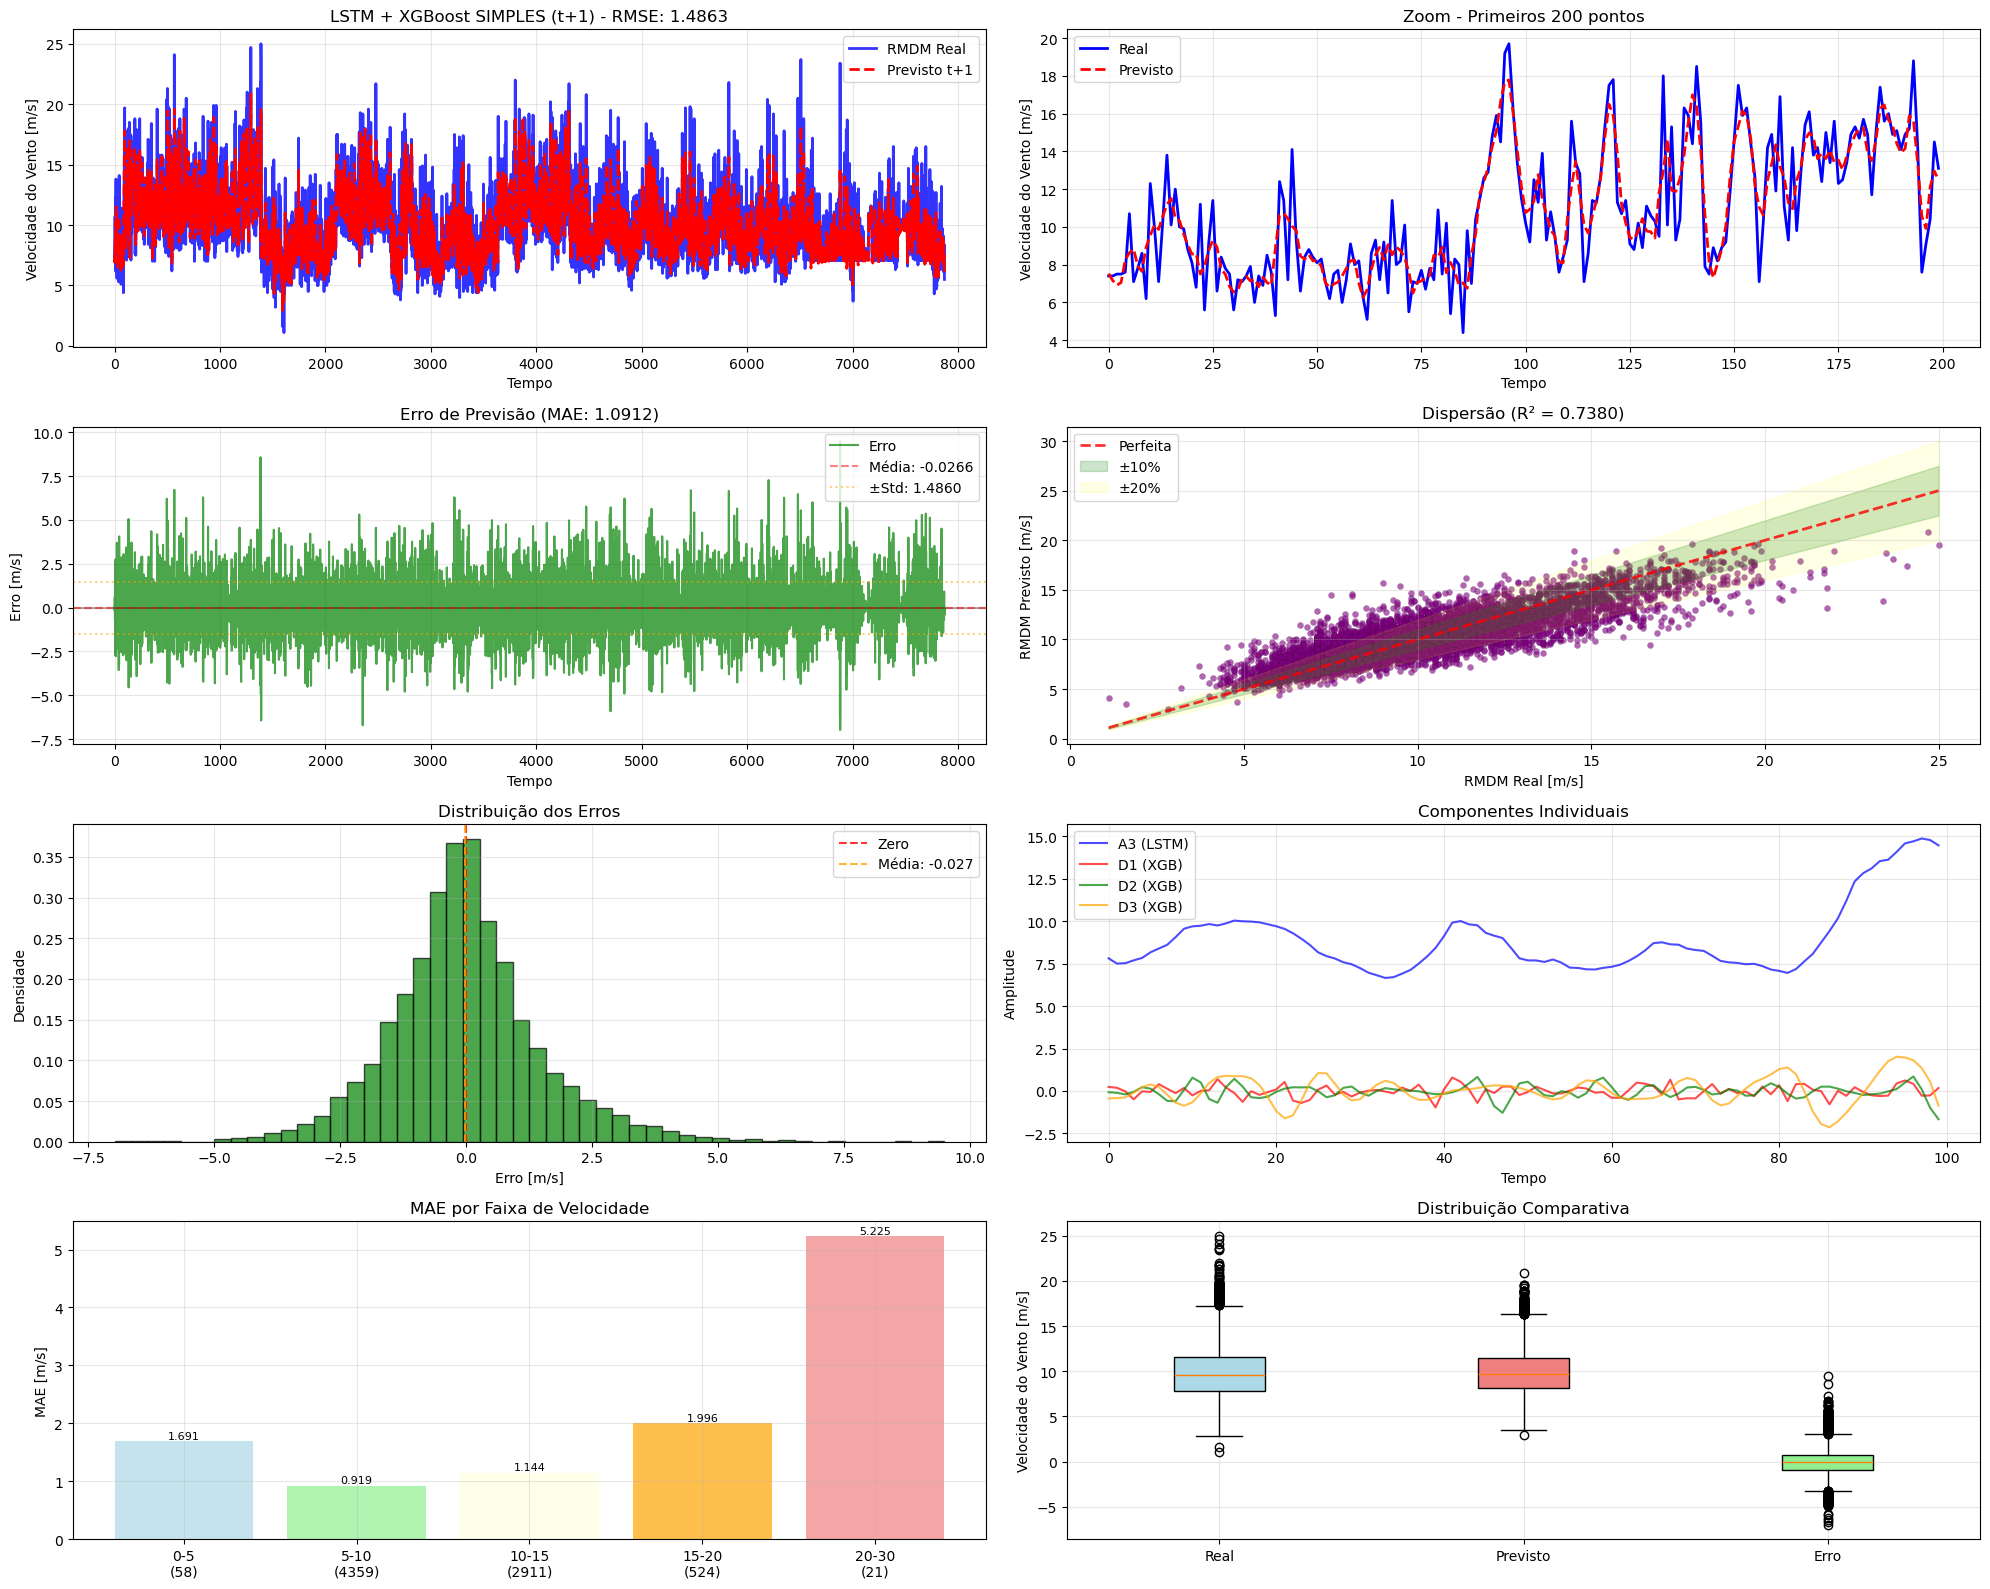


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.990 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 2.944 | Max: 20.834
      Média: 10.016 | Std: 2.426
      Q25: 8.191 | Q75: 11.430
   ❌ ERROS:
      Erro médio: -0.0266
      Std erro: 1.4860
      Max erro absoluto: 9.4956
   🔗 CORRELAÇÃO: 0.8595
   ⚖️ TENDÊNCIA: sem viés significativo

📊 RESUMO t+1:
   RMSE: 1.4863
   MAE:  1.0912
   MAPE: 11.32%
   C30:  94.35%
   R²:   0.7380


In [9]:
resultado = avaliar_passo_unico_simples(1)

🚀 SISTEMA HÍBRIDO - LSTM + XGBOOST SIMPLES
🧠 A3: LSTM (sequências)
🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências, sem features)
📋 Horizontes de previsão: [1, 5, 7, 30]
🎯 Otimizar pesos: Sim
🔧 Aplicar filtros: Sim

🔵 ⚪⚪⚪ PROCESSANDO t+1 (1/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+1
   🧠 A3: LSTM (sequências) - look_back=5
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7873 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🌲 Prevendo D1 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 5
      - Dataset shape: (7873, 5)
      ✅ Compatível: 5 features
      ✅ Previsão: 7873 pontos, range=[-6.998, 5.468], std=1.1145
   🌲 Prevendo D2 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 5
      - Dataset shape: (7873, 5)
      ✅ Compatível: 5 features
      ✅ Previsão: 7873 pontos, range=[-6.397, 6.180], std=1.0268
   🌲 Prevendo D3 com XGBoost SIMPLES.

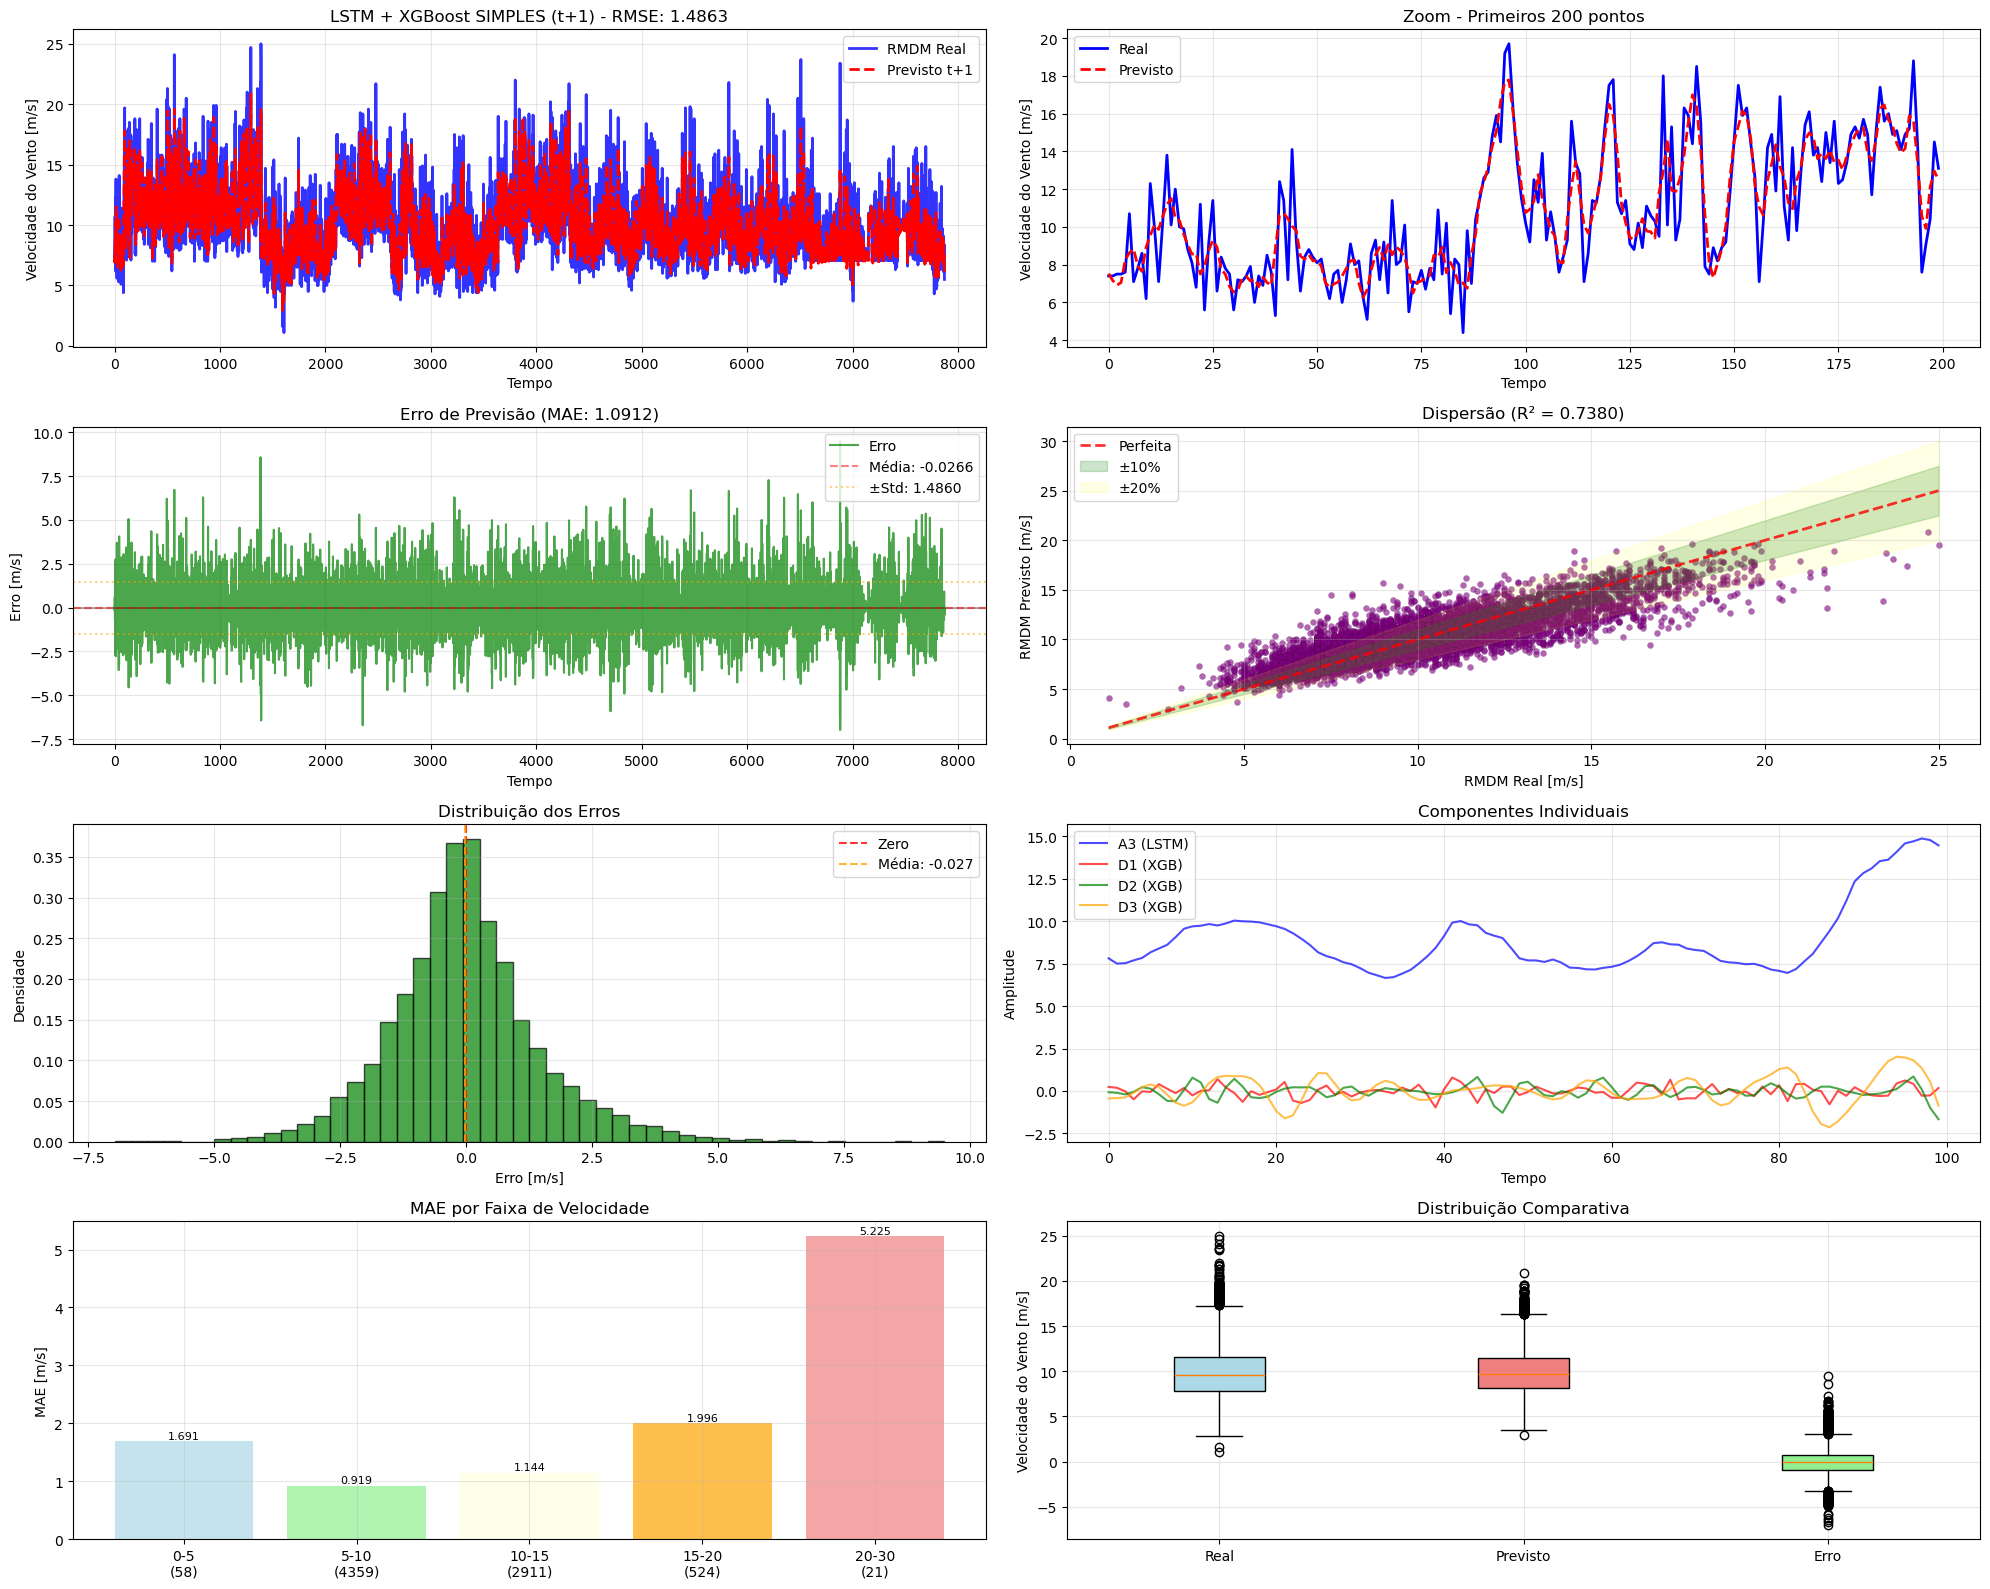


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.990 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 2.944 | Max: 20.834
      Média: 10.016 | Std: 2.426
      Q25: 8.191 | Q75: 11.430
   ❌ ERROS:
      Erro médio: -0.0266
      Std erro: 1.4860
      Max erro absoluto: 9.4956
   🔗 CORRELAÇÃO: 0.8595
   ⚖️ TENDÊNCIA: sem viés significativo
✅ t+1 CONCLUÍDO

🔵🔵 ⚪⚪ PROCESSANDO t+5 (2/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+5
   🧠 A3: LSTM (sequências) - look_back=5
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7869 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🌲 Prevendo D1 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 5
      - Dataset shape: (7869, 5)
      ✅ Compatível: 5 features
      ✅ Previsão: 7869 pontos, range=[-4.816, 3.651], std=0.4032
   🌲 Prevendo D2 com XGBoost SIMPLES.

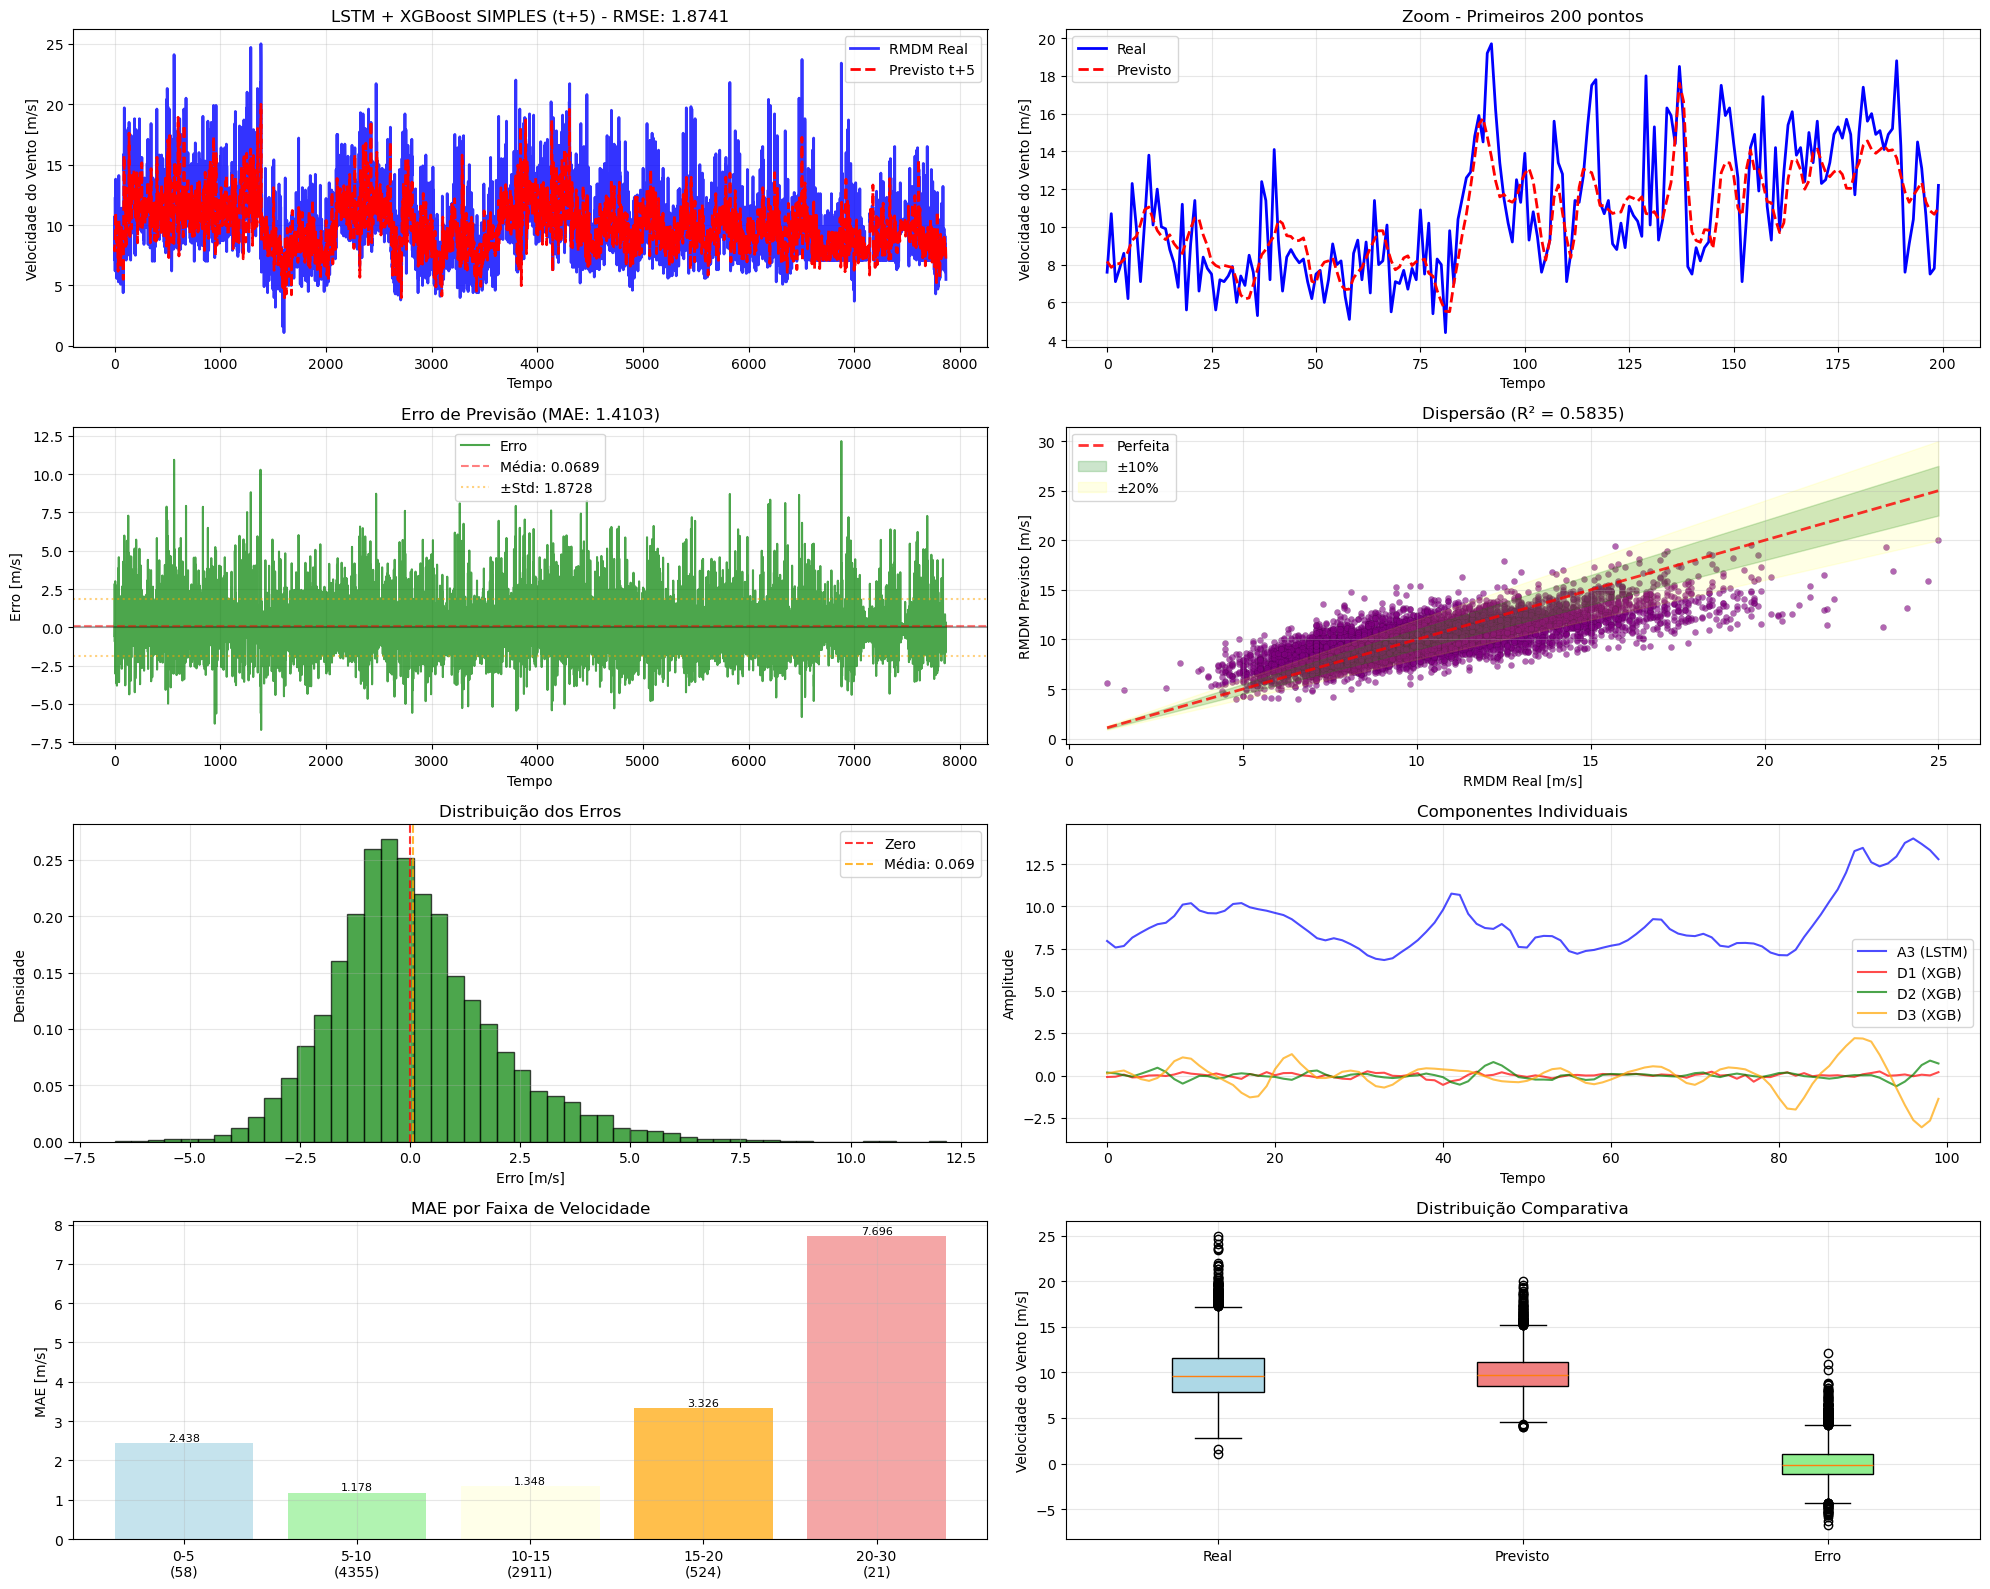


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.991 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 3.981 | Max: 19.994
      Média: 9.922 | Std: 1.998
      Q25: 8.515 | Q75: 11.191
   ❌ ERROS:
      Erro médio: 0.0689
      Std erro: 1.8728
      Max erro absoluto: 12.1637
   🔗 CORRELAÇÃO: 0.7684
   ⚖️ TENDÊNCIA: sem viés significativo
✅ t+5 CONCLUÍDO

🔵🔵🔵 ⚪ PROCESSANDO t+7 (3/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+7
   🧠 A3: LSTM (sequências) - look_back=10
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7862 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🌲 Prevendo D1 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 10
      - Dataset shape: (7862, 10)
      ✅ Compatível: 10 features
      ✅ Previsão: 7862 pontos, range=[-4.444, 3.141], std=0.4561
   🌲 Prevendo D2 com XGBoost SIMPL

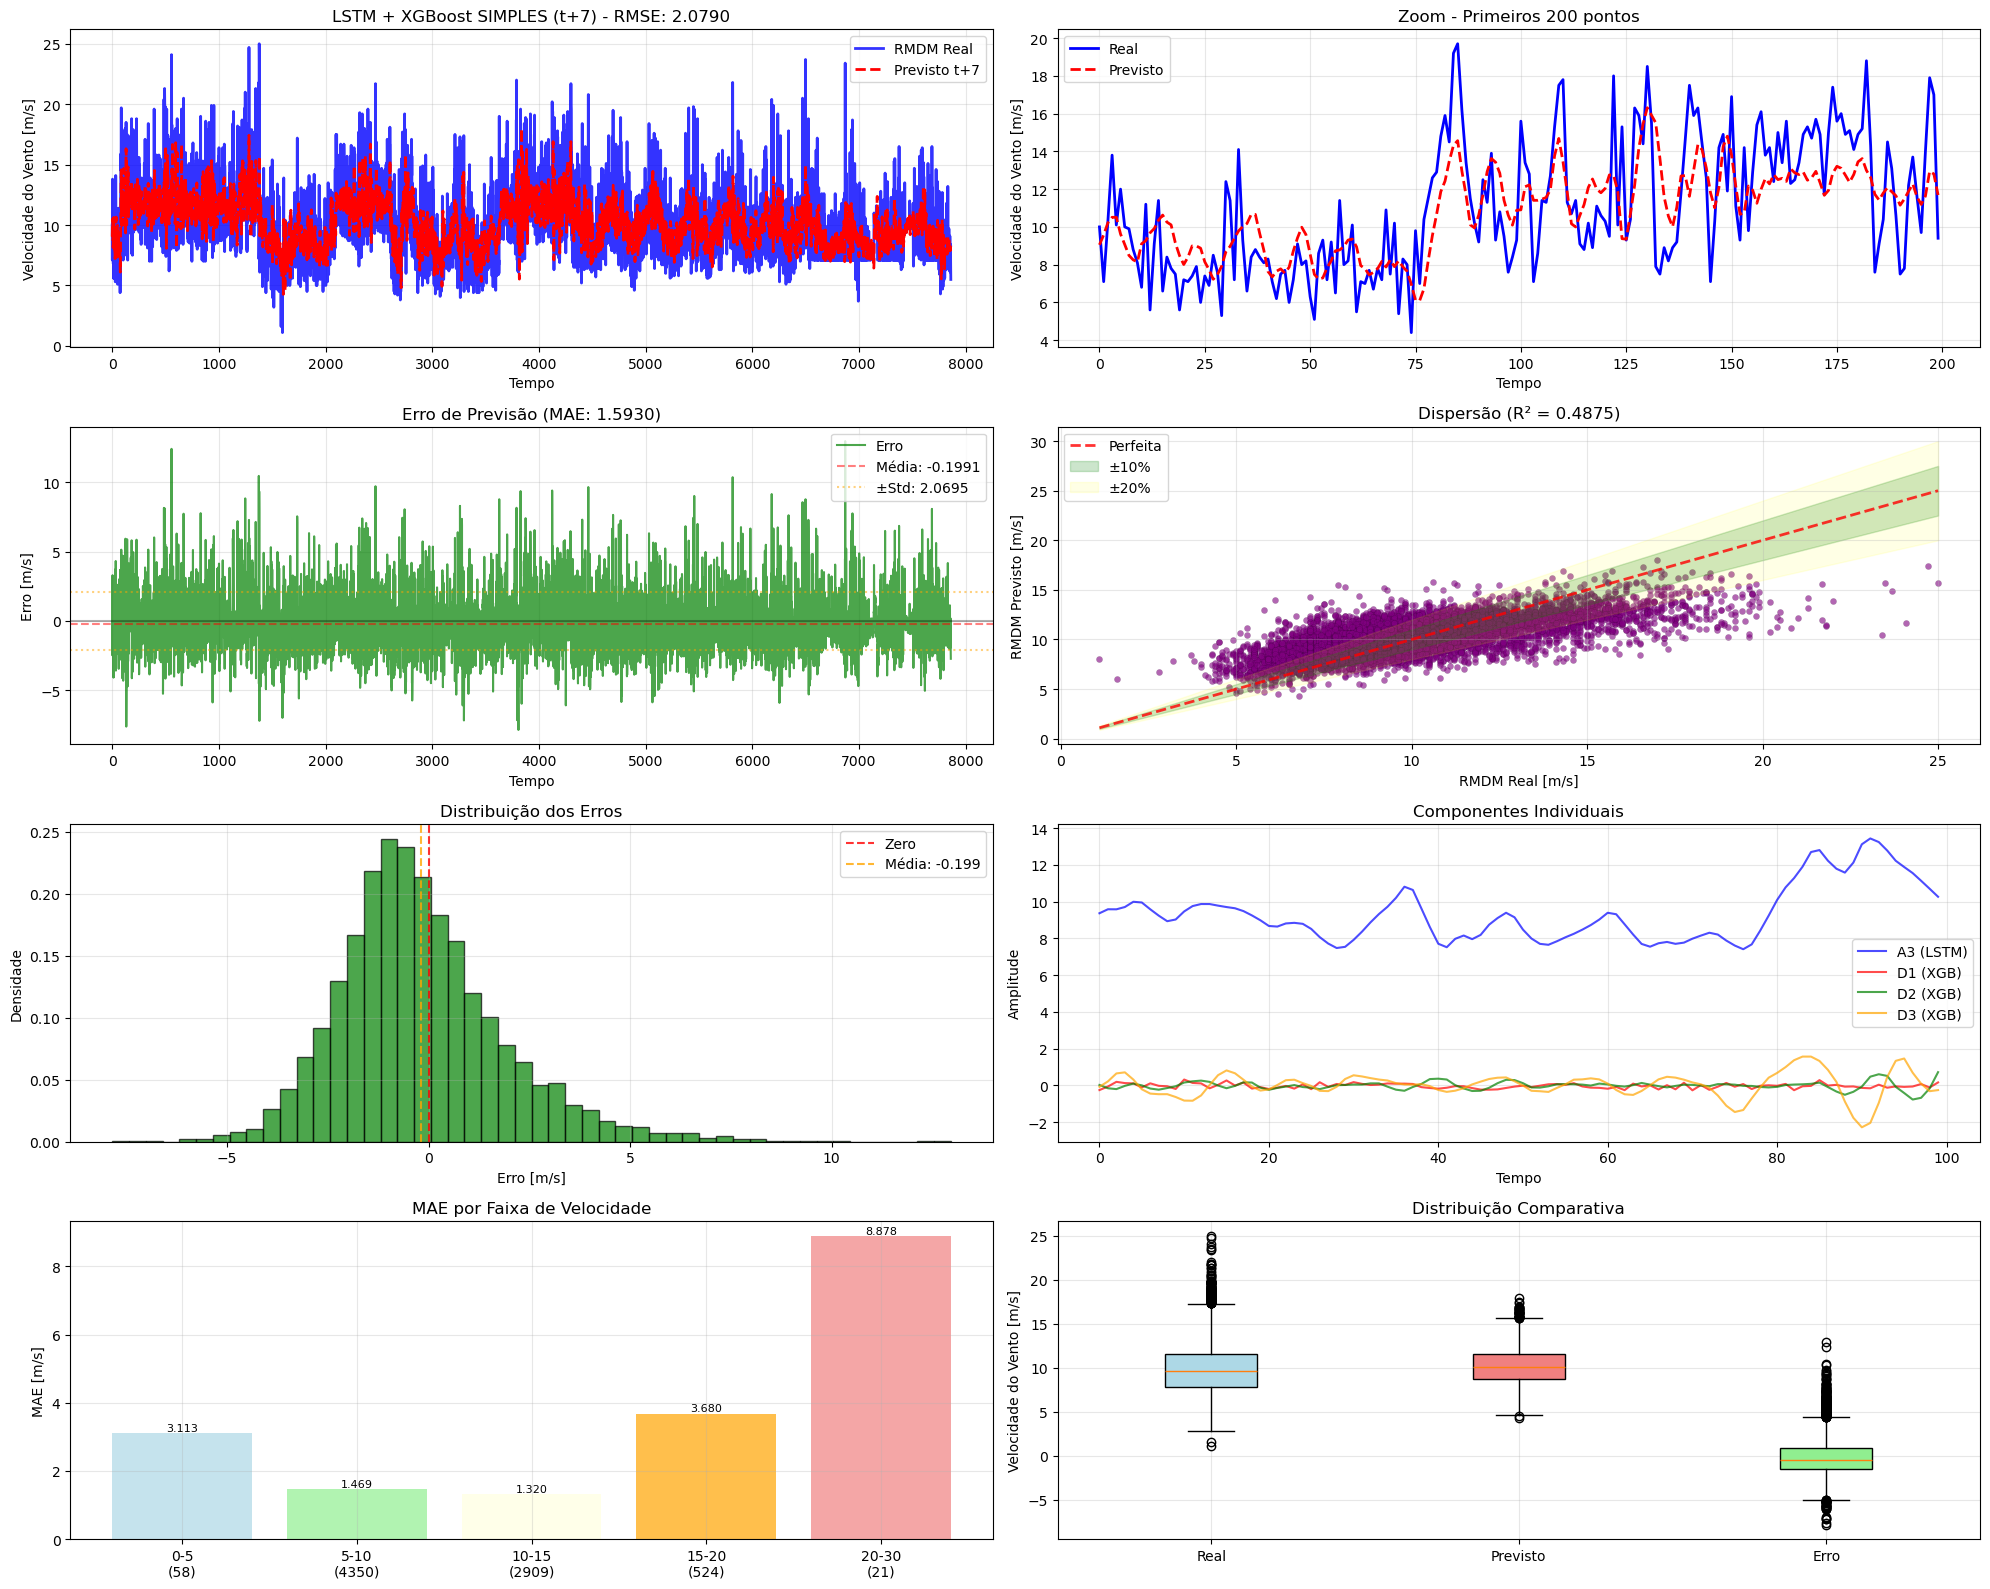


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.992 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 4.265 | Max: 17.977
      Média: 10.191 | Std: 1.853
      Q25: 8.764 | Q75: 11.516
   ❌ ERROS:
      Erro médio: -0.1991
      Std erro: 2.0695
      Max erro absoluto: 12.9533
   🔗 CORRELAÇÃO: 0.7048
   ⚖️ TENDÊNCIA: subestimação (-0.199)
✅ t+7 CONCLUÍDO

🔵🔵🔵🔵  PROCESSANDO t+30 (4/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+30
   🧠 A3: LSTM (sequências) - look_back=10
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7839 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🌲 Prevendo D1 com XGBoost SIMPLES...
      - Scaler: RobustScaler
      - Look_back: 10
      - Dataset shape: (7839, 10)
      ✅ Compatível: 10 features
      ✅ Previsão: 7839 pontos, range=[-3.741, 3.786], std=0.4600
   🌲 Prevendo D2 com XGBoost SI

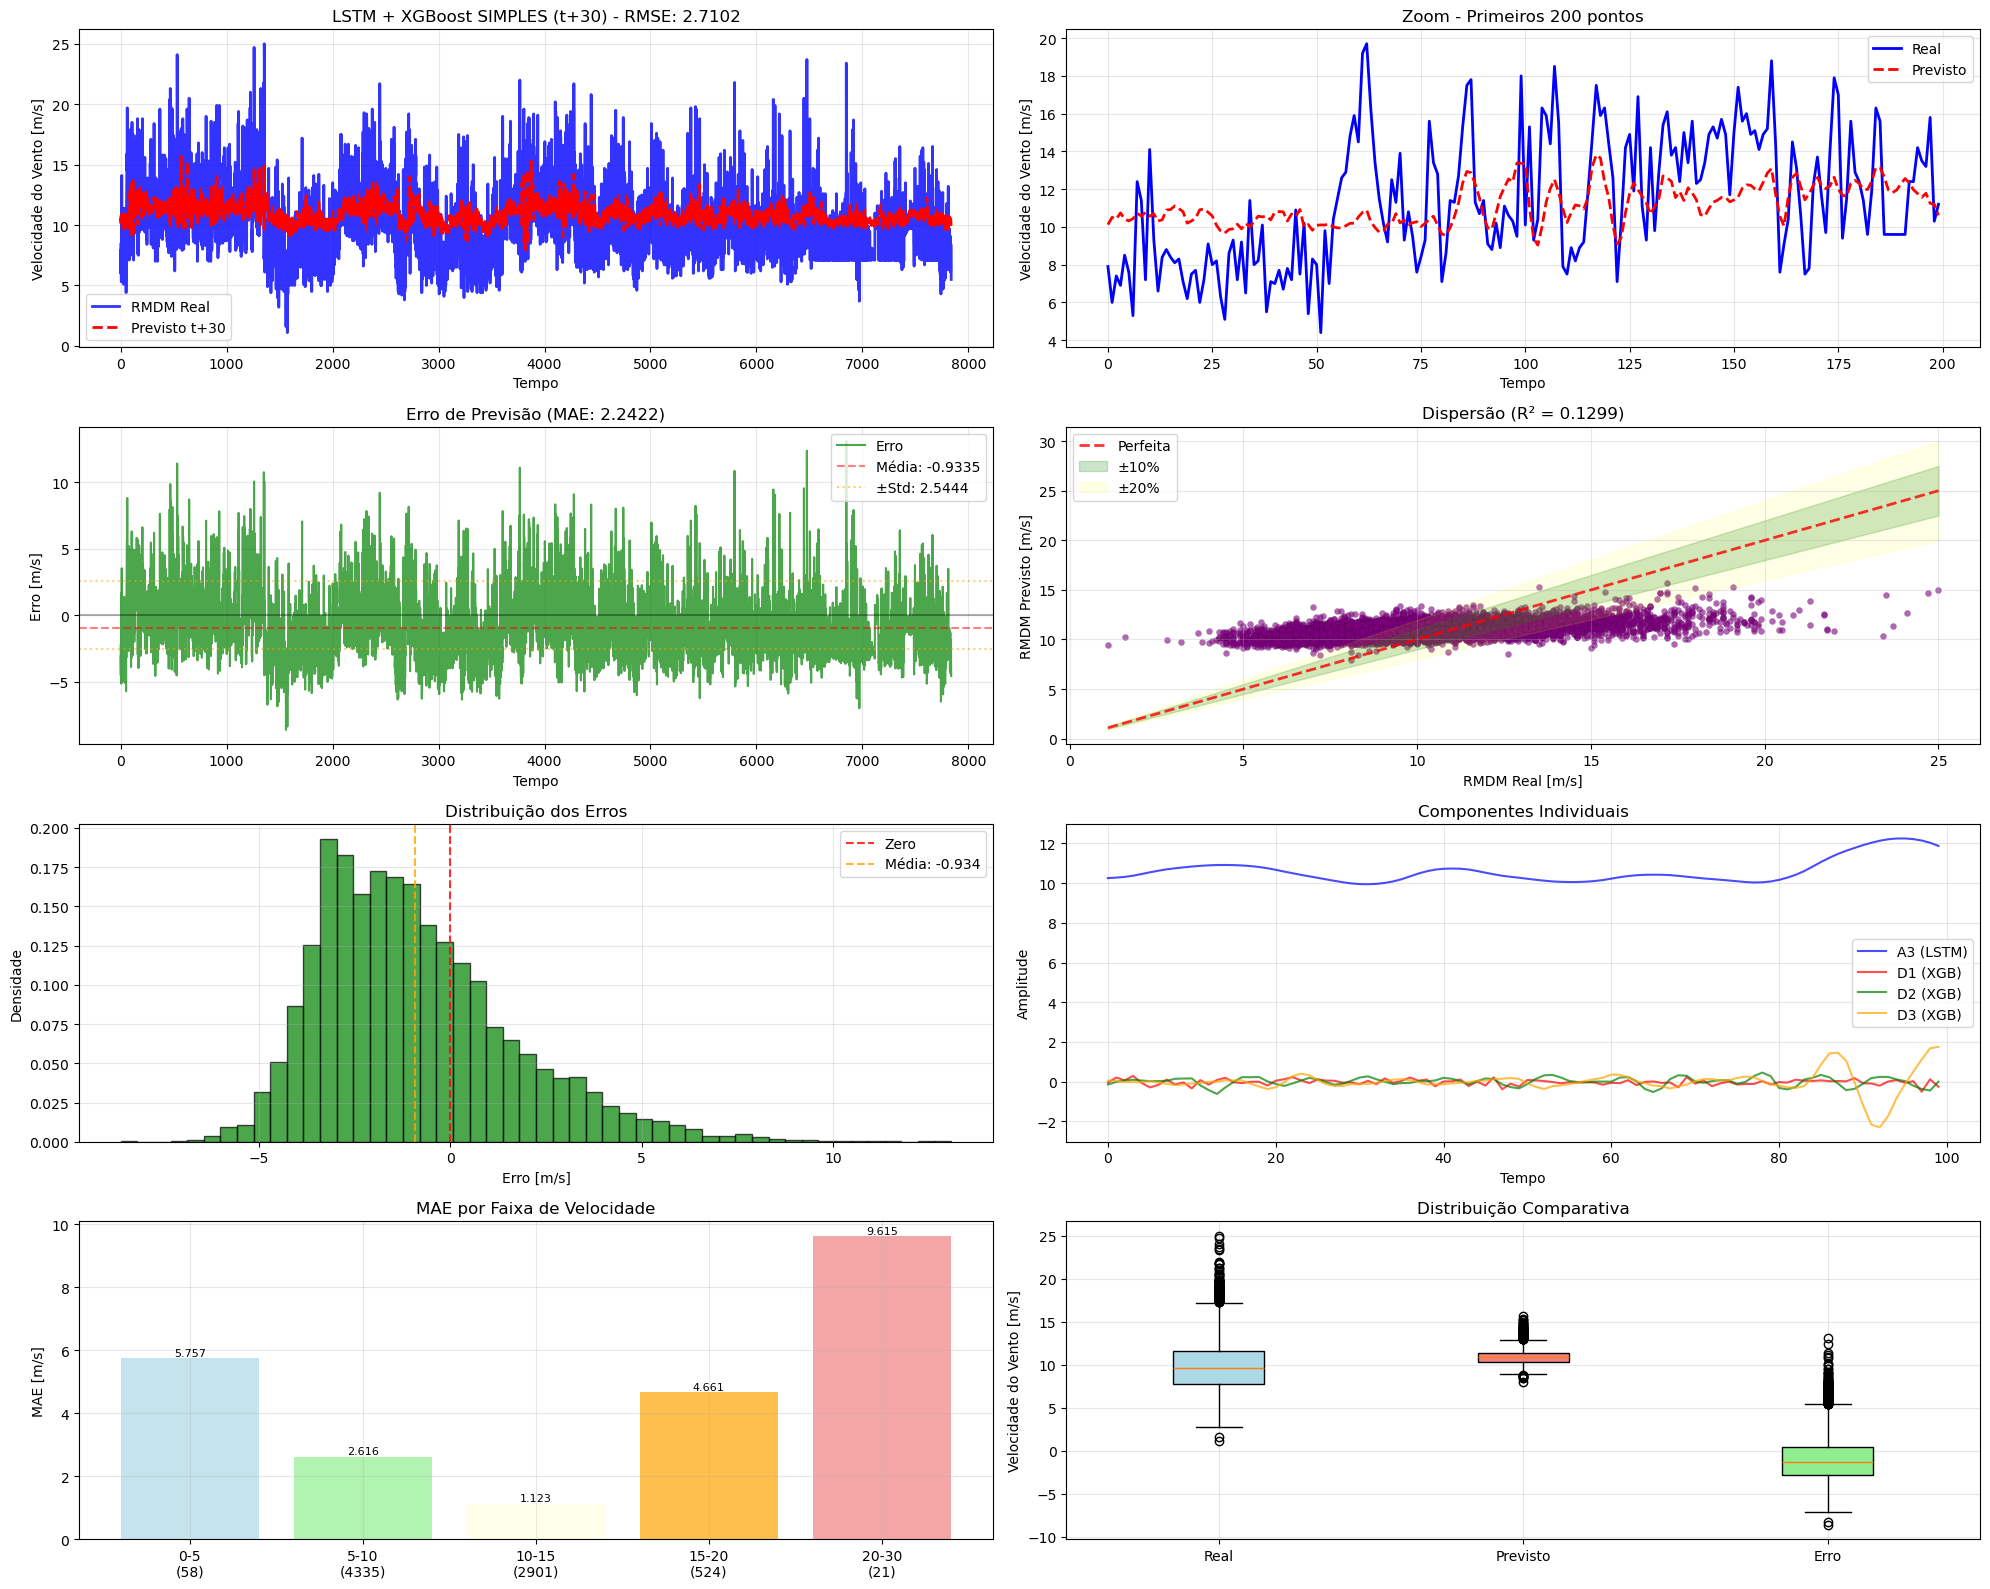


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.996 | Std: 2.906
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 7.941 | Max: 15.690
      Média: 10.929 | Std: 0.768
      Q25: 10.368 | Q75: 11.395
   ❌ ERROS:
      Erro médio: -0.9335
      Std erro: 2.5444
      Max erro absoluto: 13.0863
   🔗 CORRELAÇÃO: 0.5731
   ⚖️ TENDÊNCIA: subestimação (-0.934)
✅ t+30 CONCLUÍDO

📊 TABELA FINAL DE MÉTRICAS - LSTM + XGBoost SIMPLES
       RMSE    MAE    MAPE     C30     R2
t+1  1.4863 1.0912 11.3189 94.3478 0.7380
t+5  1.8741 1.4103 14.5686 89.4650 0.5835
t+7  2.0790 1.5930 16.9644 84.6350 0.4875
t+30 2.7102 2.2422 25.9810 66.1436 0.1299

📈 ANÁLISE ESTATÍSTICA:
----------------------------------------
 RMSE: min=1.4863, max=2.7102, média=2.0374
  MAE: min=1.0912, max=2.2422, média=1.5842
 MAPE: min=11.3189, max=25.9810, média=17.2082
  C30: min=66.1436, max=94.3478, média=83.6478
   R2: min=0.1299, max=0.7380, média=0.4847

📏 ANÁLISE 

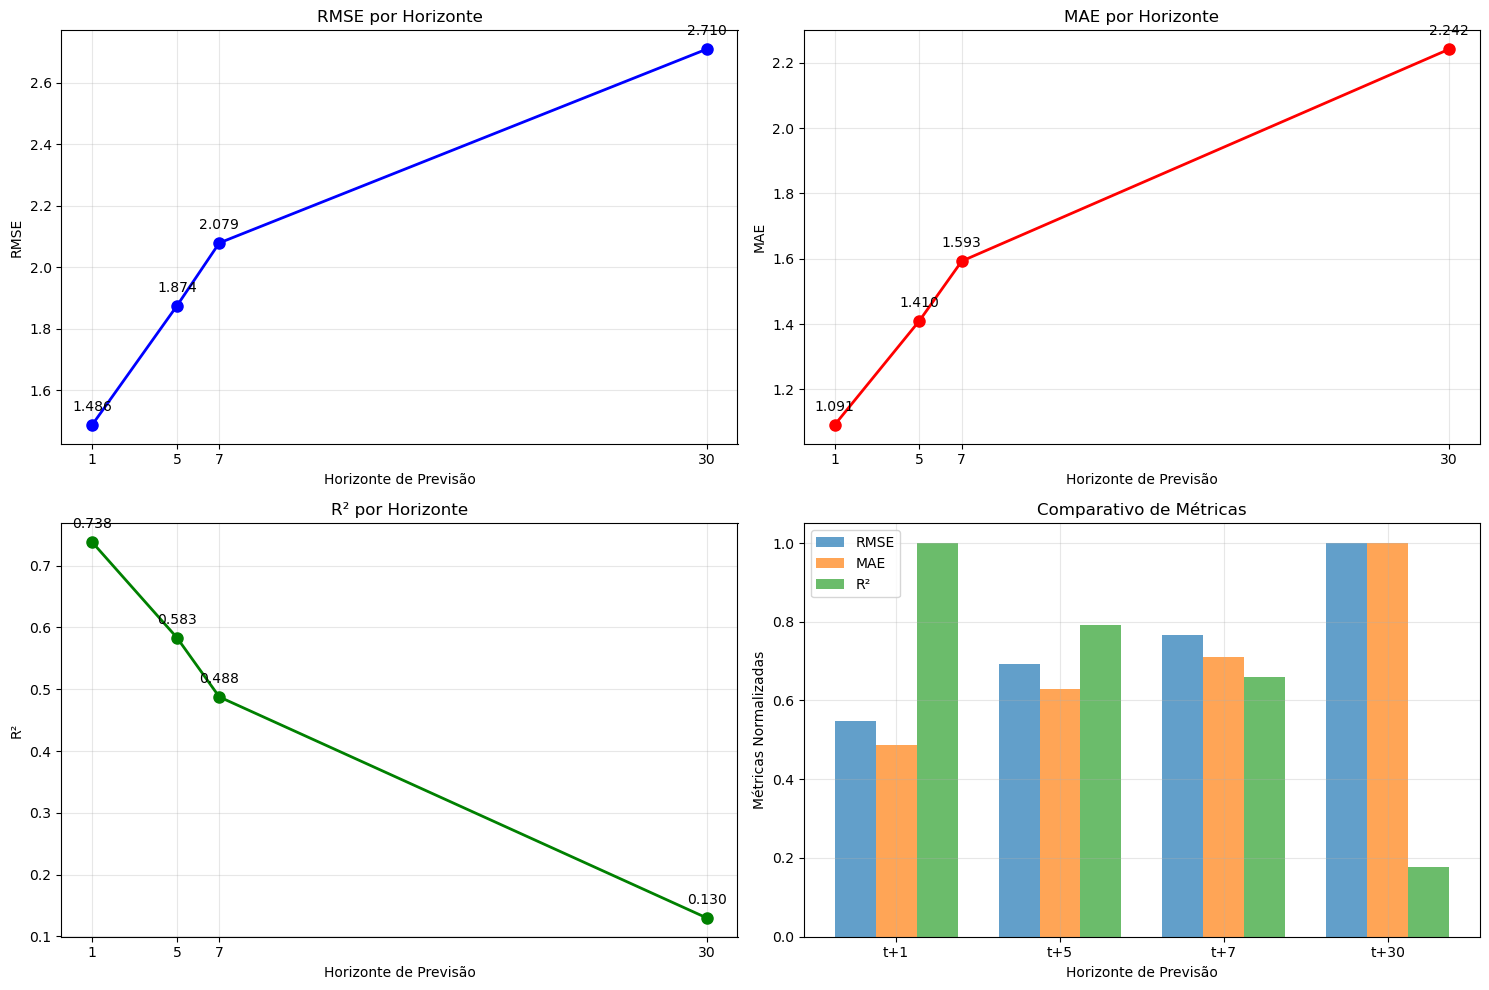


💾 SALVANDO RESULTADOS...
   ✅ Métricas salvas: resultados/metricas_lstm_xgb_simples.csv
   ✅ Análise detalhada: resultados/analise_detalhada_lstm_xgb_simples.csv
   ✅ Resumo JSON: resultados/resumo_lstm_xgb_simples.json

🎉 AVALIAÇÃO COMPLETA!


In [10]:
resultados = avaliar_sistema_completo_lstm_xgb_simples([1, 5, 7, 30])

## Gerando saídas especializadas

In [13]:
# ====================================================================
# ENSEMBLE ESPECIALIZADO - IMPLEMENTAÇÃO PRÁTICA
# ====================================================================
# Este código SUBSTITUI o treinamento XGBoost normal
# Treina 3 modelos por componente: baixos, médios, altos

import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import os
import json
from pathlib import Path

def criar_dataset_simples(series, look_back=5, passo=1):
    """Dataset simples - apenas sequências"""
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        sequencia = series[i:i + look_back]
        target = series[i + look_back + passo - 1]
        X.append(sequencia.flatten())
        y.append(target[0])
    return np.array(X), np.array(y)

def treinar_ensemble_especializado_componente(nome_comp, passo=1, test_size=0.2):
    """
    Treina ensemble especializado para um componente
    3 modelos: baixos, médios, altos + 1 modelo geral
    """
    print(f"🎯 ENSEMBLE ESPECIALIZADO - {nome_comp.upper()} t+{passo}")
    print("=" * 60)
    
    # 1. Carregar dados
    comp_file = f"{nome_comp.upper()}_component.csv"
    if not Path(comp_file).exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {comp_file}")
    
    df = pd.read_csv(comp_file)
    data = df[nome_comp.upper()].values.reshape(-1, 1)
    
    print(f"📊 Dados carregados: {len(data)} pontos")
    print(f"   Range: [{data.min():.4f}, {data.max():.4f}]")
    
    # 2. Normalização
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data)
    
    # 3. Criar dataset
    look_back = 5 if passo in [1, 5] else 10
    X, y = criar_dataset_simples(data_scaled, look_back, passo)
    
    print(f"📦 Dataset: {X.shape}, look_back={look_back}")
    
    # 4. Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=False
    )
    
    # 5. IDENTIFICAR REGIÕES (percentis na escala original)
    y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    
    p25, p50, p75 = np.percentile(y_train_original, [25, 50, 75])
    print(f"🎯 Percentis: P25={p25:.3f}, P50={p50:.3f}, P75={p75:.3f}")
    
    # Máscaras para especialistas
    baixos_mask = y_train_original <= p25
    medios_mask = (y_train_original > p25) & (y_train_original < p75)
    altos_mask = y_train_original >= p75
    
    print(f"📊 Distribuição:")
    print(f"   Baixos: {np.sum(baixos_mask)} amostras ({np.sum(baixos_mask)/len(y_train)*100:.1f}%)")
    print(f"   Médios: {np.sum(medios_mask)} amostras ({np.sum(medios_mask)/len(y_train)*100:.1f}%)")
    print(f"   Altos:  {np.sum(altos_mask)} amostras ({np.sum(altos_mask)/len(y_train)*100:.1f}%)")
    
    # 6. TREINAR MODELOS ESPECIALISTAS
    modelos = {}
    
    # Parâmetros base
    base_params = {
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # Modelo para BAIXOS (foco em depressões)
    if np.sum(baixos_mask) >= 20:  # Mínimo de amostras
        print(f"\n🔽 Treinando especialista BAIXOS...")
        modelo_baixos = xgb.XGBRegressor(
            max_depth=8,  # Mais profundo para capturar padrões raros
            learning_rate=0.05,  # Mais conservador
            n_estimators=300,  # Mais árvores
            subsample=0.9,
            colsample_bytree=0.9,
            objective='reg:absoluteerror',  # MAE para extremos
            **base_params
        )
        
        modelo_baixos.fit(X_train[baixos_mask], y_train[baixos_mask])
        
        # Avaliar
        if np.sum(baixos_mask) > 0:
            pred_baixos_train = modelo_baixos.predict(X_train[baixos_mask])
            rmse_baixos = np.sqrt(mean_squared_error(y_train[baixos_mask], pred_baixos_train))
            print(f"      RMSE treino: {rmse_baixos:.4f}")
        
        modelos['baixos'] = modelo_baixos
    else:
        print(f"⚠️ Poucos dados para especialista BAIXOS ({np.sum(baixos_mask)} amostras)")
        modelos['baixos'] = None
    
    # Modelo para ALTOS (foco em picos)
    if np.sum(altos_mask) >= 20:
        print(f"\n🔼 Treinando especialista ALTOS...")
        modelo_altos = xgb.XGBRegressor(
            max_depth=8,
            learning_rate=0.05,
            n_estimators=300,
            subsample=0.9,
            colsample_bytree=0.9,
            objective='reg:absoluteerror',
            **base_params
        )
        
        modelo_altos.fit(X_train[altos_mask], y_train[altos_mask])
        
        if np.sum(altos_mask) > 0:
            pred_altos_train = modelo_altos.predict(X_train[altos_mask])
            rmse_altos = np.sqrt(mean_squared_error(y_train[altos_mask], pred_altos_train))
            print(f"      RMSE treino: {rmse_altos:.4f}")
        
        modelos['altos'] = modelo_altos
    else:
        print(f"⚠️ Poucos dados para especialista ALTOS ({np.sum(altos_mask)} amostras)")
        modelos['altos'] = None
    
    # Modelo GERAL (baseline)
    print(f"\n⚖️ Treinando modelo GERAL...")
    modelo_geral = xgb.XGBRegressor(
        max_depth=6,  # Padrão
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',  # RMSE padrão
        **base_params
    )
    
    modelo_geral.fit(X_train, y_train)
    modelos['geral'] = modelo_geral
    
    # 7. PREVISÃO ENSEMBLE NO TESTE
    print(f"\n🔀 Fazendo previsão ensemble...")
    
    pred_geral = modelo_geral.predict(X_test)
    pred_geral_original = scaler.inverse_transform(pred_geral.reshape(-1, 1)).flatten()
    
    # Identificar regiões no teste baseado na previsão geral
    p25_test, p75_test = np.percentile(pred_geral_original, [25, 75])
    
    baixos_test_mask = pred_geral_original <= p25_test
    altos_test_mask = pred_geral_original >= p75_test
    medios_test_mask = ~(baixos_test_mask | altos_test_mask)
    
    print(f"📊 Distribuição no teste:")
    print(f"   Baixos: {np.sum(baixos_test_mask)} ({np.sum(baixos_test_mask)/len(pred_geral)*100:.1f}%)")
    print(f"   Médios: {np.sum(medios_test_mask)} ({np.sum(medios_test_mask)/len(pred_geral)*100:.1f}%)")
    print(f"   Altos:  {np.sum(altos_test_mask)} ({np.sum(altos_test_mask)/len(pred_geral)*100:.1f}%)")
    
    # Previsão final combinada
    pred_final = pred_geral.copy()
    
    # Aplicar especialista BAIXOS
    if modelos['baixos'] is not None and np.sum(baixos_test_mask) > 0:
        pred_baixos = modelos['baixos'].predict(X_test[baixos_test_mask])
        # Combinar: 60% geral + 40% especialista
        pred_final[baixos_test_mask] = 0.6 * pred_final[baixos_test_mask] + 0.4 * pred_baixos
        print(f"   ✅ Aplicado especialista BAIXOS em {np.sum(baixos_test_mask)} pontos")
    
    # Aplicar especialista ALTOS
    if modelos['altos'] is not None and np.sum(altos_test_mask) > 0:
        pred_altos = modelos['altos'].predict(X_test[altos_test_mask])
        # Combinar: 60% geral + 40% especialista
        pred_final[altos_test_mask] = 0.6 * pred_final[altos_test_mask] + 0.4 * pred_altos
        print(f"   ✅ Aplicado especialista ALTOS em {np.sum(altos_test_mask)} pontos")
    
    # 8. AVALIAÇÃO
    print(f"\n📊 AVALIAÇÃO:")
    
    # Desnormalizar para métricas
    pred_geral_real = scaler.inverse_transform(pred_geral.reshape(-1, 1)).flatten()
    pred_final_real = scaler.inverse_transform(pred_final.reshape(-1, 1)).flatten()
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Métricas modelo geral
    rmse_geral = np.sqrt(mean_squared_error(y_test_real, pred_geral_real))
    mae_geral = mean_absolute_error(y_test_real, pred_geral_real)
    
    # Métricas ensemble
    rmse_ensemble = np.sqrt(mean_squared_error(y_test_real, pred_final_real))
    mae_ensemble = mean_absolute_error(y_test_real, pred_final_real)
    
    print(f"   🔘 Modelo GERAL:")
    print(f"      RMSE: {rmse_geral:.4f} | MAE: {mae_geral:.4f}")
    print(f"   🎯 ENSEMBLE:")
    print(f"      RMSE: {rmse_ensemble:.4f} | MAE: {mae_ensemble:.4f}")
    
    # Melhoria
    melhoria_rmse = ((rmse_geral - rmse_ensemble) / rmse_geral) * 100
    melhoria_mae = ((mae_geral - mae_ensemble) / mae_geral) * 100
    
    print(f"   🚀 MELHORIA:")
    print(f"      RMSE: {melhoria_rmse:+.2f}% | MAE: {melhoria_mae:+.2f}%")
    
    # 9. SALVAR MODELOS
    print(f"\n💾 Salvando modelos...")
    
    os.makedirs("modelosXGB_ensemble", exist_ok=True)
    os.makedirs("scalersXGB", exist_ok=True)
    os.makedirs("configsXGB", exist_ok=True)
    
    # Salvar ensemble completo
    ensemble_data = {
        'modelos': modelos,
        'scaler': scaler,
        'percentis_treino': {'p25': p25, 'p50': p50, 'p75': p75},
        'pesos_combinacao': {'geral': 0.6, 'especialista': 0.4}
    }
    
    ensemble_path = f"modelosXGB_ensemble/ensemble_{nome_comp.lower()}_t{passo}.joblib"
    joblib.dump(ensemble_data, ensemble_path)
    
    # Salvar scaler (compatibilidade)
    scaler_path = f"scalersXGB/scaler_{nome_comp.lower()}_t{passo}.joblib"
    joblib.dump(scaler, scaler_path)
    
    # Salvar config
    config = {
        'componente': nome_comp.upper(),
        'passo': passo,
        'tipo': 'ensemble_especializado',
        'look_back': look_back,
        'n_features_total': X.shape[1],
        'modelos_treinados': list(modelos.keys()),
        'performance': {
            'rmse_geral': float(rmse_geral),
            'mae_geral': float(mae_geral),
            'rmse_ensemble': float(rmse_ensemble),
            'mae_ensemble': float(mae_ensemble),
            'melhoria_rmse_pct': float(melhoria_rmse),
            'melhoria_mae_pct': float(melhoria_mae)
        }
    }
    
    config_path = f"configsXGB/config_{nome_comp.lower()}_t{passo}.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"   ✅ Ensemble salvo: {ensemble_path}")
    print(f"   ✅ Config salva: {config_path}")
    
    return ensemble_data

def treinar_ensembles_completo_todos_horizontes(componentes=['d1', 'd2', 'd3'], passos=[1, 5, 7, 30]):
    """
    FUNÇÃO PRINCIPAL: Treina ensembles especializados para TODOS os componentes e horizontes
    Esta é a função que você deve chamar para treinar tudo
    """
    print("🚀 TREINAMENTO COMPLETO - ENSEMBLES PARA TODOS OS HORIZONTES")
    print("=" * 80)
    print(f"📋 Componentes: {componentes}")
    print(f"🎯 Horizontes: {passos}")
    print(f"🔢 Total de ensembles: {len(componentes)} × {len(passos)} = {len(componentes) * len(passos)}")
    print("=" * 80)
    
    import time
    inicio_total = time.time()
    
    resultados_completos = {}
    sucessos = 0
    falhas = 0
    
    for i, comp in enumerate(componentes):
        print(f"\n{'🔵' * (i+1)} {'⚪' * (len(componentes)-i-1)} COMPONENTE {comp.upper()} ({i+1}/{len(componentes)})")
        print("=" * 60)
        
        resultados_completos[comp] = {}
        
        for j, passo in enumerate(passos):
            print(f"\n   {'🟢' * (j+1)} {'⚪' * (len(passos)-j-1)} Horizonte t+{passo} ({j+1}/{len(passos)})")
            print("   " + "-" * 50)
            
            inicio_modelo = time.time()
            
            try:
                # Treinar ensemble para este componente e horizonte
                ensemble_data = treinar_ensemble_especializado_componente(comp, passo)
                
                # Carregar métricas salvas
                config_path = f"configsXGB/config_{comp}_t{passo}.json"
                with open(config_path, 'r') as f:
                    config = json.load(f)
                
                # Salvar resultado
                resultados_completos[comp][f't+{passo}'] = {
                    'status': 'sucesso',
                    'performance': config['performance'],
                    'tempo_treinamento': time.time() - inicio_modelo
                }
                
                melhoria_rmse = config['performance']['melhoria_rmse_pct']
                melhoria_mae = config['performance']['melhoria_mae_pct']
                
                print(f"      ✅ {comp.upper()} t+{passo} - SUCESSO!")
                print(f"         Melhoria RMSE: {melhoria_rmse:+.2f}% | MAE: {melhoria_mae:+.2f}%")
                print(f"         Tempo: {time.time() - inicio_modelo:.1f}s")
                
                sucessos += 1
                
            except Exception as e:
                print(f"      ❌ {comp.upper()} t+{passo} - ERRO: {e}")
                
                resultados_completos[comp][f't+{passo}'] = {
                    'status': 'erro',
                    'erro': str(e),
                    'tempo_treinamento': time.time() - inicio_modelo
                }
                
                falhas += 1
                
            # Progresso geral
            total_atual = i * len(passos) + j + 1
            total_geral = len(componentes) * len(passos)
            progresso = (total_atual / total_geral) * 100
            tempo_decorrido = time.time() - inicio_total
            tempo_estimado = (tempo_decorrido / total_atual) * total_geral
            tempo_restante = tempo_estimado - tempo_decorrido
            
            print(f"      📊 Progresso geral: {total_atual}/{total_geral} ({progresso:.1f}%)")
            print(f"      ⏱️ Tempo restante estimado: {tempo_restante/60:.1f} minutos")
    
    # =============================================================================
    # RESUMO FINAL COMPLETO
    # =============================================================================
    tempo_total = time.time() - inicio_total
    
    print(f"\n{'=' * 80}")
    print("🎉 TREINAMENTO COMPLETO FINALIZADO!")
    print("=" * 80)
    
    print(f"⏱️ TEMPO TOTAL: {tempo_total/60:.1f} minutos ({tempo_total:.1f}s)")
    print(f"📊 RESULTADOS: {sucessos} sucessos, {falhas} falhas")
    print(f"📈 Taxa de sucesso: {(sucessos/(sucessos+falhas)*100):.1f}%")
    
    # Tabela detalhada de resultados
    print(f"\n📋 TABELA DETALHADA DE MELHORIAS:")
    print("-" * 80)
    print(f"{'Componente':<12} {'Horizonte':<10} {'RMSE Melhoria':<15} {'MAE Melhoria':<15} {'Status':<10}")
    print("-" * 80)
    
    melhorias_rmse_todas = []
    melhorias_mae_todas = []
    
    for comp in componentes:
        for passo in passos:
            key = f't+{passo}'
            resultado = resultados_completos[comp][key]
            
            if resultado['status'] == 'sucesso':
                perf = resultado['performance']
                rmse_melhoria = perf['melhoria_rmse_pct']
                mae_melhoria = perf['melhoria_mae_pct']
                
                print(f"{comp.upper():<12} {key:<10} {rmse_melhoria:+.2f}%{'':<10} {mae_melhoria:+.2f}%{'':<10} {'✅ OK':<10}")
                
                melhorias_rmse_todas.append(rmse_melhoria)
                melhorias_mae_todas.append(mae_melhoria)
            else:
                print(f"{comp.upper():<12} {key:<10} {'N/A':<15} {'N/A':<15} {'❌ ERRO':<10}")
    
    # Estatísticas finais
    if melhorias_rmse_todas:
        print(f"\n📈 ESTATÍSTICAS FINAIS DAS MELHORIAS:")
        print(f"   RMSE:")
        print(f"      Média: {np.mean(melhorias_rmse_todas):+.2f}%")
        print(f"      Melhor: {max(melhorias_rmse_todas):+.2f}%")
        print(f"      Pior: {min(melhorias_rmse_todas):+.2f}%")
        print(f"      Desvio: ±{np.std(melhorias_rmse_todas):.2f}%")
        
        print(f"   MAE:")
        print(f"      Média: {np.mean(melhorias_mae_todas):+.2f}%")
        print(f"      Melhor: {max(melhorias_mae_todas):+.2f}%")
        print(f"      Pior: {min(melhorias_mae_todas):+.2f}%")
        print(f"      Desvio: ±{np.std(melhorias_mae_todas):.2f}%")
    
    # Salvar resumo geral
    resumo_geral = {
        'data_treinamento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'tempo_total_minutos': tempo_total / 60,
        'componentes_treinados': componentes,
        'horizontes_treinados': passos,
        'total_modelos': len(componentes) * len(passos),
        'sucessos': sucessos,
        'falhas': falhas,
        'taxa_sucesso_pct': (sucessos/(sucessos+falhas)*100) if (sucessos+falhas) > 0 else 0,
        'estatisticas_melhorias': {
            'rmse_media': float(np.mean(melhorias_rmse_todas)) if melhorias_rmse_todas else None,
            'rmse_melhor': float(max(melhorias_rmse_todas)) if melhorias_rmse_todas else None,
            'mae_media': float(np.mean(melhorias_mae_todas)) if melhorias_mae_todas else None,
            'mae_melhor': float(max(melhorias_mae_todas)) if melhorias_mae_todas else None
        },
        'resultados_detalhados': resultados_completos
    }
    
    os.makedirs("resultados", exist_ok=True)
    resumo_path = "resultados/resumo_ensembles_completo.json"
    with open(resumo_path, 'w', encoding='utf-8') as f:
        json.dump(resumo_geral, f, indent=2, ensure_ascii=False)
    
    print(f"\n💾 Resumo completo salvo: {resumo_path}")
    
    # Instruções finais
    print(f"\n🎯 PRÓXIMOS PASSOS:")
    print(f"1. Use o código de avaliação normalmente")
    print(f"2. Ele detectará automaticamente os ensembles")
    print(f"3. Compare os resultados com versão anterior")
    print(f"4. Arquivos salvos em:")
    print(f"   📁 modelosXGB_ensemble/ - Modelos ensemble")
    print(f"   📁 configsXGB/ - Configurações")
    print(f"   📁 resultados/ - Resumos e análises")
    
    if falhas > 0:
        print(f"\n⚠️ ATENÇÃO: {falhas} modelos falharam. Verifique os logs acima.")
    else:
        print(f"\n🎉 TODOS OS ENSEMBLES TREINADOS COM SUCESSO!")
    
    return resumo_geral

# Função wrapper mais simples para uso direto
def treinar_todos_ensembles_rapido():
    """
    Função RÁPIDA para treinar tudo com configurações padrão
    """
    return treinar_ensembles_completo_todos_horizontes(['d1', 'd2', 'd3'], [1, 5, 7, 30])

# Interface atualizada
print("🎯 ENSEMBLE ESPECIALIZADO - TREINAMENTO COMPLETO")
print("=" * 70)
print("📋 FUNÇÕES PRINCIPAIS:")
print()
print("🔹 treinar_todos_ensembles_rapido()")
print("   → Treina TODOS os ensembles (D1,D2,D3 para t+1,5,7,30)")
print("   → Função MAIS SIMPLES para usar")
print()
print("🔹 treinar_ensembles_completo_todos_horizontes(componentes, passos)")
print("   → Versão customizável")
print()
print("🔹 treinar_ensemble_especializado_componente('d1', 1)")
print("   → Treinar apenas um modelo específico")
print()
print("⚡ USO RECOMENDADO:")
print("   # Treinar tudo de uma vez")
print("   resumo = treinar_todos_ensembles_rapido()")
print()
print("⏱️ TEMPO ESTIMADO: 10-20 minutos para todos os modelos")
print("📈 MELHORIA ESPERADA: +2% a +10% nas métricas")
print("=" * 70)

# Interface de uso
print("🎯 ENSEMBLE ESPECIALIZADO - IMPLEMENTAÇÃO PRÁTICA")
print("=" * 60)
print("📋 FUNÇÕES DISPONÍVEIS:")
print()
print("🔹 treinar_ensemble_especializado_componente('d1', passo=1)")
print("   → Treina ensemble para um componente específico")
print()
print("🔹 treinar_todos_ensembles([1, 5, 7, 30])")
print("   → Treina ensembles para todos os componentes")
print()
print("💡 COMO USAR:")
print("   1. Execute: treinar_todos_ensembles([1, 5, 7, 30])")
print("   2. Aguarde o treinamento (5-15 minutos)")
print("   3. Use o código de avaliação normalmente")
print()
print("🎯 DIFERENÇA:")
print("   • 3 modelos por componente (baixos/médios/altos)")
print("   • Foco específico em picos e depressões")
print("   • Combinação inteligente das previsões")
print("=" * 60)

🎯 ENSEMBLE ESPECIALIZADO - TREINAMENTO COMPLETO
📋 FUNÇÕES PRINCIPAIS:

🔹 treinar_todos_ensembles_rapido()
   → Treina TODOS os ensembles (D1,D2,D3 para t+1,5,7,30)
   → Função MAIS SIMPLES para usar

🔹 treinar_ensembles_completo_todos_horizontes(componentes, passos)
   → Versão customizável

🔹 treinar_ensemble_especializado_componente('d1', 1)
   → Treinar apenas um modelo específico

⚡ USO RECOMENDADO:
   # Treinar tudo de uma vez
   resumo = treinar_todos_ensembles_rapido()

⏱️ TEMPO ESTIMADO: 10-20 minutos para todos os modelos
📈 MELHORIA ESPERADA: +2% a +10% nas métricas
🎯 ENSEMBLE ESPECIALIZADO - IMPLEMENTAÇÃO PRÁTICA
📋 FUNÇÕES DISPONÍVEIS:

🔹 treinar_ensemble_especializado_componente('d1', passo=1)
   → Treina ensemble para um componente específico

🔹 treinar_todos_ensembles([1, 5, 7, 30])
   → Treina ensembles para todos os componentes

💡 COMO USAR:
   1. Execute: treinar_todos_ensembles([1, 5, 7, 30])
   2. Aguarde o treinamento (5-15 minutos)
   3. Use o código de avaliação no

In [14]:
# Treina TODOS os ensembles de uma vez (D1,D2,D3 para t+1,5,7,30)
resumo = treinar_todos_ensembles_rapido()

🚀 TREINAMENTO COMPLETO - ENSEMBLES PARA TODOS OS HORIZONTES
📋 Componentes: ['d1', 'd2', 'd3']
🎯 Horizontes: [1, 5, 7, 30]
🔢 Total de ensembles: 3 × 4 = 12

🔵 ⚪⚪ COMPONENTE D1 (1/3)

   🟢 ⚪⚪⚪ Horizonte t+1 (1/4)
   --------------------------------------------------
🎯 ENSEMBLE ESPECIALIZADO - D1 t+1
📊 Dados carregados: 7878 pontos
   Range: [-7.7183, 8.8608]
📦 Dataset: (7873, 5), look_back=5
🎯 Percentis: P25=-0.755, P50=-0.021, P75=0.748
📊 Distribuição:
   Baixos: 1575 amostras (25.0%)
   Médios: 3148 amostras (50.0%)
   Altos:  1575 amostras (25.0%)

🔽 Treinando especialista BAIXOS...


      RMSE treino: 0.2174

🔼 Treinando especialista ALTOS...
      RMSE treino: 0.2179

⚖️ Treinando modelo GERAL...

🔀 Fazendo previsão ensemble...
📊 Distribuição no teste:
   Baixos: 394 (25.0%)
   Médios: 787 (50.0%)
   Altos:  394 (25.0%)
   ✅ Aplicado especialista BAIXOS em 394 pontos
   ✅ Aplicado especialista ALTOS em 394 pontos

📊 AVALIAÇÃO:
   🔘 Modelo GERAL:
      RMSE: 0.6245 | MAE: 0.3948
   🎯 ENSEMBLE:
      RMSE: 0.6357 | MAE: 0.4048
   🚀 MELHORIA:
      RMSE: -1.80% | MAE: -2.53%

💾 Salvando modelos...
   ✅ Ensemble salvo: modelosXGB_ensemble/ensemble_d1_t1.joblib
   ✅ Config salva: configsXGB/config_d1_t1.json
      ✅ D1 t+1 - SUCESSO!
         Melhoria RMSE: -1.80% | MAE: -2.53%
         Tempo: 7.2s
      📊 Progresso geral: 1/12 (8.3%)
      ⏱️ Tempo restante estimado: 1.3 minutos

   🟢🟢 ⚪⚪ Horizonte t+5 (2/4)
   --------------------------------------------------
🎯 ENSEMBLE ESPECIALIZADO - D1 t+5
📊 Dados carregados: 7878 pontos
   Range: [-7.7183, 8.8608]
📦 Dataset: (7

In [15]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path

def criar_dataset_multi_step(series, look_back=10, passo=1):
    """
    Dataset para LSTM - EXATAMENTE igual ao código de treinamento
    """
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])  # Sem flatten aqui
        y.append(series[i+look_back+passo-1])  # EXATO como no treinamento
    return np.array(X), np.array(y)

def criar_dataset_xgb_simples(series, look_back=5, passo=1):
    """
    Dataset XGBoost SIMPLES - alinhado com LSTM
    """
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        sequencia = series[i:i+look_back].flatten()  # Flatten para XGBoost
        target = series[i+look_back+passo-1]  # MESMO alinhamento que LSTM
        X.append(sequencia)
        y.append(target[0] if hasattr(target, '__len__') else target)
    return np.array(X), np.array(y)

def calcular_metricas(y_true, y_pred):
    """Calcular métricas de avaliação"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    
    # Métricas adicionais
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'RMSE': rmse,
        'MAE': mae, 
        'MAPE': mape,
        'C30': c30,
        'R2': r2
    }

def obter_look_back_correto(passo):
    """
    Retorna o look_back correto baseado no passo de previsão
    - t+1 e t+5: look_back = 5
    - demais: look_back = 10
    """
    if passo in [1, 5]:
        return 5
    else:
        return 10

def prever_componente_automatico(nome_comp, passo):
    """
    Função AUTOMÁTICA que escolhe entre ensemble ou modelo simples
    DETECTA automaticamente se ensemble existe e usa o melhor disponível
    """
    # Verificar se ensemble existe
    ensemble_path = Path(f"modelosXGB_ensemble/ensemble_{nome_comp.lower()}_t{passo}.joblib")
    
    if ensemble_path.exists():
        # Usar ENSEMBLE ESPECIALIZADO
        return prever_componente_ensemble(nome_comp, passo)
    else:
        # Usar modelo simples como fallback
        return prever_componente_xgb_simples(nome_comp, passo)

def prever_componente_ensemble(nome_comp, passo):
    """
    Previsão usando ENSEMBLE ESPECIALIZADO
    """
    print(f"   🎯 Prevendo {nome_comp.upper()} com ENSEMBLE ESPECIALIZADO...")
    
    ensemble_path = Path(f"modelosXGB_ensemble/ensemble_{nome_comp.lower()}_t{passo}.joblib")
    
    # Carregar ensemble
    try:
        ensemble_data = joblib.load(ensemble_path)
        modelos = ensemble_data['modelos']
        scaler = ensemble_data['scaler']
        percentis = ensemble_data['percentis_treino']
        pesos = ensemble_data['pesos_combinacao']
        
        print(f"      ✅ Ensemble carregado: {list(modelos.keys())}")
        
    except Exception as e:
        print(f"      ❌ Erro ao carregar ensemble: {e}")
        # Fallback para modelo simples
        return prever_componente_xgb_simples(nome_comp, passo)
    
    # Look_back baseado na regra
    look_back_xgb = obter_look_back_correto(passo)
    
    # Carregar dados
    serie_path = Path(f"{nome_comp.upper()}_component.csv")
    if not serie_path.exists():
        raise FileNotFoundError(f"Arquivo {serie_path} não encontrado")
    
    serie = pd.read_csv(serie_path)[nome_comp.upper()].values.reshape(-1, 1)
    serie_scaled = scaler.transform(serie)
    
    print(f"      - Look_back: {look_back_xgb}")
    
    # Criar dataset
    X, _ = criar_dataset_xgb_simples(serie_scaled, look_back_xgb, passo)
    print(f"      - Dataset shape: {X.shape}")
    
    # PREVISÃO ENSEMBLE
    try:
        # 1. Previsão com modelo geral
        pred_geral = modelos['geral'].predict(X)
        pred_geral_original = scaler.inverse_transform(pred_geral.reshape(-1, 1)).flatten()
        
        print(f"      - Previsão geral: range=[{pred_geral_original.min():.3f}, {pred_geral_original.max():.3f}]")
        
        # 2. Identificar regiões baseado nos percentis de treinamento
        p25, p75 = percentis['p25'], percentis['p75']
        
        baixos_mask = pred_geral_original <= p25
        altos_mask = pred_geral_original >= p75
        medios_mask = ~(baixos_mask | altos_mask)
        
        print(f"      - Distribuição: {np.sum(baixos_mask)} baixos, {np.sum(medios_mask)} médios, {np.sum(altos_mask)} altos")
        
        # 3. Previsão final (iniciar com modelo geral)
        pred_final = pred_geral.copy()
        
        # 4. Aplicar especialistas onde apropriado
        peso_geral = pesos['geral']
        peso_especialista = pesos['especialista']
        
        # Especialista BAIXOS
        if modelos['baixos'] is not None and np.sum(baixos_mask) > 0:
            pred_baixos = modelos['baixos'].predict(X[baixos_mask])
            pred_final[baixos_mask] = (peso_geral * pred_final[baixos_mask] + 
                                     peso_especialista * pred_baixos)
            print(f"      ✅ Aplicado especialista BAIXOS em {np.sum(baixos_mask)} pontos")
        
        # Especialista ALTOS
        if modelos['altos'] is not None and np.sum(altos_mask) > 0:
            pred_altos = modelos['altos'].predict(X[altos_mask])
            pred_final[altos_mask] = (peso_geral * pred_final[altos_mask] + 
                                    peso_especialista * pred_altos)
            print(f"      ✅ Aplicado especialista ALTOS em {np.sum(altos_mask)} pontos")
        
        # 5. Desnormalizar resultado final
        y_pred = scaler.inverse_transform(pred_final.reshape(-1, 1)).flatten()
        
        print(f"      ✅ Previsão ensemble: {len(y_pred)} pontos, range=[{y_pred.min():.3f}, {y_pred.max():.3f}], std={np.std(y_pred):.4f}")
        
        return y_pred
        
    except Exception as e:
        print(f"      ❌ Erro na previsão ensemble: {e}")
        # Fallback para modelo geral apenas
        pred_geral = modelos['geral'].predict(X)
        y_pred = scaler.inverse_transform(pred_geral.reshape(-1, 1)).flatten()
        print(f"      🔄 Usando apenas modelo geral como fallback")
        return y_pred
    """
    Previsão XGBoost SIMPLES - ALINHADO com LSTM
    """
    print(f"   🌲 Prevendo {nome_comp.upper()} com XGBoost SIMPLES...")
    
    # Look_back baseado na regra
    look_back_xgb = obter_look_back_correto(passo)
    
    # Carregar dados
    serie_path = Path(f"{nome_comp.upper()}_component.csv")
    if not serie_path.exists():
        raise FileNotFoundError(f"Arquivo {serie_path} não encontrado")
    
    serie = pd.read_csv(serie_path)[nome_comp.upper()].values.reshape(-1, 1)
    
    # Carregar scaler
    scaler_path = Path(f"scalersXGB/scaler_{nome_comp.lower()}_t{passo}.joblib")
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler {scaler_path} não encontrado")
    
    scaler = joblib.load(scaler_path)
    serie_scaled = scaler.transform(serie)
    
    print(f"      - Scaler: {type(scaler).__name__}")
    print(f"      - Look_back: {look_back_xgb}")
    
    # Criar dataset ALINHADO com LSTM
    X, _ = criar_dataset_xgb_simples(serie_scaled, look_back_xgb, passo)
    
    print(f"      - Dataset shape: {X.shape}")
    
    # Carregar modelo
    modelo_path = Path(f"modelosXGB/xgb_{nome_comp.lower()}_t{passo}.joblib")
    if not modelo_path.exists():
        raise FileNotFoundError(f"Modelo {modelo_path} não encontrado")
    
    modelo = joblib.load(modelo_path)
    
    # Verificar compatibilidade
    if X.shape[1] == modelo.n_features_in_:
        print(f"      ✅ Compatível: {X.shape[1]} features")
    else:
        raise ValueError(f"Incompatibilidade: Dataset={X.shape[1]} vs Modelo={modelo.n_features_in_}")
    
    # Fazer previsão
    y_pred_scaled = modelo.predict(X)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    print(f"      ✅ Previsão: {len(y_pred)} pontos, range=[{y_pred.min():.3f}, {y_pred.max():.3f}], std={np.std(y_pred):.4f}")
    
    return y_pred

def otimizar_pesos_componentes_original(y_real_original, componentes_pred, passo):
    """
    Otimização de pesos na ESCALA ORIGINAL (sem normalização)
    """
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    
    print(f"   🎯 Otimizando pesos na escala original...")
    
    # Garantir mesmo tamanho
    min_len = min(len(y_real_original), *[len(comp) for comp in componentes_pred])
    
    # Matriz de componentes (escala original)
    X_componentes = np.column_stack([comp[:min_len] for comp in componentes_pred])
    y_target = y_real_original[:min_len]
    
    # Ridge regression
    reg = Ridge(alpha=0.1, fit_intercept=False)
    reg.fit(X_componentes, y_target)
    
    pesos_otimizados = reg.coef_
    r2 = r2_score(y_target, reg.predict(X_componentes))
    
    # Log dos pesos
    nomes_comp = ['A3', 'D1', 'D2', 'D3']
    for nome, peso in zip(nomes_comp, pesos_otimizados):
        print(f"      - Peso {nome}: {peso:.4f}")
    
    print(f"      - R² da otimização: {r2:.4f}")
    
    # Salvar configuração
    pesos_config = {
        'passo': passo,
        'pesos': {nome: float(peso) for nome, peso in zip(nomes_comp, pesos_otimizados)},
        'r2_score': float(r2),
        'metodo': 'Ridge_escala_original'
    }
    
    os.makedirs("pesosXGB", exist_ok=True)
    with open(f"pesosXGB/pesos_originais_t{passo}.json", 'w') as f:
        json.dump(pesos_config, f, indent=2)
    
    return pesos_otimizados
    """
    Otimização de pesos com regularização Ridge
    """
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score
    
    print(f"   🎯 Otimizando pesos com regularização...")
    
    # Garantir mesmo tamanho
    min_len = min(len(y_real_norm), *[len(comp) for comp in componentes_pred])
    
    # Matriz de componentes
    X_componentes = np.column_stack([comp[:min_len] for comp in componentes_pred])
    y_target = y_real_norm[:min_len]
    
    # Ridge regression
    reg = Ridge(alpha=0.1, fit_intercept=False)
    reg.fit(X_componentes, y_target)
    
    pesos_otimizados = reg.coef_
    r2 = r2_score(y_target, reg.predict(X_componentes))
    
    # Log dos pesos
    nomes_comp = ['A3', 'D1', 'D2', 'D3']
    for nome, peso in zip(nomes_comp, pesos_otimizados):
        print(f"      - Peso {nome}: {peso:.4f}")
    
    print(f"      - R² da otimização: {r2:.4f}")
    
    # Salvar configuração
    pesos_config = {
        'passo': passo,
        'pesos': {nome: float(peso) for nome, peso in zip(nomes_comp, pesos_otimizados)},
        'r2_score': float(r2),
        'metodo': 'Ridge_simplificado'
    }
    
    os.makedirs("pesosXGB", exist_ok=True)
    with open(f"pesosXGB/pesos_simples_t{passo}.json", 'w') as f:
        json.dump(pesos_config, f, indent=2)
    
    return pesos_otimizados

def carregar_pesos_otimizados_v2(passo):
    """Carrega pesos otimizados se existirem (tenta escala original primeiro)"""
    
    # Tentar carregar pesos da escala original primeiro
    config_path_orig = Path(f"pesosXGB/pesos_originais_t{passo}.json")
    config_path_norm = Path(f"pesosXGB/pesos_simples_t{passo}.json")
    
    for config_path, tipo in [(config_path_orig, "original"), (config_path_norm, "normalizado")]:
        try:
            if config_path.exists():
                with open(config_path, 'r') as f:
                    config = json.load(f)
                
                pesos = [config['pesos']['A3'], config['pesos']['D1'], 
                        config['pesos']['D2'], config['pesos']['D3']]
                r2 = config.get('r2_score', 0)
                
                print(f"   📊 Pesos {tipo} carregados (R²={r2:.3f})")
                return np.array(pesos)
        except Exception as e:
            print(f"   ⚠️ Erro ao carregar pesos {tipo}: {e}")
    
    # Pesos padrão
    print(f"   📊 Usando pesos padrão (soma simples)")
    return np.array([1.0, 1.0, 1.0, 1.0])

def aplicar_filtros_pos_processamento(y_pred, metodo='suavizacao', janela=3):
    """
    Aplica filtros de pós-processamento para suavizar previsões
    """
    try:
        if metodo == 'suavizacao':
            # Média móvel simples usando pandas
            df_temp = pd.DataFrame({'values': y_pred})
            y_filtrado = df_temp['values'].rolling(window=janela, center=True, min_periods=1).mean().values
            return y_filtrado
        
        elif metodo == 'mediana':
            # Filtro de mediana manual
            y_filtrado = np.copy(y_pred)
            half_window = janela // 2
            
            for i in range(len(y_pred)):
                start_idx = max(0, i - half_window)
                end_idx = min(len(y_pred), i + half_window + 1)
                y_filtrado[i] = np.median(y_pred[start_idx:end_idx])
            
            return y_filtrado
    except:
        pass
    
    return y_pred

def recompor_e_avaliar_lstm_xgb_simples(passo, otimizar_pesos=True, usar_pesos_salvos=True, aplicar_filtro=True):
    """
    LSTM + XGBoost SIMPLES - Avaliação da recomposição
    LSTM para A3 + XGBoost SIMPLES (sem features) para D1,D2,D3
    """
    look_back_lstm = obter_look_back_correto(passo)
    
    print(f"\n🚀 LSTM + XGBoost SIMPLES - Avaliação t+{passo}")
    print(f"   🧠 A3: LSTM (sequências) - look_back={look_back_lstm}")
    print(f"   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)")
    
    try:
        # ==============================================
        # 1. CARREGAR DADOS REAIS
        # ==============================================
        df_path = Path("RMDM_corrigido.csv")
        if not df_path.exists():
            raise FileNotFoundError("❌ Arquivo RMDM_corrigido.csv não encontrado")
        
        df = pd.read_csv(df_path)
        rmdm_real = df["RMDM"].values
        
        # Normalização dos dados reais
        scaler_rmdm = MinMaxScaler()
        rmdm_real_norm = scaler_rmdm.fit_transform(rmdm_real.reshape(-1, 1)).flatten()
        print(f"   📏 Dados reais: {len(rmdm_real)} pontos")

        # ==============================================
        # 2. LSTM PARA A3
        # ==============================================
        print(f"\n   🧠 Processando A3 com LSTM...")
        df_a3_path = Path("A3_component.csv")
        if not df_a3_path.exists():
            raise FileNotFoundError("❌ Arquivo A3_component.csv não encontrado")
        
        df_a3 = pd.read_csv(df_a3_path)
        a3 = df_a3["A3"].values

        # Carregar scaler e modelo LSTM para A3
        scaler_a3_path = Path(f"scaler_A3_t{passo}.joblib")
        model_a3_path = Path(f"lstm_a3_t{passo}.keras")
        
        if not scaler_a3_path.exists():
            raise FileNotFoundError(f"❌ Scaler A3: {scaler_a3_path}")
        if not model_a3_path.exists():
            raise FileNotFoundError(f"❌ Modelo LSTM A3: {model_a3_path}")
        
        scaler_a3 = joblib.load(scaler_a3_path)
        a3_scaled = scaler_a3.transform(a3.reshape(-1, 1))
        X_a3, _ = criar_dataset_multi_step(a3_scaled, look_back_lstm, passo)
        X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))

        model_a3 = load_model(model_a3_path)
        y_pred_a3_scaled = model_a3.predict(X_a3, verbose=0).flatten()
        y_pred_a3 = scaler_a3.inverse_transform(y_pred_a3_scaled.reshape(-1, 1)).flatten()
        
        print(f"      ✅ A3 previsto: {len(y_pred_a3)} pontos")

        # ==============================================
        # 3. XGBOOST SIMPLES PARA D1, D2, D3
        # ==============================================
        print(f"\n   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...")
        componentes_d = {}
        
        for comp in ['d1', 'd2', 'd3']:
            try:
                # USA AUTOMATICAMENTE ENSEMBLE OU MODELO SIMPLES
                componentes_d[comp] = prever_componente_automatico(comp, passo)
            except Exception as e:
                print(f"      ❌ Erro em {comp.upper()}: {e}")
                raise

        # Aplicar clipping muito suave
        limite_clip = 20.0
        print(f"\n   🔧 Aplicando clipping suave (limite ±{limite_clip})...")
        for comp in componentes_d:
            original_range = [componentes_d[comp].min(), componentes_d[comp].max()]
            componentes_d[comp] = np.clip(componentes_d[comp], -limite_clip, limite_clip)
            clipped_range = [componentes_d[comp].min(), componentes_d[comp].max()]
            print(f"      - {comp.upper()}: {original_range[0]:.3f}~{original_range[1]:.3f} → {clipped_range[0]:.3f}~{clipped_range[1]:.3f}")

        # Aplicar filtros de pós-processamento
        if aplicar_filtro:
            print(f"\n   🔧 Aplicando filtros de pós-processamento...")
            for comp in componentes_d:
                original_std = np.std(componentes_d[comp])
                componentes_d[comp] = aplicar_filtros_pos_processamento(
                    componentes_d[comp], 
                    metodo='suavizacao', 
                    janela=3
                )
                filtrado_std = np.std(componentes_d[comp])
                print(f"      - {comp.upper()}: std {original_std:.4f} → {filtrado_std:.4f}")

        # ==============================================
        # 4. VERIFICAÇÃO DE RECONSTRUÇÃO WAVELET
        # ==============================================
        print(f"\n   🔍 VERIFICANDO RECONSTRUÇÃO WAVELET...")
        
        # Carregar componentes originais para teste
        df_a3_orig = pd.read_csv("A3_component.csv")
        df_d1_orig = pd.read_csv("D1_component.csv") 
        df_d2_orig = pd.read_csv("D2_component.csv")
        df_d3_orig = pd.read_csv("D3_component.csv")
        
        a3_orig = df_a3_orig["A3"].values
        d1_orig = df_d1_orig["D1"].values
        d2_orig = df_d2_orig["D2"].values
        d3_orig = df_d3_orig["D3"].values
        
        # Verificar se componentes originais recompõem o sinal
        min_len_orig = min(len(a3_orig), len(d1_orig), len(d2_orig), len(d3_orig), len(rmdm_real))
        
        soma_componentes_orig = (a3_orig[:min_len_orig] + d1_orig[:min_len_orig] + 
                                d2_orig[:min_len_orig] + d3_orig[:min_len_orig])
        
        erro_reconstrucao = np.mean(np.abs(rmdm_real[:min_len_orig] - soma_componentes_orig))
        print(f"      - Erro de reconstrução original: {erro_reconstrucao:.6f}")
        
        if erro_reconstrucao > 0.001:
            print(f"      ⚠️ ALERTA: Componentes originais não recompõem perfeitamente o sinal!")
        else:
            print(f"      ✅ Componentes originais recompõem o sinal corretamente")

        # ==============================================
        # 5. ALINHAMENTO E RECOMPOSIÇÃO
        # ==============================================
        print(f"\n   📐 Alinhando dados para recomposição...")
        
        # Determinar tamanhos
        todos_componentes = [y_pred_a3] + list(componentes_d.values())
        min_len = min(len(comp) for comp in todos_componentes)
        
        # Calcular índice inicial
        max_look_back = max(look_back_lstm, obter_look_back_correto(passo))
        indice_inicial = max_look_back + passo - 1
        
        print(f"      - Look_backs: LSTM={look_back_lstm}, XGB={obter_look_back_correto(passo)}")
        print(f"      - Tamanhos: min_len={min_len}, índice_inicial={indice_inicial}")

        # Ajustar dados reais
        if indice_inicial + min_len > len(rmdm_real_norm):
            min_len = len(rmdm_real_norm) - indice_inicial
        
        if min_len <= 0:
            raise ValueError("❌ Dados insuficientes após alinhamento")
        
        y_real_norm_ajustado = rmdm_real_norm[indice_inicial:indice_inicial + min_len]
        # ==============================================
        # 6. OTIMIZAÇÃO DE PESOS (SEM NORMALIZAÇÃO INDIVIDUAL)
        # ==============================================
        print(f"\n   ⚖️ Configurando pesos de recomposição...")
        
        # CORREÇÃO: Trabalhar na escala ORIGINAL dos componentes
        # Não usar normalização individual dos dados reais
        
        # Determinar tamanhos para alinhamento
        todos_componentes = [y_pred_a3] + list(componentes_d.values())
        min_len = min(len(comp) for comp in todos_componentes)
        
        # Calcular índice inicial
        max_look_back = max(look_back_lstm, obter_look_back_correto(passo))
        indice_inicial = max_look_back + passo - 1
        
        print(f"      - Look_backs: LSTM={look_back_lstm}, XGB={obter_look_back_correto(passo)}")
        print(f"      - Tamanhos: min_len={min_len}, índice_inicial={indice_inicial}")

        # Ajustar dados reais (SEM normalização)
        if indice_inicial + min_len > len(rmdm_real):
            min_len = len(rmdm_real) - indice_inicial
        
        if min_len <= 0:
            raise ValueError("❌ Dados insuficientes após alinhamento")
        
        y_real_original = rmdm_real[indice_inicial:indice_inicial + min_len]
        print(f"      ✅ Dados alinhados: {len(y_real_original)} pontos (escala original)")

        if usar_pesos_salvos:
            pesos = carregar_pesos_otimizados_v2(passo)
        else:
            pesos = np.array([1.0, 1.0, 1.0, 1.0])
        
        if otimizar_pesos and not usar_pesos_salvos:
            # Otimizar pesos na ESCALA ORIGINAL
            componentes_para_otim = [
                y_pred_a3[:min_len],
                componentes_d['d1'][:min_len],
                componentes_d['d2'][:min_len], 
                componentes_d['d3'][:min_len]
            ]
            
            # Usar os dados reais na escala original para otimização
            pesos = otimizar_pesos_componentes_original(y_real_original, componentes_para_otim, passo)

        # ==============================================
        # 7. RECOMPOSIÇÃO FINAL NA ESCALA ORIGINAL
        # ==============================================
        print(f"\n   🔀 Recompondo sinal final (escala original)...")
        print(f"      - Usando pesos: A3={pesos[0]:.3f}, D1={pesos[1]:.3f}, D2={pesos[2]:.3f}, D3={pesos[3]:.3f}")
        
        # Mostrar estatísticas dos componentes antes da soma
        print(f"   📊 Estatísticas dos componentes (escala original):")
        print(f"      - A3:  range=[{y_pred_a3[:min_len].min():.3f}, {y_pred_a3[:min_len].max():.3f}], std={np.std(y_pred_a3[:min_len]):.3f}")
        print(f"      - D1:  range=[{componentes_d['d1'][:min_len].min():.3f}, {componentes_d['d1'][:min_len].max():.3f}], std={np.std(componentes_d['d1'][:min_len]):.3f}")
        print(f"      - D2:  range=[{componentes_d['d2'][:min_len].min():.3f}, {componentes_d['d2'][:min_len].max():.3f}], std={np.std(componentes_d['d2'][:min_len]):.3f}")
        print(f"      - D3:  range=[{componentes_d['d3'][:min_len].min():.3f}, {componentes_d['d3'][:min_len].max():.3f}], std={np.std(componentes_d['d3'][:min_len]):.3f}")
        
        # Recomposição DIRETA na escala original (como wavelet)
        y_final = (
            pesos[0] * y_pred_a3[:min_len] +
            pesos[1] * componentes_d['d1'][:min_len] +
            pesos[2] * componentes_d['d2'][:min_len] +
            pesos[3] * componentes_d['d3'][:min_len]
        )
        
        print(f"   📊 Após recomposição (escala original):")
        print(f"      - Range: [{y_final.min():.3f}, {y_final.max():.3f}]")
        print(f"      - Std: {np.std(y_final):.3f}")

        # Dados reais para comparação
        y_real = y_real_original

        # Garantir mesmo tamanho final
        min_compare_len = min(len(y_real), len(y_final))
        y_real = y_real[:min_compare_len]
        y_final = y_final[:min_compare_len]
        
        print(f"      ✅ Recomposição: {min_compare_len} pontos")
        print(f"      - Range real: [{y_real.min():.3f}, {y_real.max():.3f}]")
        print(f"      - Range previsto: [{y_final.min():.3f}, {y_final.max():.3f}]")

        # ==============================================
        # 8. CÁLCULO DE MÉTRICAS
        # ==============================================
        print(f"\n   📊 Calculando métricas...")
        metricas = calcular_metricas(y_real, y_final)
        
        print(f"✅ MÉTRICAS FINAIS t+{passo}:")
        print(f"   🎯 RMSE: {metricas['RMSE']:.4f}")
        print(f"   🎯 MAE:  {metricas['MAE']:.4f}")
        print(f"   🎯 MAPE: {metricas['MAPE']:.2f}%")
        print(f"   🎯 C30:  {metricas['C30']:.2f}%")
        print(f"   🎯 R²:   {metricas['R2']:.4f}")

        # ==============================================
        # 9. COMPARAÇÃO COM SOMA SIMPLES
        # ==============================================
        if not np.allclose(pesos, [1.0, 1.0, 1.0, 1.0], rtol=1e-3):
            print(f"\n   📊 Comparando com soma simples...")
            y_final_simples = (
                y_pred_a3[:min_len] + 
                componentes_d['d1'][:min_len] + 
                componentes_d['d2'][:min_len] + 
                componentes_d['d3'][:min_len]
            )
            y_final_simples = np.clip(y_final_simples, 0, 1)
            y_final_simples = scaler_rmdm.inverse_transform(y_final_simples.reshape(-1, 1)).flatten()
            y_final_simples = y_final_simples[:min_compare_len]
            
            metricas_simples = calcular_metricas(y_real, y_final_simples)
            
            print(f"   📊 Soma simples: RMSE={metricas_simples['RMSE']:.4f}, MAE={metricas_simples['MAE']:.4f}")
            
            melhoria_rmse = ((metricas_simples['RMSE'] - metricas['RMSE']) / metricas_simples['RMSE']) * 100
            melhoria_mae = ((metricas_simples['MAE'] - metricas['MAE']) / metricas_simples['MAE']) * 100
            
            print(f"   🎯 Melhoria: RMSE {melhoria_rmse:+.2f}%, MAE {melhoria_mae:+.2f}%")

        # ==============================================
        # 10. VISUALIZAÇÃO COMPLETA
        # ==============================================
        print(f"\n   📈 Gerando visualizações completas...")
        
        plt.figure(figsize=(20, 16))
        
        # 1. Série temporal principal
        plt.subplot(4, 2, 1)
        plt.plot(y_real, label="RMDM Real", color='blue', linewidth=2, alpha=0.8)
        plt.plot(y_final, label=f"Previsto t+{passo}", color='red', linestyle='--', linewidth=2)
        plt.title(f"LSTM + XGBoost SIMPLES (t+{passo}) - RMSE: {metricas['RMSE']:.4f}")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Zoom nos primeiros pontos
        plt.subplot(4, 2, 2)
        n_zoom = min(200, len(y_real))
        plt.plot(y_real[:n_zoom], label="Real", color='blue', linewidth=2)
        plt.plot(y_final[:n_zoom], label="Previsto", color='red', linestyle='--', linewidth=2)
        plt.title(f"Zoom - Primeiros {n_zoom} pontos")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Análise de erro
        plt.subplot(4, 2, 3)
        erro = y_real - y_final
        plt.plot(erro, label="Erro", color='green', alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=np.mean(erro), color='red', linestyle='--', alpha=0.5, label=f'Média: {np.mean(erro):.4f}')
        plt.axhline(y=np.std(erro), color='orange', linestyle=':', alpha=0.5, label=f'±Std: {np.std(erro):.4f}')
        plt.axhline(y=-np.std(erro), color='orange', linestyle=':', alpha=0.5)
        plt.title(f"Erro de Previsão (MAE: {metricas['MAE']:.4f})")
        plt.xlabel("Tempo")
        plt.ylabel("Erro [m/s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Dispersão com bandas
        plt.subplot(4, 2, 4)
        plt.scatter(y_real, y_final, alpha=0.6, color='purple', s=20, edgecolors='black', linewidth=0.1)
        
        min_val, max_val = min(y_real.min(), y_final.min()), max(y_real.max(), y_final.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfeita')
        
        x_linha = np.linspace(min_val, max_val, 100)
        plt.fill_between(x_linha, 0.9*x_linha, 1.1*x_linha, alpha=0.2, color='green', label='±10%')
        plt.fill_between(x_linha, 0.8*x_linha, 1.2*x_linha, alpha=0.1, color='yellow', label='±20%')
        
        plt.xlabel("RMDM Real [m/s]")
        plt.ylabel("RMDM Previsto [m/s]")
        plt.title(f"Dispersão (R² = {metricas['R2']:.4f})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Histograma dos erros
        plt.subplot(4, 2, 5)
        plt.hist(erro, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero')
        plt.axvline(x=np.mean(erro), color='orange', linestyle='--', alpha=0.8, label=f'Média: {np.mean(erro):.3f}')
        plt.xlabel("Erro [m/s]")
        plt.ylabel("Densidade")
        plt.title("Distribuição dos Erros")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Componentes individuais
        plt.subplot(4, 2, 6)
        n_comp_plot = min(100, min_compare_len)
        
        plt.plot(y_pred_a3[:n_comp_plot], label='A3 (LSTM)', color='blue', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_d['d1'][:n_comp_plot], label='D1 (XGB)', color='red', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_d['d2'][:n_comp_plot], label='D2 (XGB)', color='green', alpha=0.7, linewidth=1.5)
        plt.plot(componentes_d['d3'][:n_comp_plot], label='D3 (XGB)', color='orange', alpha=0.7, linewidth=1.5)
        
        plt.title("Componentes Individuais")
        plt.xlabel("Tempo")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. MAE por faixas de velocidade
        plt.subplot(4, 2, 7)
        faixas = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 30)]
        mae_faixas = []
        n_pontos_faixas = []
        
        for baixo, alto in faixas:
            mask = (y_real >= baixo) & (y_real < alto)
            if np.sum(mask) > 0:
                mae_faixa = np.mean(np.abs(y_real[mask] - y_final[mask]))
                mae_faixas.append(mae_faixa)
                n_pontos_faixas.append(np.sum(mask))
            else:
                mae_faixas.append(0)
                n_pontos_faixas.append(0)
        
        faixas_str = [f"{b}-{a}\n({n})" for (b, a), n in zip(faixas, n_pontos_faixas)]
        
        bars = plt.bar(range(len(faixas)), mae_faixas, alpha=0.7, 
                      color=['lightblue', 'lightgreen', 'lightyellow', 'orange', 'lightcoral'])
        plt.xticks(range(len(faixas)), faixas_str)
        plt.ylabel("MAE [m/s]")
        plt.title("MAE por Faixa de Velocidade")
        plt.grid(True, alpha=0.3)
        
        for bar, mae in zip(bars, mae_faixas):
            if mae > 0:
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{mae:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 8. Box plot comparativo
        plt.subplot(4, 2, 8)
        dados_box = [y_real, y_final, erro]
        labels_box = ['Real', 'Previsto', 'Erro']
        
        box_plot = plt.boxplot(dados_box, labels=labels_box, patch_artist=True)
        cores_box = ['lightblue', 'lightcoral', 'lightgreen']
        for patch, cor in zip(box_plot['boxes'], cores_box):
            patch.set_facecolor(cor)
        
        plt.title("Distribuição Comparativa")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # ==============================================
        # 11. ANÁLISE ESTATÍSTICA DETALHADA
        # ==============================================
        print(f"\n   📊 ANÁLISE ESTATÍSTICA DETALHADA:")
        print(f"   " + "="*50)
        
        print(f"   📈 DADOS REAIS:")
        print(f"      Min: {y_real.min():.3f} | Max: {y_real.max():.3f}")
        print(f"      Média: {np.mean(y_real):.3f} | Std: {np.std(y_real):.3f}")
        print(f"      Q25: {np.percentile(y_real, 25):.3f} | Q75: {np.percentile(y_real, 75):.3f}")
        
        print(f"   🎯 PREVISÕES:")
        print(f"      Min: {y_final.min():.3f} | Max: {y_final.max():.3f}")
        print(f"      Média: {np.mean(y_final):.3f} | Std: {np.std(y_final):.3f}")
        print(f"      Q25: {np.percentile(y_final, 25):.3f} | Q75: {np.percentile(y_final, 75):.3f}")
        
        print(f"   ❌ ERROS:")
        print(f"      Erro médio: {np.mean(erro):.4f}")
        print(f"      Std erro: {np.std(erro):.4f}")
        print(f"      Max erro absoluto: {np.max(np.abs(erro)):.4f}")
        
        # Correlação
        correlacao = np.corrcoef(y_real, y_final)[0, 1]
        print(f"   🔗 CORRELAÇÃO: {correlacao:.4f}")
        
        # Análise de tendência
        bias = np.mean(erro)
        if abs(bias) < 0.1:
            bias_desc = "sem viés significativo"
        elif bias > 0:
            bias_desc = f"superestimação ({bias:.3f})"
        else:
            bias_desc = f"subestimação ({bias:.3f})"
        
        print(f"   ⚖️ TENDÊNCIA: {bias_desc}")
        
        return {f"t+{passo}": metricas}
        
    except Exception as e:
        print(f"❌ ERRO na avaliação t+{passo}: {e}")
        import traceback
        print("📋 Detalhes do erro:")
        traceback.print_exc()
        return {f"t+{passo}": {"RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None}}

def avaliar_sistema_completo_com_comparacao(passos=[1, 5, 7, 30], otimizar_pesos=True, aplicar_filtro=True):
    """
    Avaliação completa do sistema LSTM + XGBoost/Ensemble
    COM COMPARAÇÃO automática entre ensemble e modelo simples
    """
    print("🚀 SISTEMA HÍBRIDO - LSTM + XGBOOST/ENSEMBLE COM COMPARAÇÃO")
    print("=" * 80)
    print(f"🧠 A3: LSTM (sequências)")
    print(f"🎯 D1,D2,D3: ENSEMBLE (se disponível) ou XGBoost SIMPLES (fallback)")
    print(f"📋 Horizontes de previsão: {passos}")
    print(f"🔍 Comparação automática entre métodos")
    print("=" * 80)
    
    resultados = {}
    resultados_detalhados = []
    comparacoes = {}
    
    for i, passo in enumerate(passos):
        print(f"\n{'🔵' * (i+1)} {'⚪' * (len(passos)-i-1)} PROCESSANDO t+{passo} ({i+1}/{len(passos)})")
        print("=" * 50)
        
        # Verificar quais ensembles existem
        ensembles_disponiveis = []
        for comp in ['d1', 'd2', 'd3']:
            ensemble_path = Path(f"modelosXGB_ensemble/ensemble_{comp}_t{passo}.joblib")
            if ensemble_path.exists():
                ensembles_disponiveis.append(comp)
        
        if ensembles_disponiveis:
            print(f"   🎯 Ensembles disponíveis: {ensembles_disponiveis}")
            print(f"   🔄 Outros componentes usarão modelos simples")
        else:
            print(f"   📊 Usando modelos XGBoost simples para todos os componentes")
        
        try:
            resultado = recompor_e_avaliar_lstm_xgb_simples(
                passo, 
                otimizar_pesos=otimizar_pesos,
                usar_pesos_salvos=True,
                aplicar_filtro=aplicar_filtro
            )
            resultados.update(resultado)
            
            # Adicionar detalhes para análise
            if f"t+{passo}" in resultado and resultado[f"t+{passo}"]["RMSE"] is not None:
                resultado_detalhado = resultado[f"t+{passo}"].copy()
                resultado_detalhado['passo'] = passo
                resultado_detalhado['look_back'] = obter_look_back_correto(passo)
                resultado_detalhado['modelo_a3'] = 'LSTM'
                resultado_detalhado['ensembles_usados'] = ensembles_disponiveis
                resultado_detalhado['modelos_simples'] = [comp for comp in ['d1', 'd2', 'd3'] if comp not in ensembles_disponiveis]
                resultados_detalhados.append(resultado_detalhado)
            
            print(f"✅ t+{passo} CONCLUÍDO")
            
        except Exception as e:
            print(f"❌ ERRO em t+{passo}: {e}")
            resultados[f"t+{passo}"] = {
                "RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None
            }
    
    # Tabela final de resultados
    print(f"\n{'=' * 80}")
    print("📊 TABELA FINAL DE MÉTRICAS - LSTM + XGBoost/Ensemble")
    print("=" * 80)
    
    df_resultados = pd.DataFrame(resultados).T
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(df_resultados)
    
    # Análise de uso de ensembles
    if resultados_detalhados:
        print(f"\n🎯 ANÁLISE DE USO DOS ENSEMBLES:")
        print("-" * 50)
        
        for resultado in resultados_detalhados:
            passo = resultado['passo']
            ensembles = resultado['ensembles_usados']
            simples = resultado['modelos_simples']
            
            print(f"t+{passo}:")
            if ensembles:
                print(f"   🎯 Ensembles: {ensembles}")
            if simples:
                print(f"   📊 Simples: {simples}")
            
            rmse = resultado['RMSE']
            mae = resultado['MAE']
            print(f"   📈 RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    
    # Análise estatística
    if resultados_detalhados:
        print(f"\n📈 ANÁLISE ESTATÍSTICA:")
        print("-" * 40)
        
        # Separar resultados por tipo
        com_ensemble = [r for r in resultados_detalhados if len(r['ensembles_usados']) > 0]
        sem_ensemble = [r for r in resultados_detalhados if len(r['ensembles_usados']) == 0]
        
        if com_ensemble and sem_ensemble:
            print(f"📊 COMPARAÇÃO ENSEMBLE vs SIMPLES:")
            
            rmse_com_ensemble = [r['RMSE'] for r in com_ensemble]
            rmse_sem_ensemble = [r['RMSE'] for r in sem_ensemble]
            
            mae_com_ensemble = [r['MAE'] for r in com_ensemble]
            mae_sem_ensemble = [r['MAE'] for r in sem_ensemble]
            
            print(f"   Com Ensemble (n={len(com_ensemble)}):")
            print(f"      RMSE médio: {np.mean(rmse_com_ensemble):.4f}")
            print(f"      MAE médio:  {np.mean(mae_com_ensemble):.4f}")
            
            print(f"   Sem Ensemble (n={len(sem_ensemble)}):")
            print(f"      RMSE médio: {np.mean(rmse_sem_ensemble):.4f}")
            print(f"      MAE médio:  {np.mean(mae_sem_ensemble):.4f}")
            
            if len(rmse_com_ensemble) > 0 and len(rmse_sem_ensemble) > 0:
                melhoria_rmse = ((np.mean(rmse_sem_ensemble) - np.mean(rmse_com_ensemble)) / np.mean(rmse_sem_ensemble)) * 100
                melhoria_mae = ((np.mean(mae_sem_ensemble) - np.mean(mae_com_ensemble)) / np.mean(mae_sem_ensemble)) * 100
                
                print(f"   🚀 MELHORIA MÉDIA COM ENSEMBLE:")
                print(f"      RMSE: {melhoria_rmse:+.2f}%")
                print(f"      MAE:  {melhoria_mae:+.2f}%")
        
        # Estatísticas gerais
        df_analise = pd.DataFrame(resultados_detalhados)
        metricas_interesse = ['RMSE', 'MAE', 'MAPE', 'C30', 'R2']
        for metrica in metricas_interesse:
            if metrica in df_analise.columns:
                valores = df_analise[metrica].dropna()
                if len(valores) > 0:
                    print(f"{metrica:>5}: min={valores.min():.4f}, max={valores.max():.4f}, média={valores.mean():.4f}")
    
    # Visualização comparativa melhorada
    if len(resultados_detalhados) > 1:
        print(f"\n📊 Gerando gráfico comparativo...")
        
        plt.figure(figsize=(16, 12))
        
        passos_graf = [r['passo'] for r in resultados_detalhados]
        rmse_vals = [r['RMSE'] for r in resultados_detalhados]
        mae_vals = [r['MAE'] for r in resultados_detalhados]
        r2_vals = [r['R2'] for r in resultados_detalhados]
        ensembles_count = [len(r['ensembles_usados']) for r in resultados_detalhados]
        
        # RMSE por horizonte com indicação de ensemble
        plt.subplot(2, 3, 1)
        colors = ['green' if count > 0 else 'blue' for count in ensembles_count]
        plt.scatter(passos_graf, rmse_vals, c=colors, s=100, alpha=0.7)
        plt.plot(passos_graf, rmse_vals, 'k--', alpha=0.3)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('RMSE')
        plt.title('RMSE por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        
        # Legenda personalizada
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='green', label='Com Ensemble'),
                          Patch(facecolor='blue', label='Sem Ensemble')]
        plt.legend(handles=legend_elements)
        
        for x, y, count in zip(passos_graf, rmse_vals, ensembles_count):
            plt.annotate(f'{y:.3f}\n({count}E)', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        
        # MAE por horizonte
        plt.subplot(2, 3, 2)
        plt.scatter(passos_graf, mae_vals, c=colors, s=100, alpha=0.7)
        plt.plot(passos_graf, mae_vals, 'k--', alpha=0.3)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('MAE')
        plt.title('MAE por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y, count in zip(passos_graf, mae_vals, ensembles_count):
            plt.annotate(f'{y:.3f}\n({count}E)', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        
        # R² por horizonte
        plt.subplot(2, 3, 3)
        plt.scatter(passos_graf, r2_vals, c=colors, s=100, alpha=0.7)
        plt.plot(passos_graf, r2_vals, 'k--', alpha=0.3)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('R²')
        plt.title('R² por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y, count in zip(passos_graf, r2_vals, ensembles_count):
            plt.annotate(f'{y:.3f}\n({count}E)', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        
        # Gráfico de barras - uso de ensembles
        plt.subplot(2, 3, 4)
        bars = plt.bar([f't+{p}' for p in passos_graf], ensembles_count, 
                      color=['green' if count > 0 else 'lightgray' for count in ensembles_count],
                      alpha=0.7)
        plt.ylabel('Número de Ensembles Usados')
        plt.title('Uso de Ensembles por Horizonte')
        plt.ylim(0, 3.5)
        for bar, count in zip(bars, ensembles_count):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{count}/3', ha='center', va='bottom')
        
        # Comparativo de métricas normalizadas
        plt.subplot(2, 3, 5)
        rmse_norm = np.array(rmse_vals) / max(rmse_vals) if max(rmse_vals) > 0 else np.array(rmse_vals)
        mae_norm = np.array(mae_vals) / max(mae_vals) if max(mae_vals) > 0 else np.array(mae_vals)
        r2_norm = np.array(r2_vals) / max(r2_vals) if max(r2_vals) > 0 else np.array(r2_vals)
        
        x_pos = np.arange(len(passos_graf))
        width = 0.25
        
        plt.bar(x_pos - width, rmse_norm, width, label='RMSE', alpha=0.7)
        plt.bar(x_pos, mae_norm, width, label='MAE', alpha=0.7)
        plt.bar(x_pos + width, r2_norm, width, label='R²', alpha=0.7)
        
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('Métricas Normalizadas')
        plt.title('Comparativo de Métricas')
        plt.xticks(x_pos, [f't+{p}' for p in passos_graf])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Análise de correlação ensemble vs performance
        plt.subplot(2, 3, 6)
        plt.scatter(ensembles_count, rmse_vals, alpha=0.7, s=100, color='red', label='RMSE')
        plt.scatter(ensembles_count, [m*10 for m in mae_vals], alpha=0.7, s=100, color='blue', label='MAE×10')
        plt.xlabel('Número de Ensembles Usados')
        plt.ylabel('Erro')
        plt.title('Relação Ensembles vs Performance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks([0, 1, 2, 3])
        
        plt.tight_layout()
        plt.show()
    
    # Salvar resultados
    print(f"\n💾 SALVANDO RESULTADOS...")
    os.makedirs("resultados", exist_ok=True)
    
    arquivo_csv = "resultados/metricas_lstm_ensemble_comparacao.csv"
    df_resultados.to_csv(arquivo_csv)
    print(f"   ✅ Métricas salvas: {arquivo_csv}")
    
    if resultados_detalhados:
        arquivo_analise = "resultados/analise_ensemble_vs_simples.csv"
        pd.DataFrame(resultados_detalhados).to_csv(arquivo_analise, index=False)
        print(f"   ✅ Análise detalhada: {arquivo_analise}")
    
    resumo = {
        'data_avaliacao': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'sistema': 'LSTM + XGBoost/Ensemble (Híbrido)',
        'descricao': 'A3 com LSTM, D1/D2/D3 com Ensemble (se disponível) ou XGBoost simples',
        'passos_avaliados': passos,
        'configuracao': {
            'otimizar_pesos': otimizar_pesos,
            'aplicar_filtro': aplicar_filtro,
            'deteccao_automatica': True
        },
        'uso_ensembles': {comp: [r['passo'] for r in resultados_detalhados if comp in r['ensembles_usados']] 
                         for comp in ['d1', 'd2', 'd3']},
        'resultados': resultados
    }
    
    arquivo_json = "resultados/resumo_lstm_ensemble_hibrido.json"
    with open(arquivo_json, 'w', encoding='utf-8') as f:
        json.dump(resumo, f, indent=2, ensure_ascii=False)
    print(f"   ✅ Resumo JSON: {arquivo_json}")
    
    print(f"\n🎉 AVALIAÇÃO COM COMPARAÇÃO COMPLETA!")
    
    return resultados
    """
    Avaliação completa do sistema LSTM + XGBoost SIMPLES
    """
    print("🚀 SISTEMA HÍBRIDO - LSTM + XGBOOST SIMPLES")
    print("=" * 70)
    print(f"🧠 A3: LSTM (sequências)")
    print(f"🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências, sem features)")
    print(f"📋 Horizontes de previsão: {passos}")
    print(f"🎯 Otimizar pesos: {'Sim' if otimizar_pesos else 'Não'}")
    print(f"🔧 Aplicar filtros: {'Sim' if aplicar_filtro else 'Não'}")
    print("=" * 70)
    
    resultados = {}
    resultados_detalhados = []
    
    for i, passo in enumerate(passos):
        print(f"\n{'🔵' * (i+1)} {'⚪' * (len(passos)-i-1)} PROCESSANDO t+{passo} ({i+1}/{len(passos)})")
        print("=" * 50)
        
        try:
            resultado = recompor_e_avaliar_lstm_xgb_simples(
                passo, 
                otimizar_pesos=otimizar_pesos,
                usar_pesos_salvos=True,
                aplicar_filtro=aplicar_filtro
            )
            resultados.update(resultado)
            
            # Adicionar detalhes para análise
            if f"t+{passo}" in resultado and resultado[f"t+{passo}"]["RMSE"] is not None:
                resultado_detalhado = resultado[f"t+{passo}"].copy()
                resultado_detalhado['passo'] = passo
                resultado_detalhado['look_back'] = obter_look_back_correto(passo)
                resultado_detalhado['modelo_a3'] = 'LSTM'
                resultado_detalhado['modelo_d123'] = 'XGBoost_Simples'
                resultados_detalhados.append(resultado_detalhado)
            
            print(f"✅ t+{passo} CONCLUÍDO")
            
        except Exception as e:
            print(f"❌ ERRO em t+{passo}: {e}")
            resultados[f"t+{passo}"] = {
                "RMSE": None, "MAE": None, "MAPE": None, "C30": None, "R2": None
            }
    
    # Tabela final de resultados
    print(f"\n{'=' * 70}")
    print("📊 TABELA FINAL DE MÉTRICAS - LSTM + XGBoost SIMPLES")
    print("=" * 70)
    
    df_resultados = pd.DataFrame(resultados).T
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(df_resultados)
    
    # Análise estatística
    if resultados_detalhados:
        print(f"\n📈 ANÁLISE ESTATÍSTICA:")
        print("-" * 40)
        
        df_analise = pd.DataFrame(resultados_detalhados)
        
        # Estatísticas por métrica
        metricas_interesse = ['RMSE', 'MAE', 'MAPE', 'C30', 'R2']
        for metrica in metricas_interesse:
            if metrica in df_analise.columns:
                valores = df_analise[metrica].dropna()
                if len(valores) > 0:
                    print(f"{metrica:>5}: min={valores.min():.4f}, max={valores.max():.4f}, média={valores.mean():.4f}")
        
        # Análise por look_back
        print(f"\n📏 ANÁLISE POR LOOK_BACK:")
        print("-" * 40)
        for lb in [5, 10]:
            subset = df_analise[df_analise['look_back'] == lb]
            if len(subset) > 0:
                passos_lb = subset['passo'].tolist()
                rmse_medio = subset['RMSE'].mean() if 'RMSE' in subset.columns else 'N/A'
                mae_medio = subset['MAE'].mean() if 'MAE' in subset.columns else 'N/A'
                print(f"Look_back {lb} (passos {passos_lb}):")
                print(f"   RMSE médio: {rmse_medio:.4f}" if rmse_medio != 'N/A' else "   RMSE: N/A")
                print(f"   MAE médio: {mae_medio:.4f}" if mae_medio != 'N/A' else "   MAE: N/A")
    
    # Visualização comparativa
    if len(resultados_detalhados) > 1:
        print(f"\n📊 Gerando gráfico comparativo...")
        
        plt.figure(figsize=(15, 10))
        
        passos_graf = [r['passo'] for r in resultados_detalhados]
        rmse_vals = [r['RMSE'] for r in resultados_detalhados]
        mae_vals = [r['MAE'] for r in resultados_detalhados]
        r2_vals = [r['R2'] for r in resultados_detalhados]
        
        # RMSE por horizonte
        plt.subplot(2, 2, 1)
        plt.plot(passos_graf, rmse_vals, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('RMSE')
        plt.title('RMSE por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, rmse_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # MAE por horizonte
        plt.subplot(2, 2, 2)
        plt.plot(passos_graf, mae_vals, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('MAE')
        plt.title('MAE por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, mae_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # R² por horizonte
        plt.subplot(2, 2, 3)
        plt.plot(passos_graf, r2_vals, 'go-', linewidth=2, markersize=8)
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('R²')
        plt.title('R² por Horizonte')
        plt.grid(True, alpha=0.3)
        plt.xticks(passos_graf)
        for x, y in zip(passos_graf, r2_vals):
            plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
        # Comparativo normalizado
        plt.subplot(2, 2, 4)
        rmse_norm = np.array(rmse_vals) / max(rmse_vals) if max(rmse_vals) > 0 else np.array(rmse_vals)
        mae_norm = np.array(mae_vals) / max(mae_vals) if max(mae_vals) > 0 else np.array(mae_vals)
        r2_norm = np.array(r2_vals) / max(r2_vals) if max(r2_vals) > 0 else np.array(r2_vals)
        
        x_pos = np.arange(len(passos_graf))
        width = 0.25
        
        plt.bar(x_pos - width, rmse_norm, width, label='RMSE', alpha=0.7)
        plt.bar(x_pos, mae_norm, width, label='MAE', alpha=0.7)
        plt.bar(x_pos + width, r2_norm, width, label='R²', alpha=0.7)
        
        plt.xlabel('Horizonte de Previsão')
        plt.ylabel('Métricas Normalizadas')
        plt.title('Comparativo de Métricas')
        plt.xticks(x_pos, [f't+{p}' for p in passos_graf])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Salvar resultados
    print(f"\n💾 SALVANDO RESULTADOS...")
    os.makedirs("resultados", exist_ok=True)
    
    arquivo_csv = "resultados/metricas_lstm_xgb_simples.csv"
    df_resultados.to_csv(arquivo_csv)
    print(f"   ✅ Métricas salvas: {arquivo_csv}")
    
    if resultados_detalhados:
        arquivo_analise = "resultados/analise_detalhada_lstm_xgb_simples.csv"
        pd.DataFrame(resultados_detalhados).to_csv(arquivo_analise, index=False)
        print(f"   ✅ Análise detalhada: {arquivo_analise}")
    
    resumo = {
        'data_avaliacao': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'sistema': 'LSTM + XGBoost Simples',
        'descricao': 'A3 com LSTM, D1/D2/D3 com XGBoost simples (apenas sequências)',
        'passos_avaliados': passos,
        'configuracao': {
            'otimizar_pesos': otimizar_pesos,
            'aplicar_filtro': aplicar_filtro,
            'features_engineering': False
        },
        'resultados': resultados
    }
    
    arquivo_json = "resultados/resumo_lstm_xgb_simples.json"
    with open(arquivo_json, 'w', encoding='utf-8') as f:
        json.dump(resumo, f, indent=2, ensure_ascii=False)
    print(f"   ✅ Resumo JSON: {arquivo_json}")
    
    print(f"\n🎉 AVALIAÇÃO COMPLETA!")
    
    return resultados

def avaliar_passo_unico_simples(passo, mostrar_detalhes=True):
    """
    Avalia um único passo de previsão com LSTM + XGBoost SIMPLES
    """
    print(f"🎯 Avaliação LSTM + XGBoost SIMPLES para t+{passo}")
    print("-" * 40)
    
    resultado = recompor_e_avaliar_lstm_xgb_simples(passo, otimizar_pesos=True, usar_pesos_salvos=True)
    
    if mostrar_detalhes and f"t+{passo}" in resultado:
        metricas = resultado[f"t+{passo}"]
        if metricas["RMSE"] is not None:
            print(f"\n📊 RESUMO t+{passo}:")
            print(f"   RMSE: {metricas['RMSE']:.4f}")
            print(f"   MAE:  {metricas['MAE']:.4f}")
            print(f"   MAPE: {metricas['MAPE']:.2f}%")
            print(f"   C30:  {metricas['C30']:.2f}%")
            print(f"   R²:   {metricas['R2']:.4f}")
    
    return resultado

# Interface principal
print("🚀 RECOMPOSIÇÃO LSTM + XGBOOST SIMPLES - VERSÃO JUPYTER")
print("=" * 70)
print("📋 FUNÇÕES DISPONÍVEIS:")
print()
print("🔹 avaliar_sistema_completo_lstm_xgb_simples([1,5,7,30])")
print("   → Avalia todos os horizontes do sistema híbrido")
print()
print("🔹 avaliar_passo_unico_simples(7)")
print("   → Avalia apenas um horizonte específico")
print()
print("🔹 recompor_e_avaliar_lstm_xgb_simples(7)")
print("   → Versão completa com todos os detalhes e visualizações")
print()
print("📊 CARACTERÍSTICAS DO SISTEMA:")
print("   🧠 A3: LSTM (apenas sequências)")
print("   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)")
print("   📏 Look_back: t+1,t+5 = 5 | demais = 10")
print("   🎯 Consistência total entre os modelos")
print("   📈 8 gráficos de análise detalhada")
print("   📊 Análise estatística completa")
print()
print("🎯 EXEMPLO DE USO:")
print("   # Avaliar sistema completo")
print("   resultados = avaliar_sistema_completo_lstm_xgb_simples([1, 5, 7, 30])")
print()
print("   # Teste rápido de um horizonte")  
print("   resultado = avaliar_passo_unico_simples(1)")
print("=" * 70)

🚀 RECOMPOSIÇÃO LSTM + XGBOOST SIMPLES - VERSÃO JUPYTER
📋 FUNÇÕES DISPONÍVEIS:

🔹 avaliar_sistema_completo_lstm_xgb_simples([1,5,7,30])
   → Avalia todos os horizontes do sistema híbrido

🔹 avaliar_passo_unico_simples(7)
   → Avalia apenas um horizonte específico

🔹 recompor_e_avaliar_lstm_xgb_simples(7)
   → Versão completa com todos os detalhes e visualizações

📊 CARACTERÍSTICAS DO SISTEMA:
   🧠 A3: LSTM (apenas sequências)
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Look_back: t+1,t+5 = 5 | demais = 10
   🎯 Consistência total entre os modelos
   📈 8 gráficos de análise detalhada
   📊 Análise estatística completa

🎯 EXEMPLO DE USO:
   # Avaliar sistema completo
   resultados = avaliar_sistema_completo_lstm_xgb_simples([1, 5, 7, 30])

   # Teste rápido de um horizonte
   resultado = avaliar_passo_unico_simples(1)


🚀 SISTEMA HÍBRIDO - LSTM + XGBOOST SIMPLES
🧠 A3: LSTM (sequências)
🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências, sem features)
📋 Horizontes de previsão: [1, 5, 7, 30]
🎯 Otimizar pesos: Sim
🔧 Aplicar filtros: Sim

🔵 ⚪⚪⚪ PROCESSANDO t+1 (1/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+1
   🧠 A3: LSTM (sequências) - look_back=5
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7873 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🎯 Prevendo D1 com ENSEMBLE ESPECIALIZADO...
      ✅ Ensemble carregado: ['baixos', 'altos', 'geral']
      - Look_back: 5
      - Dataset shape: (7873, 5)
      - Previsão geral: range=[-7.470, 5.829]
      - Distribuição: 1699 baixos, 4472 médios, 1702 altos
      ✅ Aplicado especialista BAIXOS em 1699 pontos
      ✅ Aplicado especialista ALTOS em 1702 pontos
      ✅ Previsão ensemble: 7873 pontos, range=[-7.488, 5.593], std=1.1912
   🎯 Prevendo D2 com ENSEMBLE ESPEC

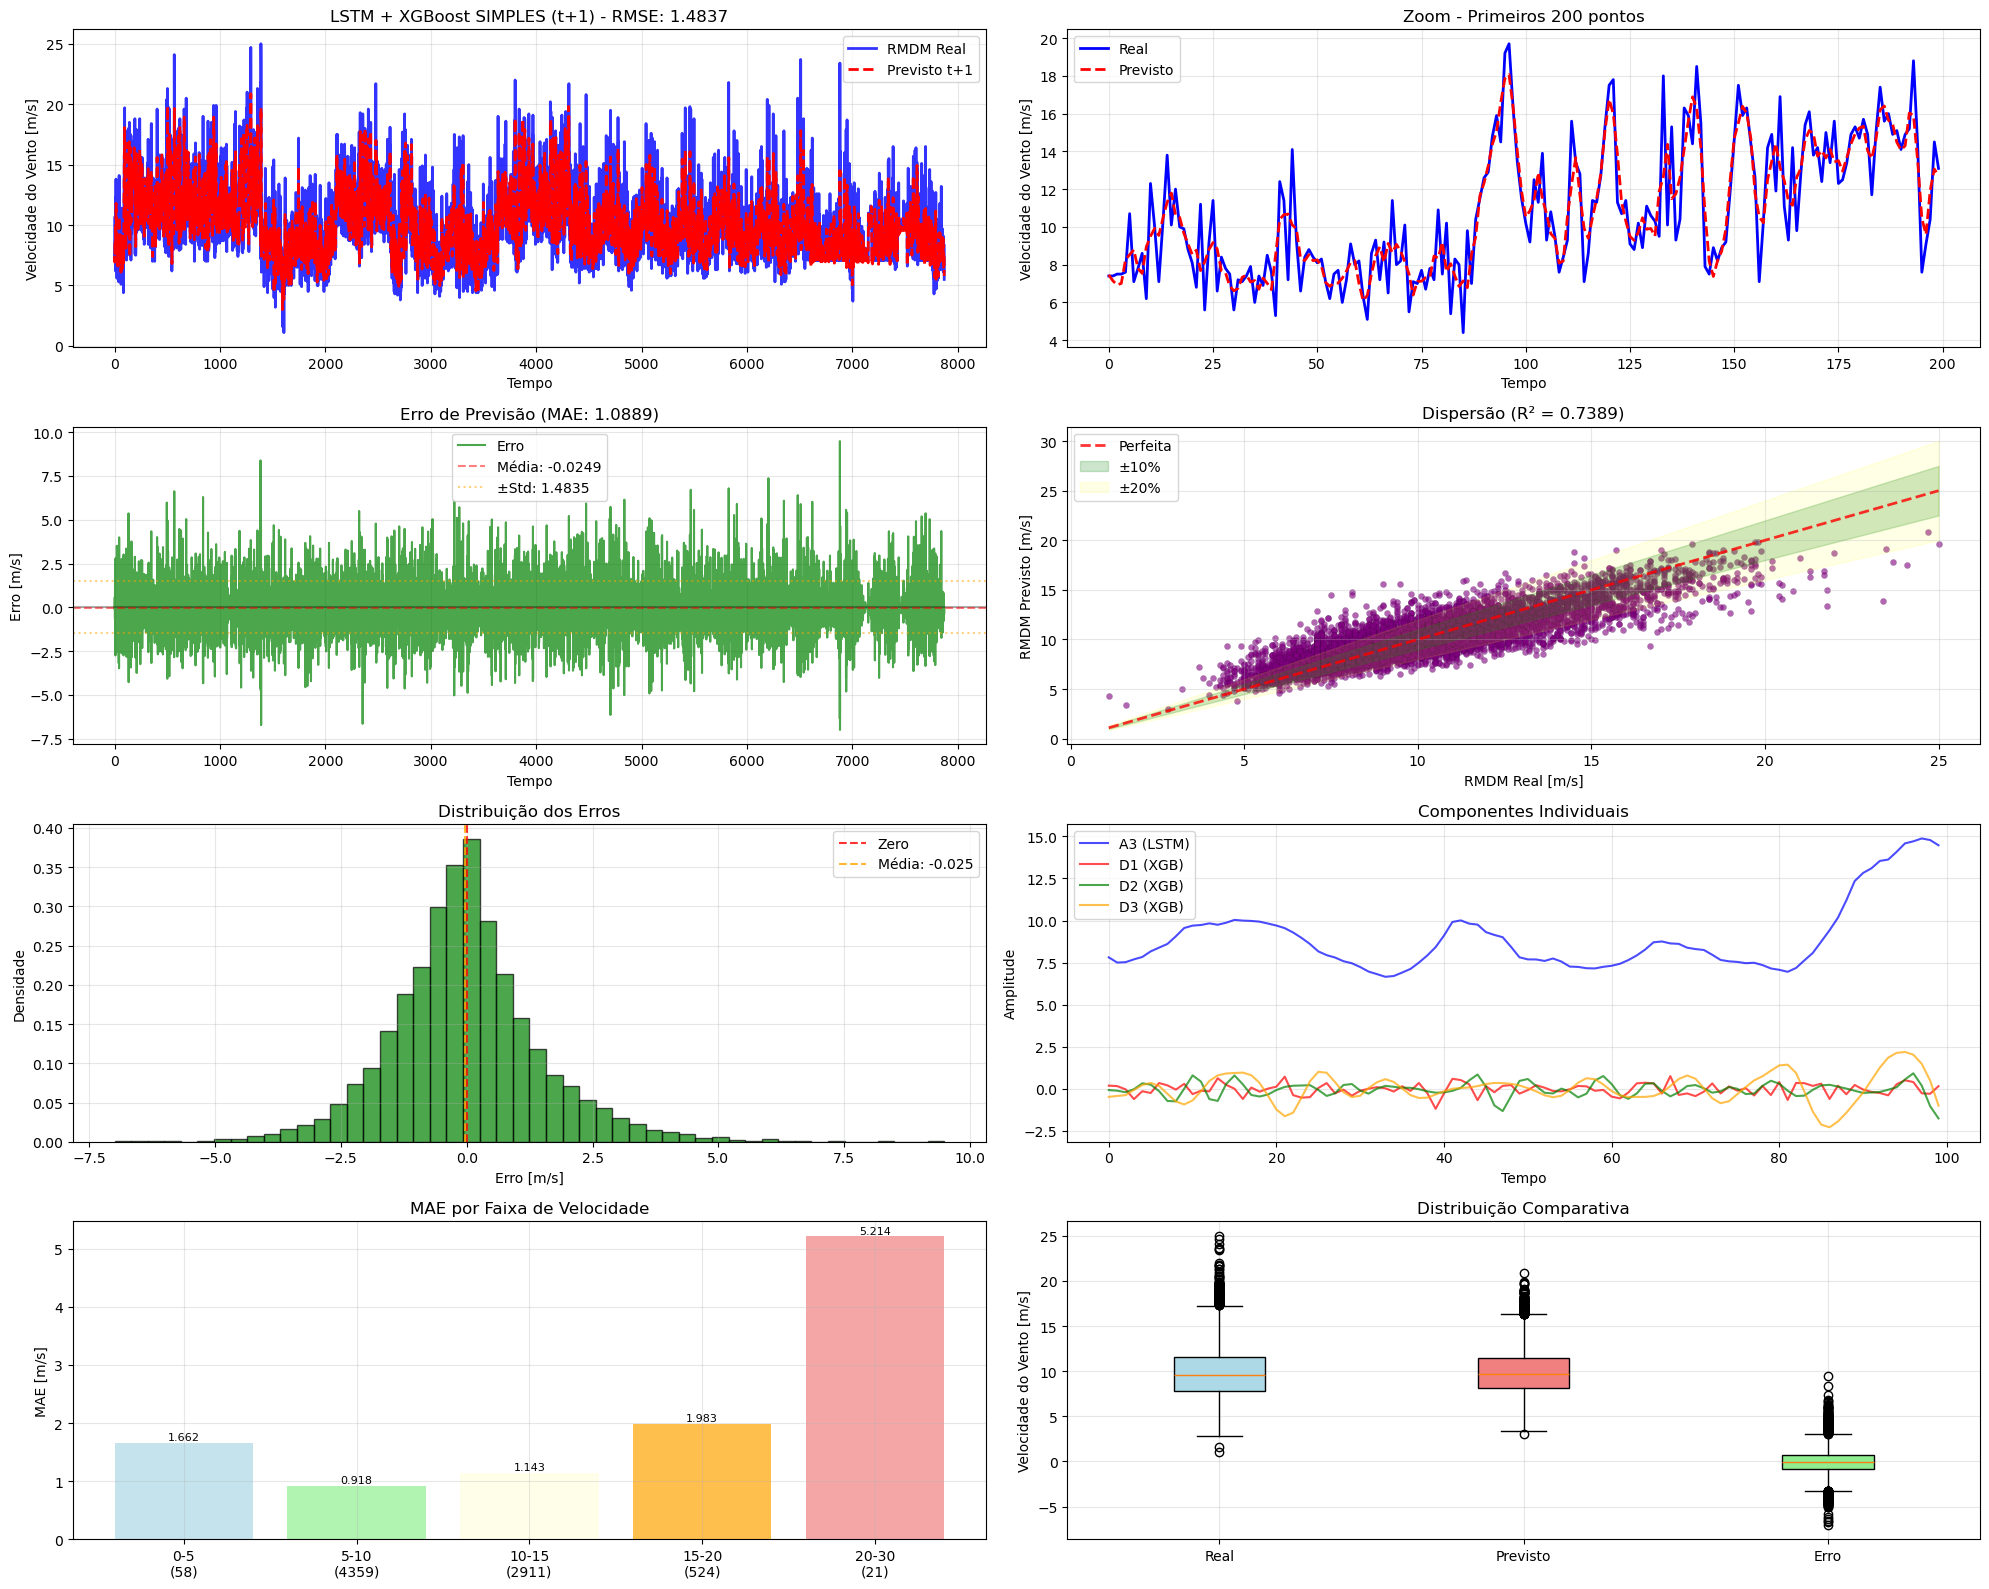


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.990 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 3.001 | Max: 20.862
      Média: 10.015 | Std: 2.437
      Q25: 8.191 | Q75: 11.440
   ❌ ERROS:
      Erro médio: -0.0249
      Std erro: 1.4835
      Max erro absoluto: 9.4834
   🔗 CORRELAÇÃO: 0.8599
   ⚖️ TENDÊNCIA: sem viés significativo
✅ t+1 CONCLUÍDO

🔵🔵 ⚪⚪ PROCESSANDO t+5 (2/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+5
   🧠 A3: LSTM (sequências) - look_back=5
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7869 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🎯 Prevendo D1 com ENSEMBLE ESPECIALIZADO...
      ✅ Ensemble carregado: ['baixos', 'altos', 'geral']
      - Look_back: 5
      - Dataset shape: (7869, 5)
      - Previsão geral: range=[-5.762, 4.190]
      - Distribuição: 594 baixos, 6668 médios, 607 a

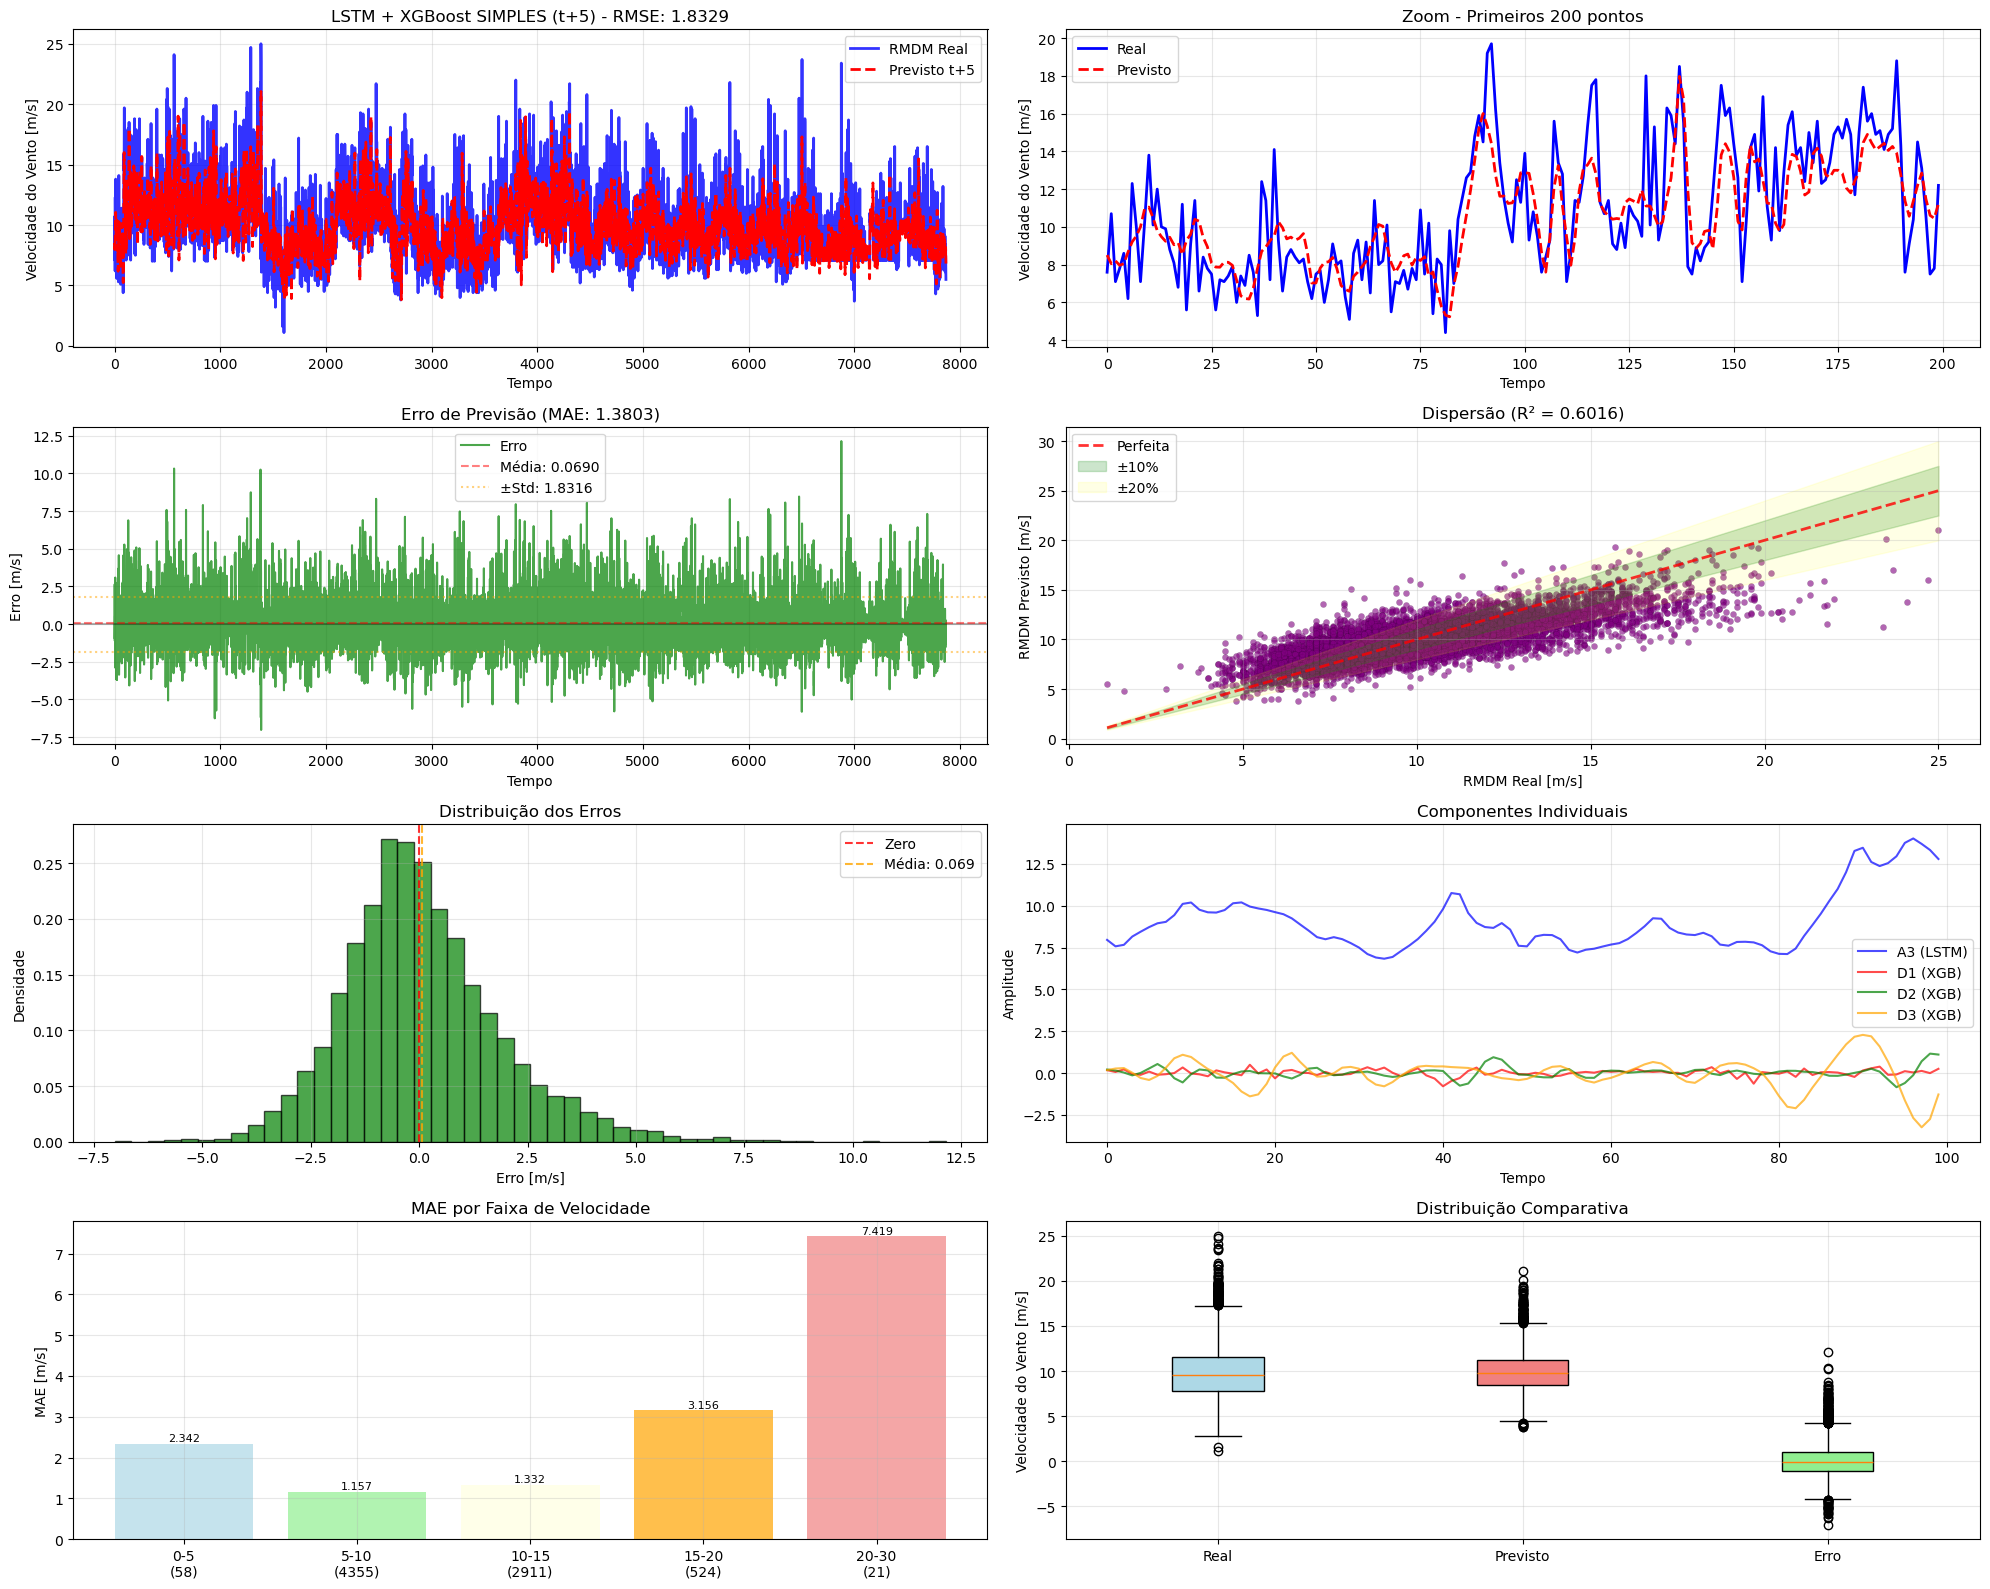


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.991 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 3.818 | Max: 21.053
      Média: 9.922 | Std: 2.054
      Q25: 8.455 | Q75: 11.213
   ❌ ERROS:
      Erro médio: 0.0690
      Std erro: 1.8316
      Max erro absoluto: 12.1485
   🔗 CORRELAÇÃO: 0.7793
   ⚖️ TENDÊNCIA: sem viés significativo
✅ t+5 CONCLUÍDO

🔵🔵🔵 ⚪ PROCESSANDO t+7 (3/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+7
   🧠 A3: LSTM (sequências) - look_back=10
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7862 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🎯 Prevendo D1 com ENSEMBLE ESPECIALIZADO...
      ✅ Ensemble carregado: ['baixos', 'altos', 'geral']
      - Look_back: 10
      - Dataset shape: (7862, 10)
      - Previsão geral: range=[-6.022, 3.810]
      - Distribuição: 727 baixos, 6410 médios, 725

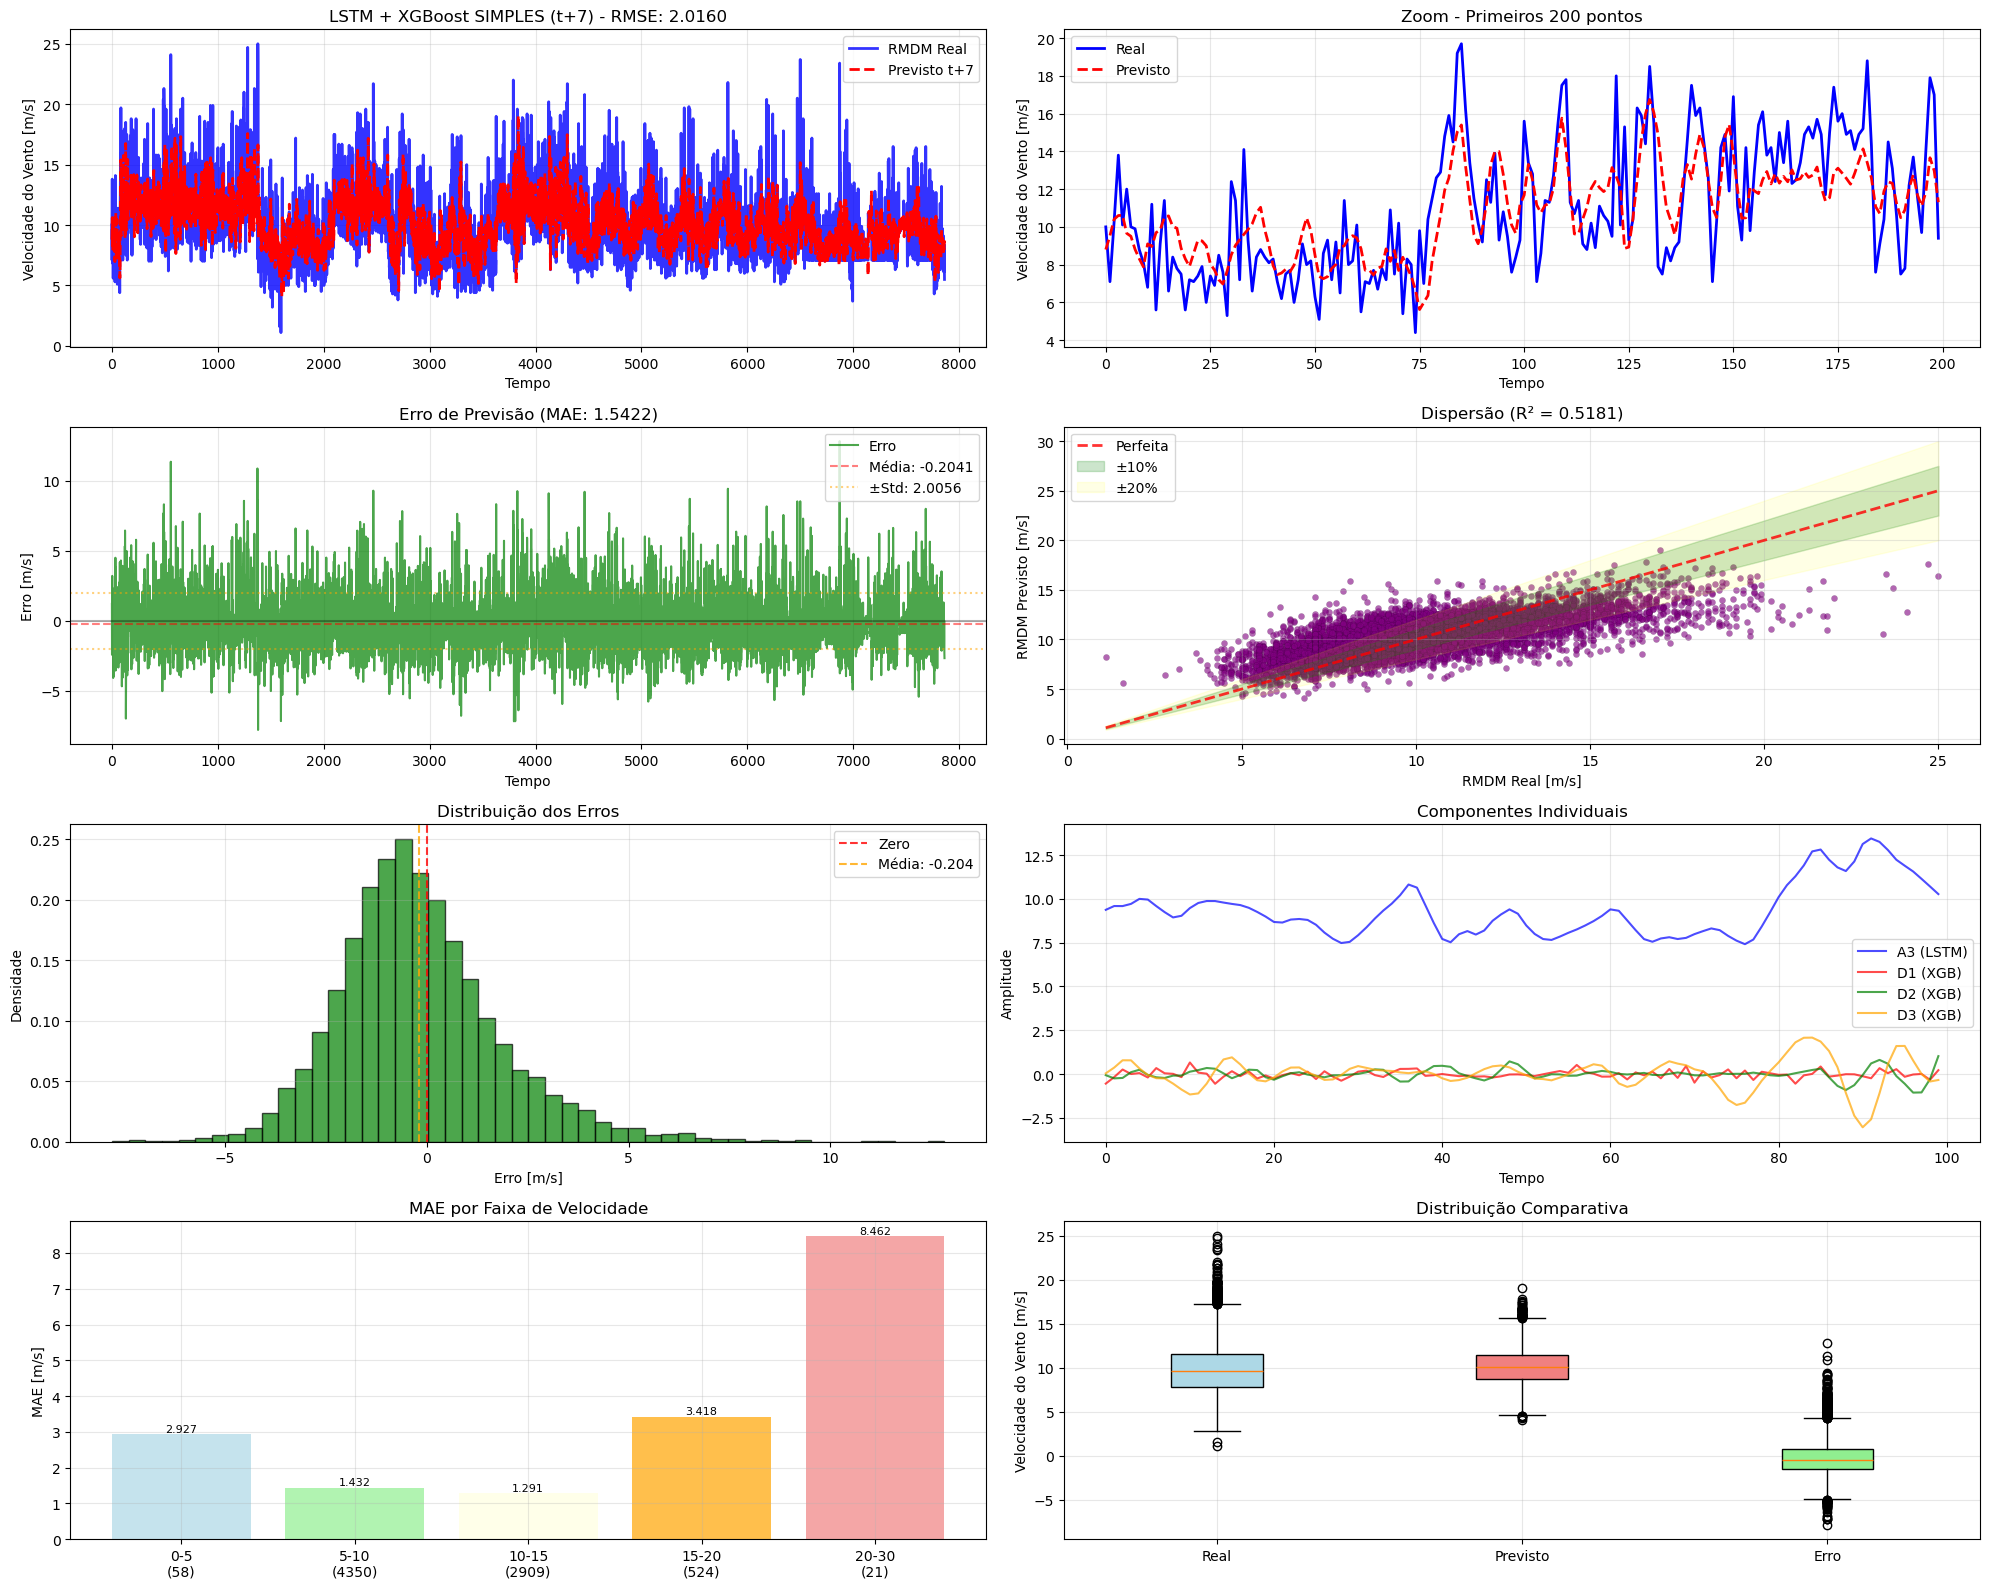


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.992 | Std: 2.904
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 4.076 | Max: 19.050
      Média: 10.196 | Std: 1.932
      Q25: 8.746 | Q75: 11.515
   ❌ ERROS:
      Erro médio: -0.2041
      Std erro: 2.0056
      Max erro absoluto: 12.8284
   🔗 CORRELAÇÃO: 0.7258
   ⚖️ TENDÊNCIA: subestimação (-0.204)
✅ t+7 CONCLUÍDO

🔵🔵🔵🔵  PROCESSANDO t+30 (4/4)

🚀 LSTM + XGBoost SIMPLES - Avaliação t+30
   🧠 A3: LSTM (sequências) - look_back=10
   🌲 D1,D2,D3: XGBoost SIMPLES (apenas sequências)
   📏 Dados reais: 7878 pontos

   🧠 Processando A3 com LSTM...
      ✅ A3 previsto: 7839 pontos

   🌲 Processando D1, D2, D3 com XGBoost SIMPLES...
   🎯 Prevendo D1 com ENSEMBLE ESPECIALIZADO...
      ✅ Ensemble carregado: ['baixos', 'altos', 'geral']
      - Look_back: 10
      - Dataset shape: (7839, 10)
      - Previsão geral: range=[-4.908, 4.564]
      - Distribuição: 751 baixos, 6329 médios, 

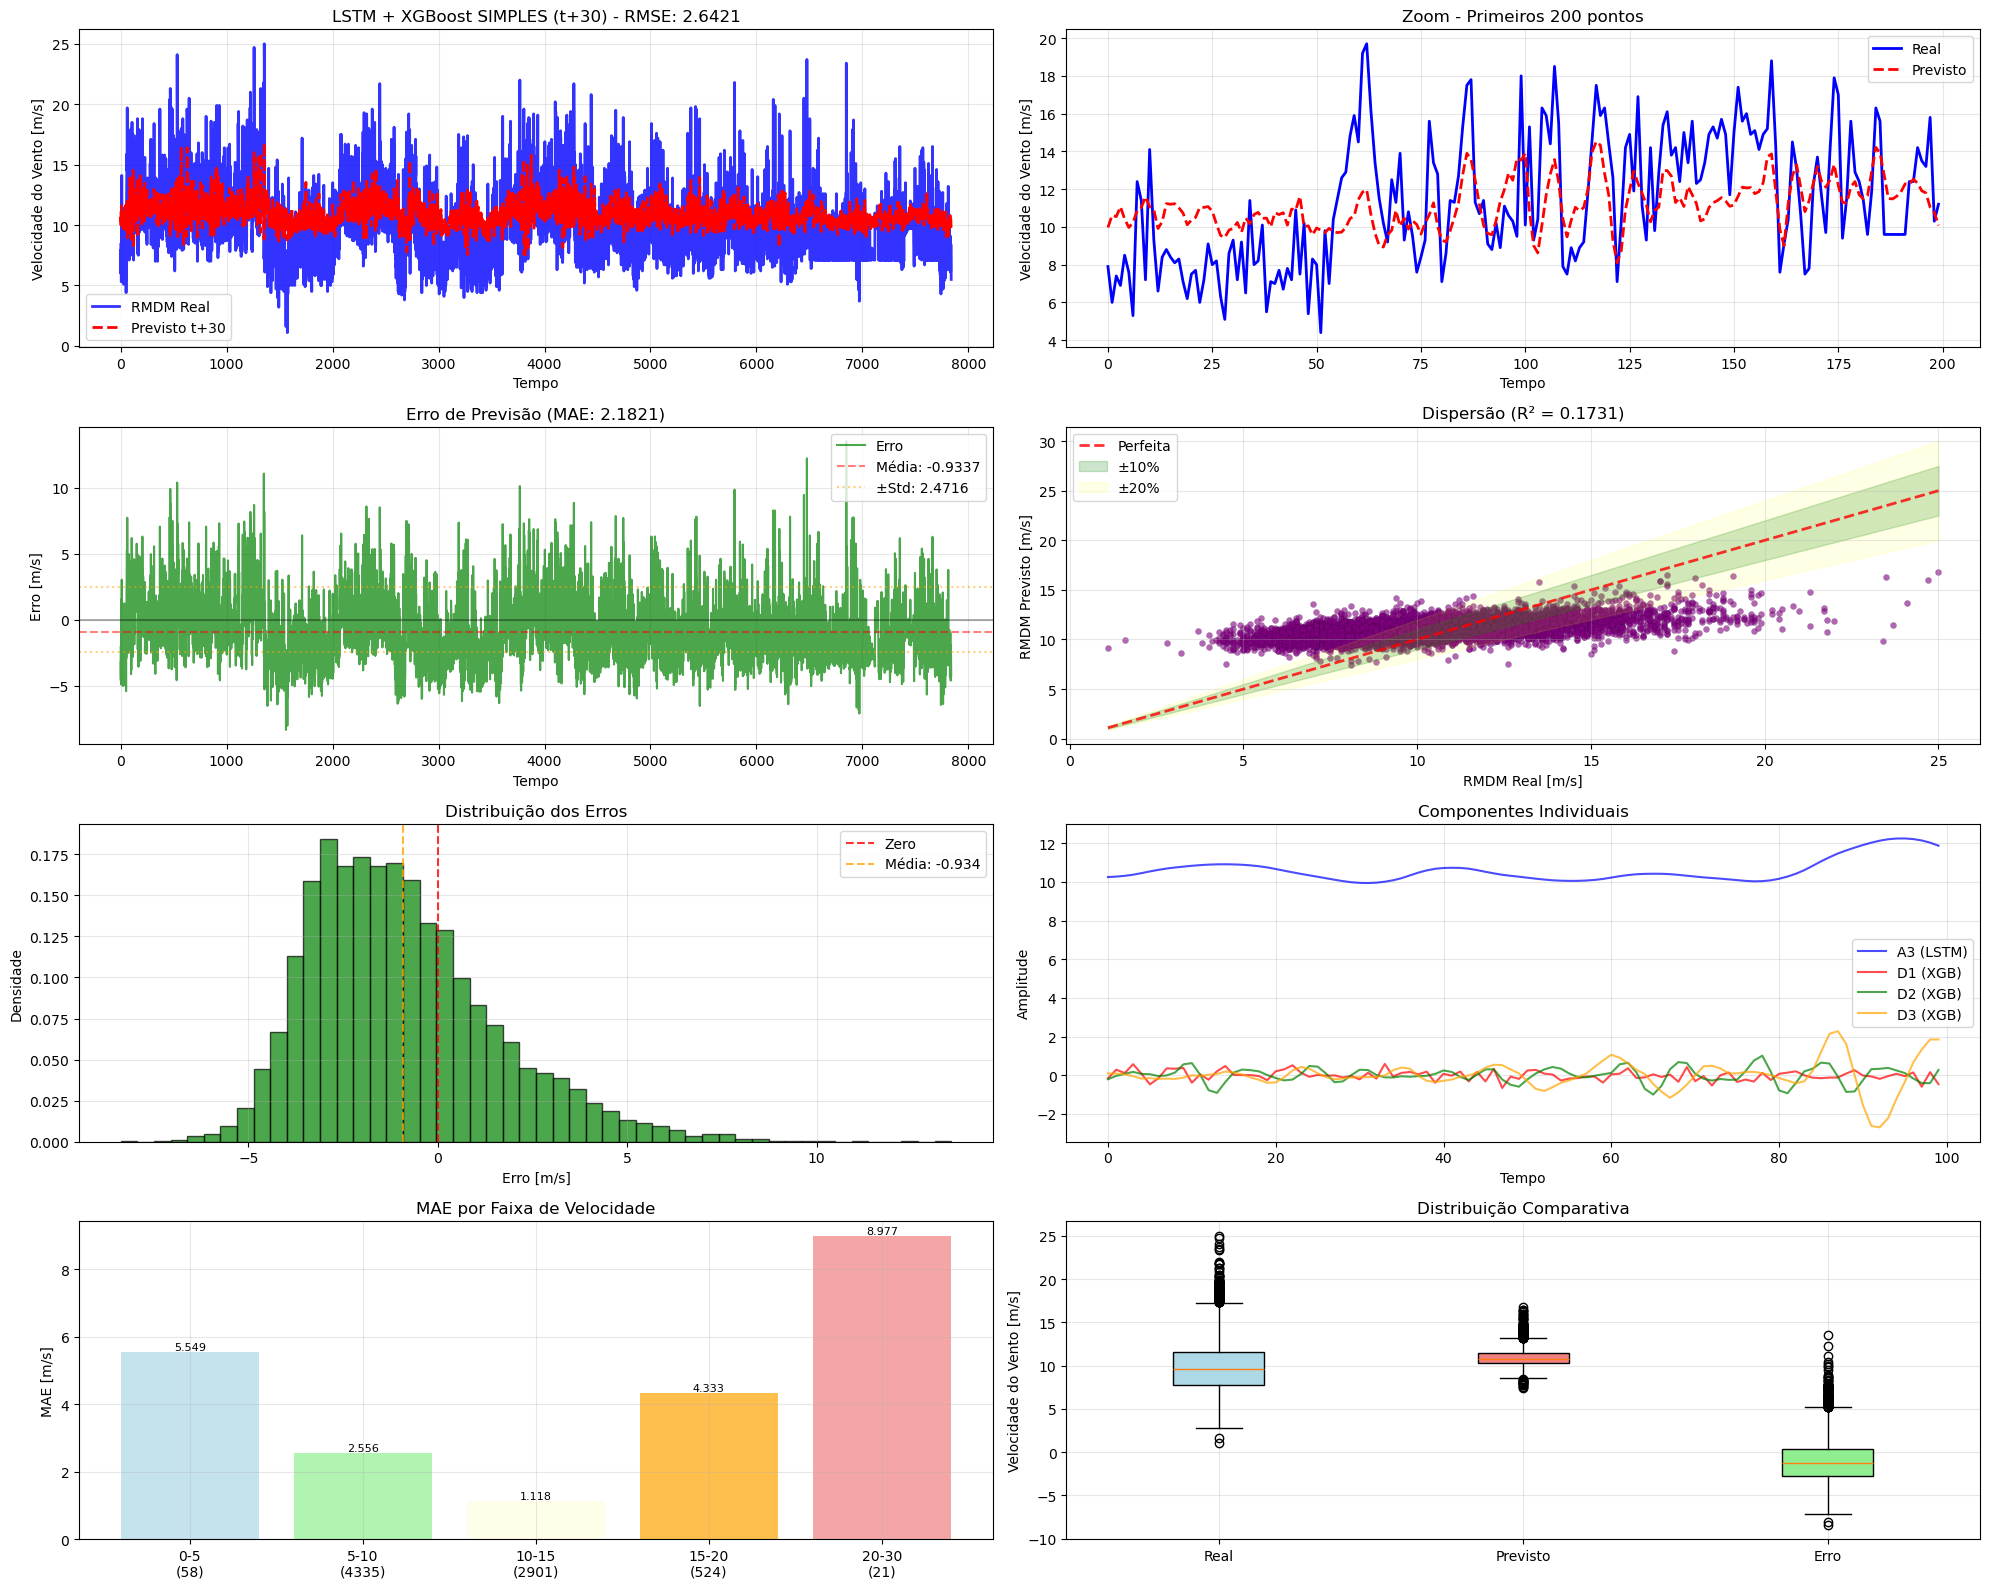


   📊 ANÁLISE ESTATÍSTICA DETALHADA:
   📈 DADOS REAIS:
      Min: 1.100 | Max: 25.000
      Média: 9.996 | Std: 2.906
      Q25: 7.800 | Q75: 11.600
   🎯 PREVISÕES:
      Min: 7.460 | Max: 16.798
      Média: 10.929 | Std: 0.935
      Q25: 10.299 | Q75: 11.453
   ❌ ERROS:
      Erro médio: -0.9337
      Std erro: 2.4716
      Max erro absoluto: 13.5482
   🔗 CORRELAÇÃO: 0.5903
   ⚖️ TENDÊNCIA: subestimação (-0.934)
✅ t+30 CONCLUÍDO

📊 TABELA FINAL DE MÉTRICAS - LSTM + XGBoost SIMPLES
       RMSE    MAE    MAPE     C30     R2
t+1  1.4837 1.0889 11.2935 94.5129 0.7389
t+5  1.8329 1.3803 14.2809 90.1004 0.6016
t+7  2.0160 1.5422 16.4715 85.6652 0.5181
t+30 2.6421 2.1821 25.3540 67.5341 0.1731

📈 ANÁLISE ESTATÍSTICA:
----------------------------------------
 RMSE: min=1.4837, max=2.6421, média=1.9937
  MAE: min=1.0889, max=2.1821, média=1.5484
 MAPE: min=11.2935, max=25.3540, média=16.8500
  C30: min=67.5341, max=94.5129, média=84.4532
   R2: min=0.1731, max=0.7389, média=0.5079

📏 ANÁLISE 

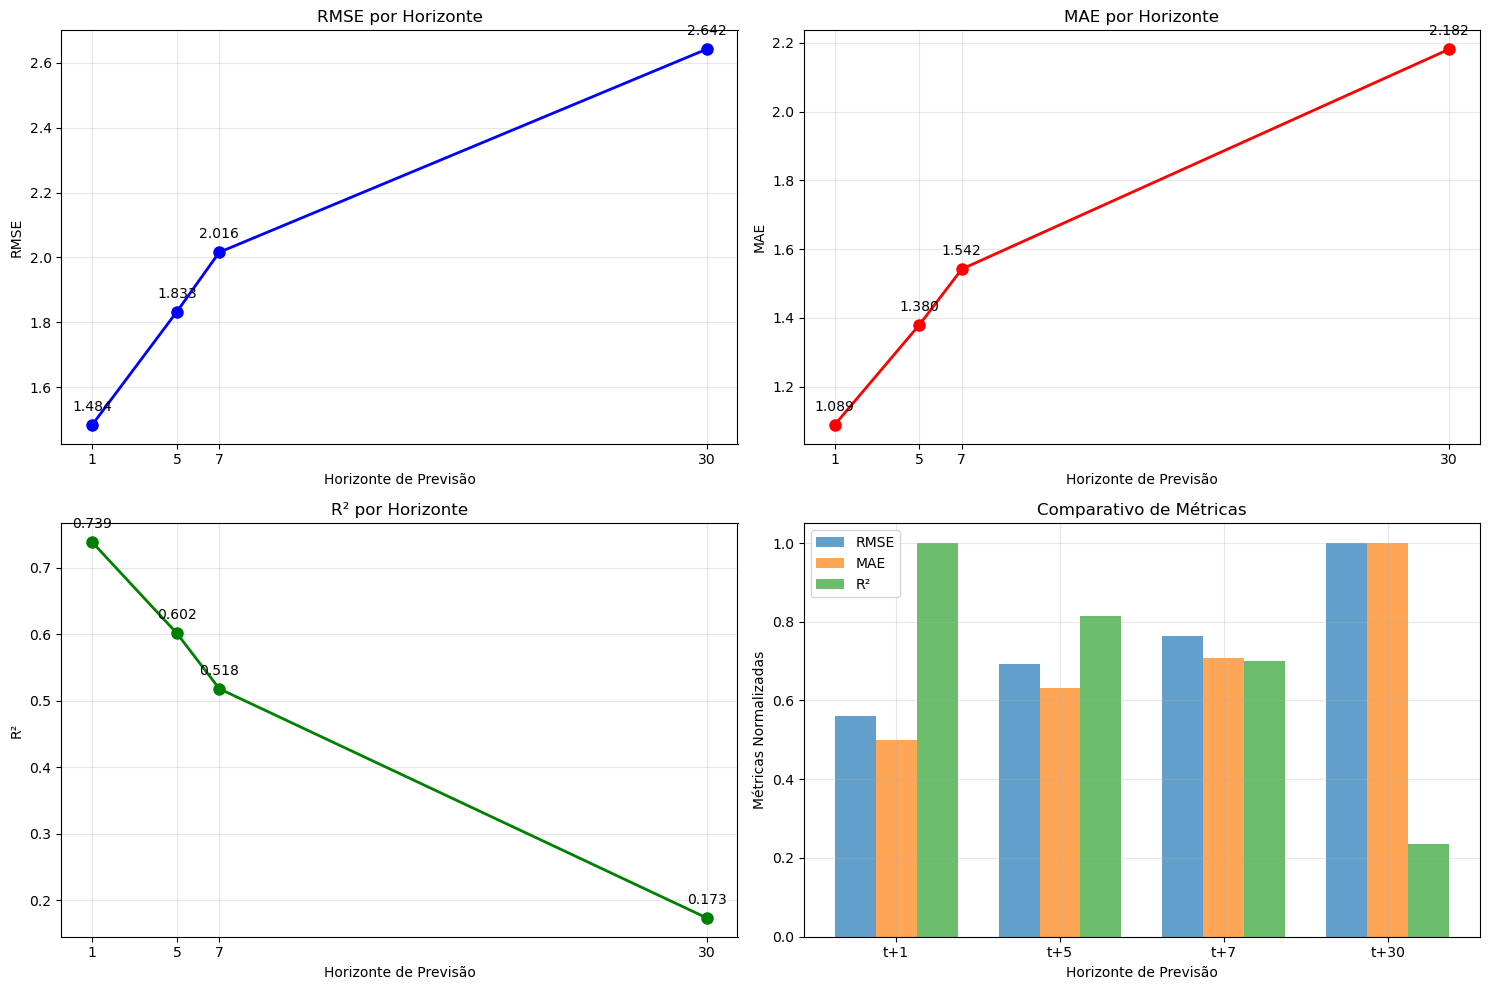


💾 SALVANDO RESULTADOS...
   ✅ Métricas salvas: resultados/metricas_lstm_xgb_simples.csv
   ✅ Análise detalhada: resultados/analise_detalhada_lstm_xgb_simples.csv
   ✅ Resumo JSON: resultados/resumo_lstm_xgb_simples.json

🎉 AVALIAÇÃO COMPLETA!


In [16]:
resultados = avaliar_sistema_completo_lstm_xgb_simples([1, 5, 7, 30])